In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Layout, interactive
from scipy.stats import pearsonr, skew, kurtosis, norm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.formula.api import ols
import seaborn as sns
import math
import scipy
import matplotlib
import openpyxl
import scipy.integrate as integrate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read data

In [2]:
# --------------------------------------------------------------------
# Read and Process FED Data
# --------------------------------------------------------------------
# Read data (Skipping lines without data)
data_fed = pd.read_csv("feds200805.csv", sep=",", skiprows=18) # reading file

# Select maturities and end_of_month dates
data_fed = data_fed.query("Date >= '1999-01-04' and Date <= '2025-01-31'").set_index('Date')
data_fed = data_fed[['TIPSY02', 'TIPSY10', 'BKEVEN02', 'BKEVEN10']] * 0.01

data_fed.index = pd.to_datetime(data_fed.index) # to date
data_fed = data_fed.resample('M').last() # EOM

# rename index as yyyy-mm
data_fed.index = data_fed.index.strftime('%Y-%m')


# --------------------------------------------------------------------
# Read and Process Asset Data
# --------------------------------------------------------------------
asset_file_path = "AssetData.csv"

asset_data = pd.read_csv(asset_file_path, skiprows=3, delimiter=";", index_col=0, parse_dates=True, decimal=",", dayfirst=True)

# Convert index to datetime and then to a monthly PeriodIndex
asset_data.index = pd.to_datetime(asset_data.index, errors='coerce')
asset_data = asset_data.resample('M').last()
asset_data[['USGGBE02 Index', 'USGGBE10 Index',
       'USGGBE30 Index', 'USGG2YR Index', 'USGG5YR Index', 'USGG10YR Index',
       'USGG30YR Index', 'USGG3M Index', 'UST_3M']] *= 0.01

# rename index as yyyy-mm
asset_data.index = asset_data.index.strftime('%Y-%m')

# --------------------------------------------------------------------
# Read and Process Inflation Data
# --------------------------------------------------------------------
inflation_file_path = "inflationdata.csv"

inflation_data = pd.read_csv(inflation_file_path, delimiter=";", header=0, usecols=[1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13], decimal=",")

# Convert the Date column
inflation_data["Date"] = pd.to_datetime(inflation_data["Date"], format="%d-%m-%Y", errors="coerce") 
# inflation_data["Date"] = inflation_data["Date"] - pd.DateOffset(days=1)
# Set the Date column as the index.
inflation_data.set_index("Date", inplace=True)
# Convert index to a monthly PeriodIndex.
inflation_data = inflation_data.resample('M').last()

# Convert InflationRate to numeric (if not already)
inflation_data["YoYCPI"] = pd.to_numeric(inflation_data["YoYCPI"], errors="coerce")
inflation_data["MoMCPI"] = pd.to_numeric(inflation_data["MoMCPI"], errors="coerce")
inflation_data["CPIAUCNS"] = pd.to_numeric(inflation_data["CPIAUCNS"], errors="coerce")

# rename index as yyyy-mm
inflation_data.index = inflation_data.index.strftime('%Y-%m')

# --------------------------------------------------------------------
# Read and Process Shiller bond returns Data
# --------------------------------------------------------------------

shiller_path = 'Shiller_returns.csv'
shiller_data = pd.read_csv(shiller_path, delimiter=";", decimal=",", header=0, usecols=[0, 1, 3, 4, 5, 6, 7, 8])

shiller_data[['GS2','GS10']] *= 0.01
shiller_data[['2y_returns','2y_real_returns','10y_returns','10y_real_returns']] -= 1

shiller_data.index = pd.to_datetime(shiller_data["Date"], format="%Y-%m", errors="coerce")
shiller_data = shiller_data.drop(columns=['Date'])
shiller_data.index = shiller_data.index.strftime('%Y-%m')

# --------------------------------------------------------------------
# Read and Process real and BE approx Data
# --------------------------------------------------------------------

approx_path = 'real_and_bei_backcast_approx.csv'
approx_data = pd.read_csv(approx_path, delimiter=";", decimal=",")
approx_data.index = pd.to_datetime(approx_data["Date"], format="%d-%m-%Y", errors="coerce") - pd.DateOffset(days=1)

approx_data = approx_data.dropna(how='all')
approx_data = approx_data.drop(columns=['Date', 'Predicted_Real_5y', 'Predicted_Real_30y', '5y5y_approx', 'Predicted_BEi_5y', 'Predicted_BEi_30y', '5y5y_approx.1'])
approx_data.index = approx_data.index.strftime('%Y-%m')
approx_data[['Predicted_Real_2y','Predicted_Real_10y','Predicted_BEi_2y','Predicted_BEi_10y']] *= 0.01

# --------------------------------------------------------------------
# Combine above 
# --------------------------------------------------------------------
combined_data = shiller_data.join(inflation_data, how='outer').join(data_fed, how='outer').join(asset_data, how='outer')

In [4]:
# --------------------------------------------------------------------
# Read and Process Inflation Data
# --------------------------------------------------------------------
PCE_file_path = "PCEPI.csv"

PCE_data = pd.read_csv(PCE_file_path, delimiter=";", header=0, usecols=[1, 3, 4, 5], decimal=",")

# Convert the Date column
PCE_data["Date"] = pd.to_datetime(PCE_data["Date"], format="%d-%m-%Y", errors="coerce") 
# Set the Date column as the index.
PCE_data.set_index("Date", inplace=True)
# Convert index to a monthly PeriodIndex.
PCE_data = PCE_data.resample('M').last()

# rename index as yyyy-mm
PCE_data.index = PCE_data.index.strftime('%Y-%m')

### Real rates:
#### $i_r$ = $i_n$ - $\pi^{BEI}$

In [5]:
# ----------------------------
#Calculate and confirm real rates
# ----------------------------

# GS2 and GS10 
real_rate_02 = combined_data["GS2"].subtract(combined_data["USGGBE02 Index"]).dropna(how="all")
# print("2Y real rates")
# print(real_rate_02)

real_rate_10 = combined_data["GS10"].subtract(combined_data["USGGBE10 Index"]).dropna(how="all")
# print("\n10Y real rates")
# print(real_rate_10)

# Differences (so that we can argue than using the Goldman approx is ok)
diff_2y = real_rate_02.subtract(combined_data["TIPSY02"]).dropna(how="all")
diff_10y = real_rate_10.subtract(combined_data["TIPSY10"]).dropna(how="all")

diff_2y_approx = combined_data["TIPSY02"].subtract(approx_data["Predicted_Real_2y"]).dropna(how="all")
diff_10y_approx = combined_data["TIPSY10"].subtract(approx_data["Predicted_Real_10y"]).dropna(how="all")

diff_2y_approx = real_rate_02.subtract(approx_data["Predicted_Real_2y"]).dropna(how="all")
diff_10y_approx = real_rate_10.subtract(approx_data["Predicted_Real_10y"]).dropna(how="all")

# Compare real rates to TIPS from BB
print("\nDifference 2y: calculated - TIPS")
print(diff_2y.head())
print("\nDifference 10y: calculated - TIPS")
print(diff_10y.head())
print("\nDifference 2y approx: approx - TIPS")
print(diff_2y_approx.head())
print("\nDifference 10y approx: approx - TIPS")
print(diff_10y_approx.head())
print("\nDifference 2y: approx - calculated")
print(diff_2y_approx.head())
print("\nDifference 10y: approx - calculated")
print(diff_10y_approx.head())

# Make a nice table comparing them, to show approksimations are fine



Difference 2y: calculated - TIPS
2004-10    0.000447
2004-11    0.000298
2004-12    0.000016
2005-01   -0.000689
2005-02   -0.000251
dtype: float64

Difference 10y: calculated - TIPS
1999-01    0.000269
1999-02    0.000350
1999-03    0.000217
1999-04   -0.000006
1999-05    0.000273
dtype: float64

Difference 2y approx: approx - TIPS
2004-10   -0.003582
2004-11   -0.008290
2004-12   -0.002281
2005-01    0.000091
2005-02    0.000782
dtype: float64

Difference 10y approx: approx - TIPS
1998-08    0.001364
1998-09    0.001615
1998-10   -0.001795
1998-11   -0.000791
1998-12    0.003009
dtype: float64

Difference 2y: approx - calculated
2004-10   -0.003582
2004-11   -0.008290
2004-12   -0.002281
2005-01    0.000091
2005-02    0.000782
dtype: float64

Difference 10y: approx - calculated
1998-08    0.001364
1998-09    0.001615
1998-10   -0.001795
1998-11   -0.000791
1998-12    0.003009
dtype: float64


### Append approximated real rates and Breakeven to FED TIPS and Bloomberg Breakeven

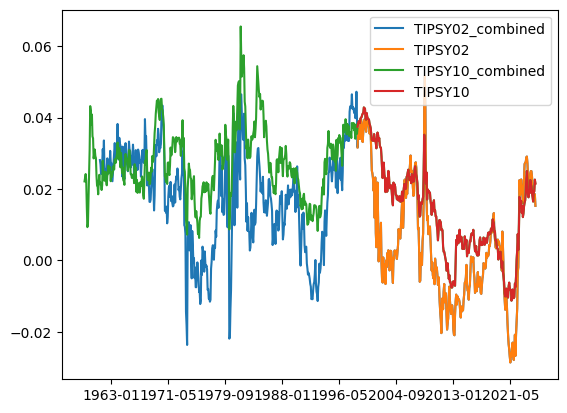

In [6]:
# pd.concat([combined_data['TIPSY02'], approx_data['Predicted_Real_2y']], axis=1).apply(lambda x: x['Predicted_Real_2y'] if pd.isnull(x['TIPSY02']) else x['TIPSY02'], axis=1)
combined_data['TIPSY02_combined'] = combined_data.join(approx_data['Predicted_Real_2y'], how='left').apply(lambda x: x['Predicted_Real_2y'] if pd.isnull(x['TIPSY02']) else x['TIPSY02'], axis=1)
combined_data['TIPSY10_combined'] = combined_data.join(approx_data['Predicted_Real_10y'], how='left').apply(lambda x: x['Predicted_Real_10y'] if pd.isnull(x['TIPSY10']) else x['TIPSY10'], axis=1)
combined_data[['TIPSY02_combined','TIPSY02','TIPSY10_combined','TIPSY10']].plot()
plt.show()

# 10Y and 30Y: from 31-08-1998 
# 2Y: from 31-10-2004

## Now that you have real rates, calculate TIPS and breakeven excess returns

In [7]:
# ----------------------------
# TIPS Returns
# ----------------------------

# 2 year
combined_data['real_duration_2y'] = (2 * (1 + combined_data['TIPSY02_combined'])**(-2) * (1 + combined_data['TIPSY02_combined']) +
                                                1 * (1 + combined_data['TIPSY02_combined'])**(-1) * combined_data['TIPSY02_combined'])
combined_data['return_2y_rate_chg'] = - combined_data['real_duration_2y'] * combined_data['TIPSY02_combined'].diff()
combined_data['return_2y_coupon'] = combined_data['TIPSY02_combined'] / 12
combined_data['tips_2y_return'] = (combined_data['return_2y_rate_chg'] + combined_data['return_2y_coupon']) + combined_data['MoMCPI']
combined_data['tips_2y_return_yoy'] = (1 + combined_data['tips_2y_return']).rolling(window=12).apply(np.prod) -1

# 10 year
combined_data['real_duration_10y'] = (10 * (1 + combined_data['TIPSY10_combined'])**(-10) * (1 + combined_data['TIPSY10_combined']) +
                                                9 * (1 + combined_data['TIPSY10_combined'])**(-9) * combined_data['TIPSY10_combined'] +
                                                8 * (1 + combined_data['TIPSY10_combined'])**(-8) * combined_data['TIPSY10_combined'] +
                                                7 * (1 + combined_data['TIPSY10_combined'])**(-7) * combined_data['TIPSY10_combined'] +
                                                6 * (1 + combined_data['TIPSY10_combined'])**(-6) * combined_data['TIPSY10_combined'] +
                                                5 * (1 + combined_data['TIPSY10_combined'])**(-5) * combined_data['TIPSY10_combined'] +
                                                4 * (1 + combined_data['TIPSY10_combined'])**(-4) * combined_data['TIPSY10_combined'] +
                                                3 * (1 + combined_data['TIPSY10_combined'])**(-3) * combined_data['TIPSY10_combined'] +
                                                2 * (1 + combined_data['TIPSY10_combined'])**(-2) * combined_data['TIPSY10_combined'] +
                                                1 * (1 + combined_data['TIPSY10_combined'])**(-1) * combined_data['TIPSY10_combined'])

combined_data['return_10y_rate_chg'] = - combined_data['real_duration_10y'] * combined_data['TIPSY10_combined'].diff()
combined_data['return_10y_coupon'] = combined_data['TIPSY10_combined'] / 12
combined_data['tips_10y_return'] = (combined_data['return_10y_rate_chg'] + combined_data['return_10y_coupon']) + combined_data['MoMCPI']
combined_data['tips_10y_return_yoy'] = (1 + combined_data['tips_10y_return']).rolling(window=12).apply(np.prod) -1

# Make bond returns YoY
combined_data['bond2y_return_yoy'] = (1 + combined_data['2y_returns']).rolling(window=12).apply(np.prod) - 1
combined_data['bond10y_return_yoy'] = (1 + combined_data['10y_returns']).rolling(window=12).apply(np.prod) - 1

# Make 3M monthly so you can subtract it
combined_data["quarterly_rate"] = (1 + combined_data['USGG3M Index'])**(1/4) - 1
combined_data["US3M_approx"] = (1 + combined_data['quarterly_rate'])**(1/3) - 1
combined_data['US3M_approx_yoy'] = (1 + combined_data['US3M_approx']).rolling(window=12).apply(np.prod) -1

combined_data['bond10y_excess_return_yoy'] = combined_data['bond10y_return_yoy'].subtract(combined_data['US3M_approx_yoy']).dropna(how="all")
combined_data['bond2y_excess_return_yoy'] = combined_data['bond2y_return_yoy'].subtract(combined_data['US3M_approx_yoy']).dropna(how="all")

# Merge TIPS 
combined_data['LBUTTRUU_return_index'] = ((combined_data["LBUTTRUU Index"].pct_change())).dropna(how="all")
combined_data['LBUTTRUU_return_index_yoy'] = ((combined_data["LBUTTRUU Index"].pct_change(12))).dropna(how="all")
combined_data['combined_tips10y'] = combined_data.apply(lambda x: x['tips_10y_return'] if pd.isnull(x['LBUTTRUU_return_index']) else x['LBUTTRUU_return_index'], axis=1)
combined_data['combined_tips10y_yoy'] = combined_data.apply(lambda x: x['tips_10y_return_yoy'] if pd.isnull(x['LBUTTRUU_return_index_yoy']) else x['LBUTTRUU_return_index_yoy'], axis=1)

combined_data['MERG1QI_return_index'] = ((combined_data["MERG1QI"].pct_change())).dropna(how="all")
combined_data['MERG1QI_return_index_yoy'] = ((combined_data["MERG1QI"].pct_change(12))).dropna(how="all")
combined_data['combined_tips2y'] = combined_data.apply(lambda x: x['tips_2y_return'] if pd.isnull(x['MERG1QI_return_index']) else x['MERG1QI_return_index'], axis=1)
combined_data['combined_tips2y_yoy'] = combined_data.apply(lambda x: x['tips_2y_return_yoy'] if pd.isnull(x['MERG1QI_return_index_yoy']) else x['MERG1QI_return_index_yoy'], axis=1)

combined_data['tips10y_excess_yoy'] = combined_data['tips_10y_return_yoy'].subtract(combined_data["US3M_approx_yoy"]).dropna(how="all")
combined_data['tips2y_excess_yoy'] = combined_data['tips_2y_return_yoy'].subtract(combined_data["US3M_approx_yoy"]).dropna(how="all")

### Breakeven returns

In [8]:
# ----------------------------
# Breakeven Returns
# ----------------------------
combined_data['bei_2y_excess_return'] = combined_data['tips_2y_return'].subtract(combined_data['2y_returns']).dropna(how="all")
combined_data['bei_10y_excess_return'] = combined_data['tips_10y_return'].subtract(combined_data['10y_returns']).dropna(how="all")
combined_data['bei_2y_excess_return_yoy'] = combined_data['tips_2y_return_yoy'].subtract(combined_data['bond2y_return_yoy']).dropna(how="all")
combined_data['bei_10y_excess_return_yoy'] = combined_data['tips_10y_return_yoy'].subtract(combined_data['bond10y_return_yoy']).dropna(how="all")

# BEI return is excess plus funding, here cash
combined_data['bei_2y_return'] = combined_data['bei_2y_excess_return'].add(combined_data['US3M_approx']).dropna(how="all")
combined_data['bei_10y_return'] = combined_data['bei_10y_excess_return'].add(combined_data['US3M_approx']).dropna(how="all")

combined_data['bei_2y_return_yoy'] = combined_data['bei_2y_excess_return_yoy'].add(combined_data['US3M_approx_yoy']).dropna(how="all")
combined_data['bei_10y_return_yoy'] = combined_data['bei_10y_excess_return_yoy'].add(combined_data['US3M_approx_yoy']).dropna(how="all")

# Merge BEI
combined_data['BSWIZU10_return_index'] = ((combined_data["BSWIZU10 Index"].pct_change())).dropna(how="all")
combined_data['BSWIZU10_return_index_yoy'] = ((combined_data["BSWIZU10 Index"].pct_change(12))).dropna(how="all")
combined_data['combined_bei10y'] = combined_data.apply(lambda x: x['bei_10y_excess_return'] if pd.isnull(x['BSWIZU10_return_index']) else x['BSWIZU10_return_index'], axis=1)
combined_data['combined_bei10y_yoy'] = combined_data.apply(lambda x: x['bei_10y_excess_return_yoy'] if pd.isnull(x['BSWIZU10_return_index_yoy']) else x['BSWIZU10_return_index_yoy'], axis=1)

combined_data['BSWIZU02_return_index'] = ((combined_data["BSWIZU02 Index"].pct_change())).dropna(how="all")
combined_data['BSWIZU02_return_index_yoy'] = ((combined_data["BSWIZU02 Index"].pct_change(12))).dropna(how="all")
combined_data['combined_bei2y'] = combined_data.apply(lambda x: x['bei_2y_excess_return'] if pd.isnull(x['BSWIZU02_return_index']) else x['BSWIZU02_return_index'], axis=1)
combined_data['combined_bei2y_yoy'] = combined_data.apply(lambda x: x['bei_2y_excess_return_yoy'] if pd.isnull(x['BSWIZU02_return_index_yoy']) else x['BSWIZU02_return_index_yoy'], axis=1)

# 60/40 returns
combined_data['return_6040'] = combined_data['SPX Index'].pct_change(1)*0.6 + combined_data['10y_returns']*0.4
combined_data['return_6040_yoy'] = (1 + combined_data['return_6040']).rolling(window=12).apply(np.prod) - 1

combined_data['excess_6040_yoy'] = combined_data['return_6040_yoy'].subtract(combined_data['US3M_approx_yoy'])

<Axes: >

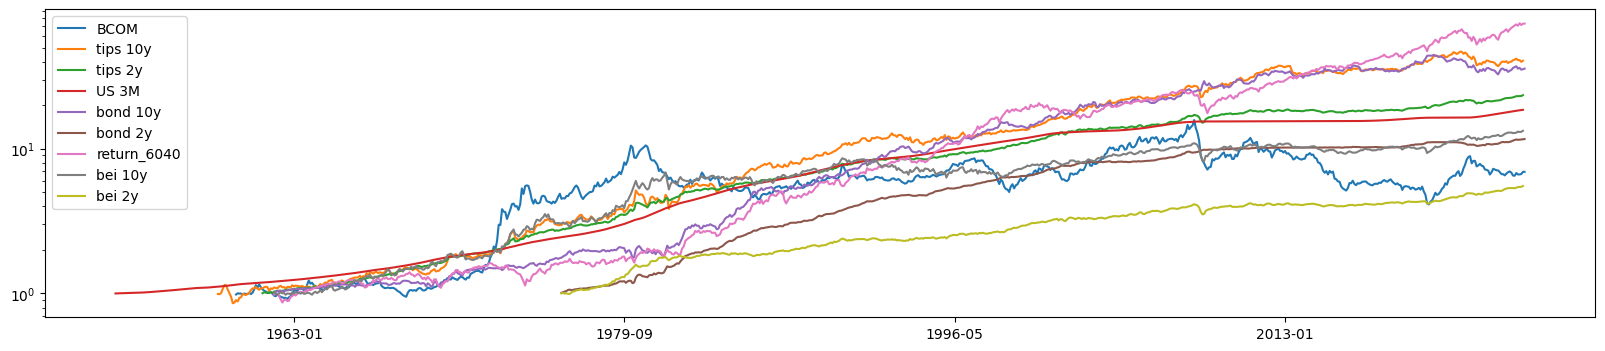

In [9]:
# ----------------------------
# Log cummulative returns
# ----------------------------

fig, axs = plt.subplots(1, 1, figsize=(20, 4))
returns_df = pd.DataFrame()
returns_df['BCOM'] = (combined_data['BCOM Index'].pct_change() + 1).cumprod()
returns_df['tips 10y'] = (combined_data['tips_10y_return'] + 1).cumprod()
returns_df['tips 2y'] = (combined_data['tips_2y_return'] + 1).cumprod()
returns_df['US 3M'] = (combined_data['US3M_approx'] + 1).cumprod()
returns_df['bond 10y'] = (combined_data['10y_returns'] + 1).cumprod()
returns_df['bond 2y'] = (combined_data['2y_returns'] + 1).cumprod()
returns_df['return_6040'] = (combined_data['return_6040'] + 1).cumprod()
returns_df['bei 10y'] = (1+ combined_data['bei_10y_return']).cumprod()
returns_df['bei 2y'] = (1+ combined_data['bei_2y_return']).cumprod()
returns_df.plot(logy=True, ax=axs)


### YoY bond and TIPS return

<Axes: >

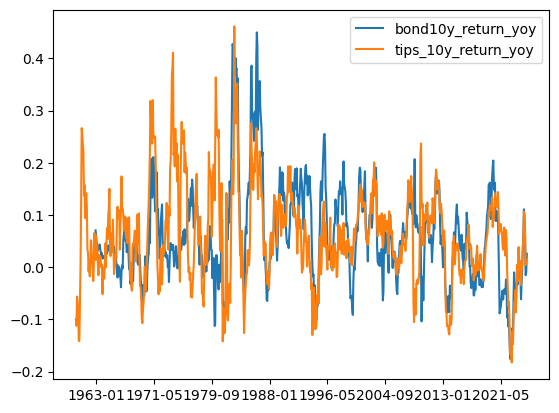

In [10]:
fig, axs = plt.subplots(1, 1)
combined_data[["bond10y_return_yoy","tips_10y_return_yoy"]].plot(ax=axs)

### Show that your approximated Shiller 10Y returns are fine

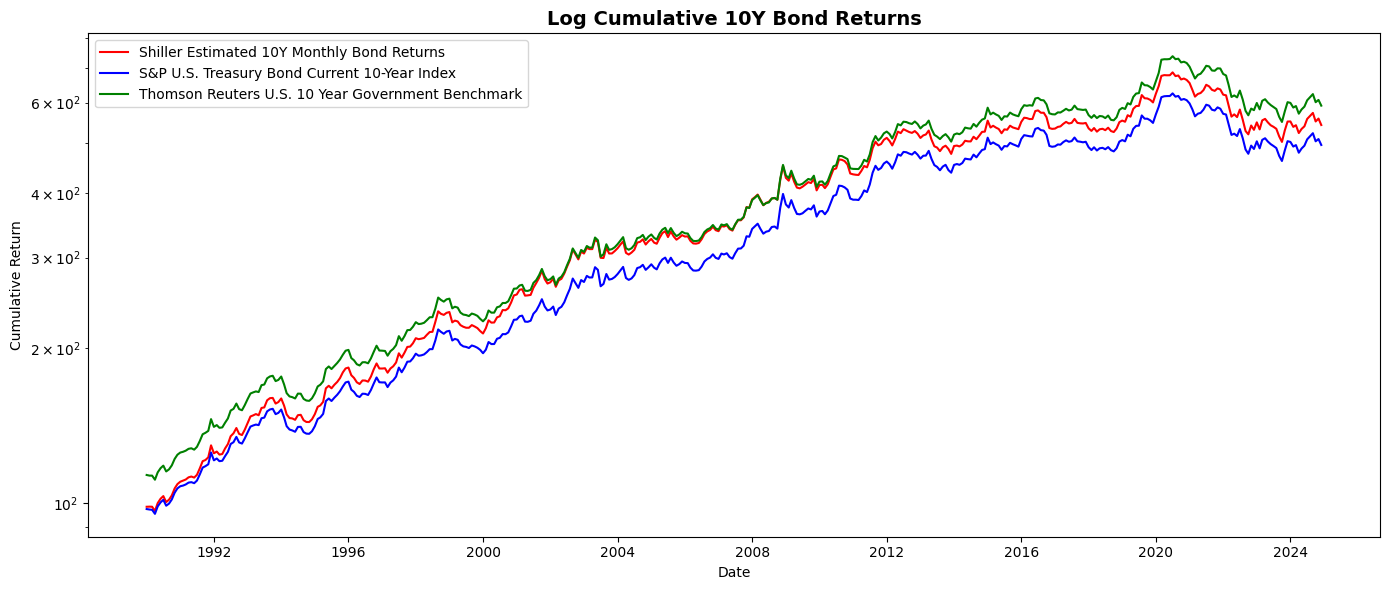

In [11]:
shiller_10y_compounded = combined_data[["10y_returns","SPBDU1BT Index","TRXVUSGOV10U"]].dropna(thresh=3)
shiller_10y_compounded['10y_returns'].iloc[0] = shiller_10y_compounded['SPBDU1BT Index'].iloc[0]
shiller_10y_compounded['10y_compounded'] = (shiller_10y_compounded['10y_returns'] + 1).cumprod()
shiller_10y_compounded.index = pd.to_datetime(shiller_10y_compounded.index)


# Plot
fig, ax = plt.subplots(figsize=(14, 6))
# Plot 
ax.semilogy(shiller_10y_compounded.index, shiller_10y_compounded['10y_compounded'], label='Shiller Estimated 10Y Monthly Bond Returns', color='red')
ax.semilogy(shiller_10y_compounded.index, shiller_10y_compounded['SPBDU1BT Index'], label='S&P U.S. Treasury Bond Current 10-Year Index', color='blue')
ax.semilogy(shiller_10y_compounded.index, shiller_10y_compounded['TRXVUSGOV10U'], label='Thomson Reuters U.S. 10 Year Government Benchmark', color='green')

# Final formatting
ax.set_title('Log Cumulative 10Y Bond Returns', fontsize=14, weight='bold')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()

plt.savefig("bond_comparison.png", bbox_inches='tight', dpi=300)

plt.show()

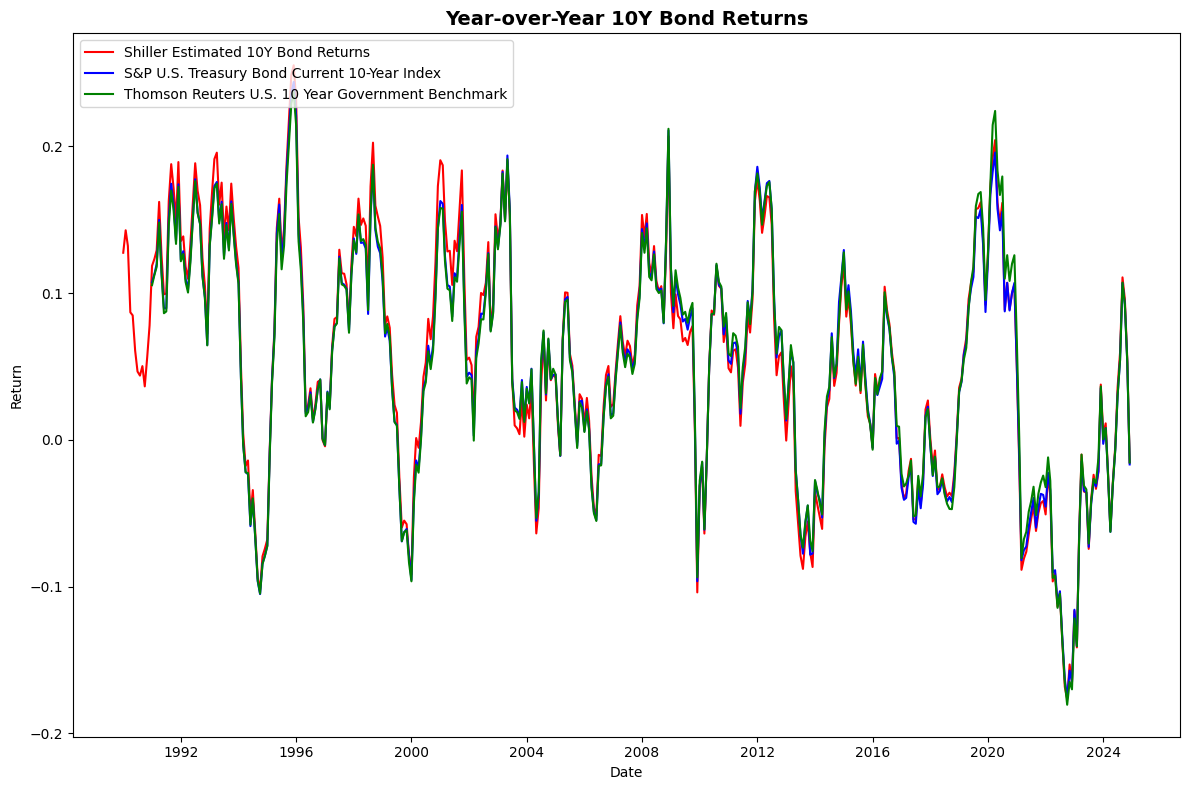

In [50]:
shiller_10y_compounded = combined_data[["bond10y_return_yoy","SPBDU1BT Index","TRXVUSGOV10U"]].dropna(thresh=3)
# shiller_10y_compounded['bond10y_return_yoy'].iloc[0] = shiller_10y_compounded['SPBDU1BT Index'].iloc[0]
shiller_10y_compounded.index = pd.to_datetime(shiller_10y_compounded.index)

shiller_10y_compounded['SPBDU1BT_yoy'] = shiller_10y_compounded['SPBDU1BT Index'].pct_change(12)
shiller_10y_compounded['TRXVUSGOV10U_yoy'] = shiller_10y_compounded['TRXVUSGOV10U'].pct_change(12)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
# Plot 
ax.plot(shiller_10y_compounded['bond10y_return_yoy'], label='Shiller Estimated 10Y Bond Returns', color='red')
ax.plot(shiller_10y_compounded['SPBDU1BT_yoy'], label='S&P U.S. Treasury Bond Current 10-Year Index', color='blue')
ax.plot(shiller_10y_compounded['TRXVUSGOV10U_yoy'], label='Thomson Reuters U.S. 10 Year Government Benchmark', color='green')

# Final formatting
ax.set_title('Year-over-Year 10Y Bond Returns', fontsize=14, weight='bold')
ax.set_ylabel('Return')
ax.set_xlabel('Date')

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()

plt.savefig("bond_comparison_yoy.png", bbox_inches='tight', dpi=300)

plt.show()

### Compare calculated TIPS to Bloomberg TIPS returns indices

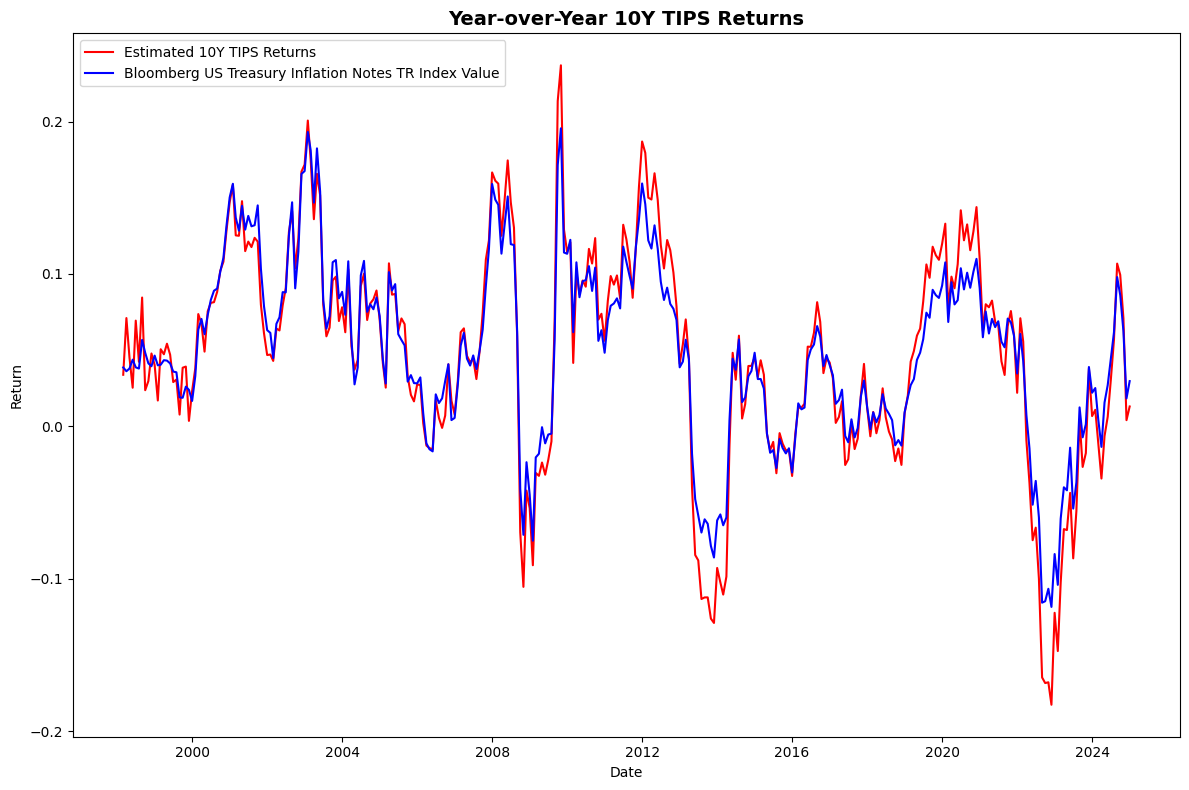

In [51]:
TIPS_returndata = combined_data[["LBUTTRUU_return_index_yoy","combined_tips10y_yoy","tips_10y_return_yoy"]].dropna(thresh=3)
# shiller_10y_compounded['bond10y_return_yoy'].iloc[0] = shiller_10y_compounded['SPBDU1BT Index'].iloc[0]
TIPS_returndata.index = pd.to_datetime(TIPS_returndata.index)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
# Plot 
ax.plot(TIPS_returndata['tips_10y_return_yoy'], label='Estimated 10Y TIPS Returns', color='red')
ax.plot(TIPS_returndata['LBUTTRUU_return_index_yoy'], label='Bloomberg US Treasury Inflation Notes TR Index Value', color='blue')

# Final formatting
ax.set_title('Year-over-Year 10Y TIPS Returns', fontsize=14, weight='bold')
ax.set_ylabel('Return')
ax.set_xlabel('Date')

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()

plt.savefig("TIPS_comparison_yoy.png", bbox_inches='tight', dpi=300)

plt.show()

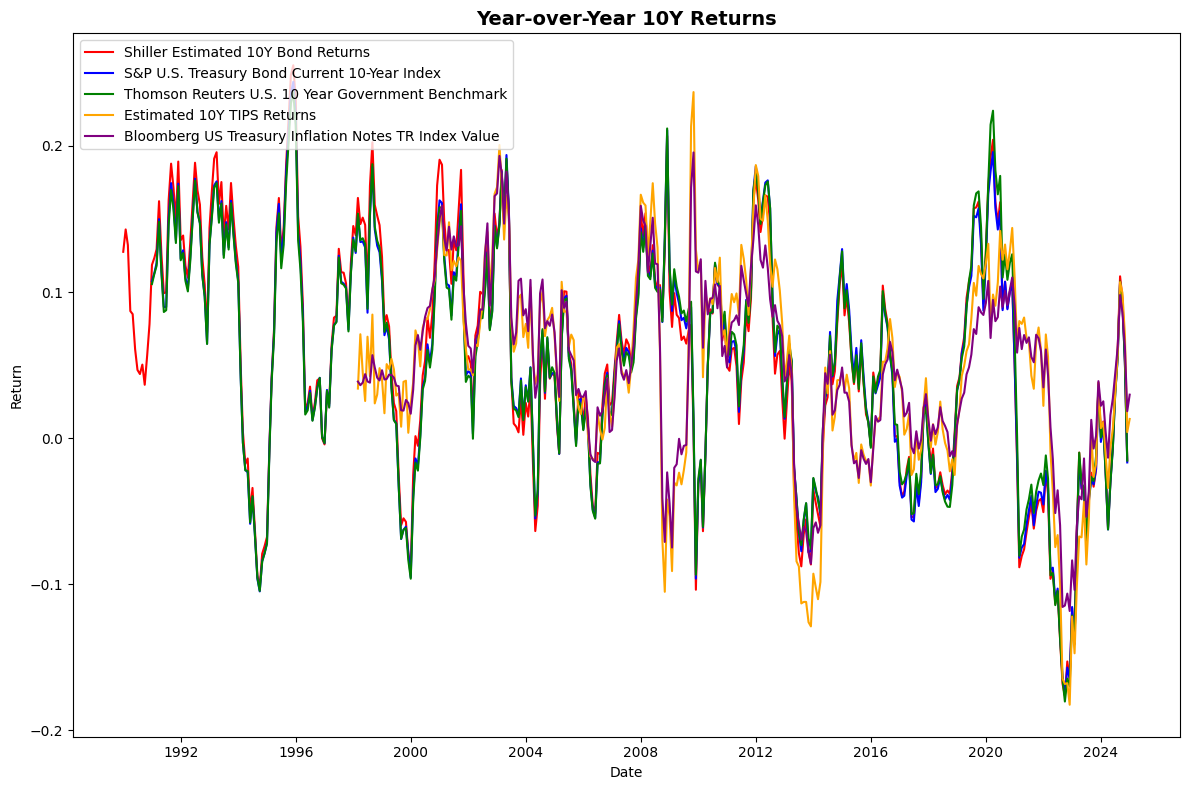

In [46]:

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
# Plot 
ax.plot(shiller_10y_compounded['bond10y_return_yoy'], label='Shiller Estimated 10Y Bond Returns', color='red')
ax.plot(shiller_10y_compounded['SPBDU1BT_yoy'], label='S&P U.S. Treasury Bond Current 10-Year Index', color='blue')
ax.plot(shiller_10y_compounded['TRXVUSGOV10U_yoy'], label='Thomson Reuters U.S. 10 Year Government Benchmark', color='green')
ax.plot(TIPS_returndata['tips_10y_return_yoy'], label='Estimated 10Y TIPS Returns', color='orange')
ax.plot(TIPS_returndata['LBUTTRUU_return_index_yoy'], label='Bloomberg US Treasury Inflation Notes TR Index Value', color='purple')

# Final formatting
ax.set_title('Year-over-Year 10Y Returns', fontsize=14, weight='bold')
ax.set_ylabel('Return')
ax.set_xlabel('Date')

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()

# plt.savefig("bond_tips_comparisons.png", bbox_inches='tight', dpi=300)

plt.show()

<Axes: >

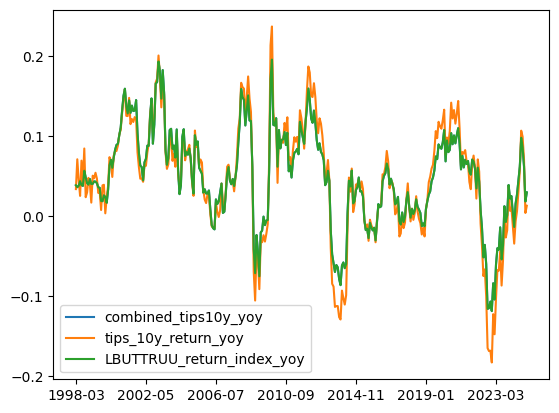

In [14]:
tips_return_index_yoy = ((combined_data["MERG4QI"].pct_change(12))).dropna(how="all")

# return_calc_accuracy = combined_data["tips_10y_return_yoy"].subtract(tips_return_index_yoy)

# print("\nCalculated returns minus actual TIPS returns")
# print(return_calc_accuracy.head)

tips_plot = pd.concat([combined_data["combined_tips10y_yoy"], combined_data["tips_10y_return_yoy"], combined_data['LBUTTRUU_return_index_yoy']], axis=1)
tips_plot.dropna(thresh=3).plot()

<Axes: >

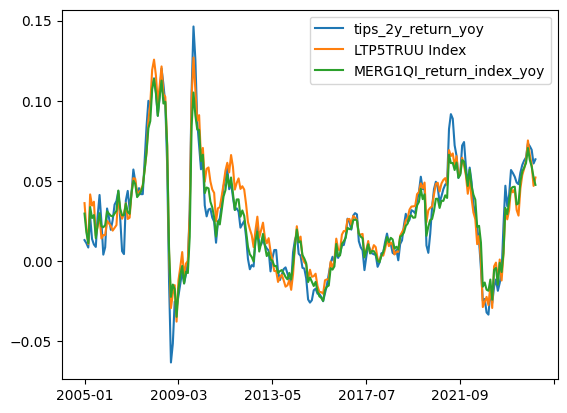

In [15]:
tips_2y_return_index_yoy = ((combined_data["LTP5TRUU Index"].pct_change(12))).dropna(how="all")

tips_plot = pd.concat([combined_data["tips_2y_return_yoy"], tips_2y_return_index_yoy, combined_data['MERG1QI_return_index_yoy']], axis=1)
tips_plot.dropna(thresh=3).plot()

### Compare calculated BEI to USGGBE10. If they are okay, then you can use calculated returns further back than is available for USGGBE10
### Below: BEI excess return compared to swap index

<Axes: >

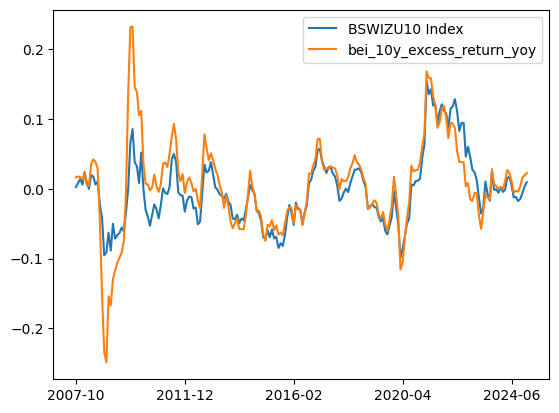

In [16]:
bei02_comparison = combined_data['bei_2y_excess_return_yoy'].subtract(combined_data["BSWIZU02 Index"].pct_change(12))
bei10_comparison = combined_data['bei_10y_excess_return_yoy'].subtract(combined_data["BSWIZU10 Index"].pct_change(12))
bei10_notexcess_comparison = combined_data['bei_10y_return_yoy'].subtract(combined_data["BSWIZU10 Index"].pct_change(12))

# print("BEI 2Y comparison")
# print(bei02_comparison)
# print("\nBEI 10Y comparison")
# print(bei10_comparison)

# bei_plot = pd.concat([combined_data["BSWIZU10 Index"].pct_change(12), combined_data["bei_10y_excess_return_yoy"], bei10_notexcess_comparison], axis=1)
# bei_plot.dropna(thresh=3).plot()

bei_plot = pd.concat([combined_data["BSWIZU10 Index"].pct_change(12), combined_data["bei_10y_excess_return_yoy"]], axis=1)
bei_plot.dropna(thresh=2).plot()

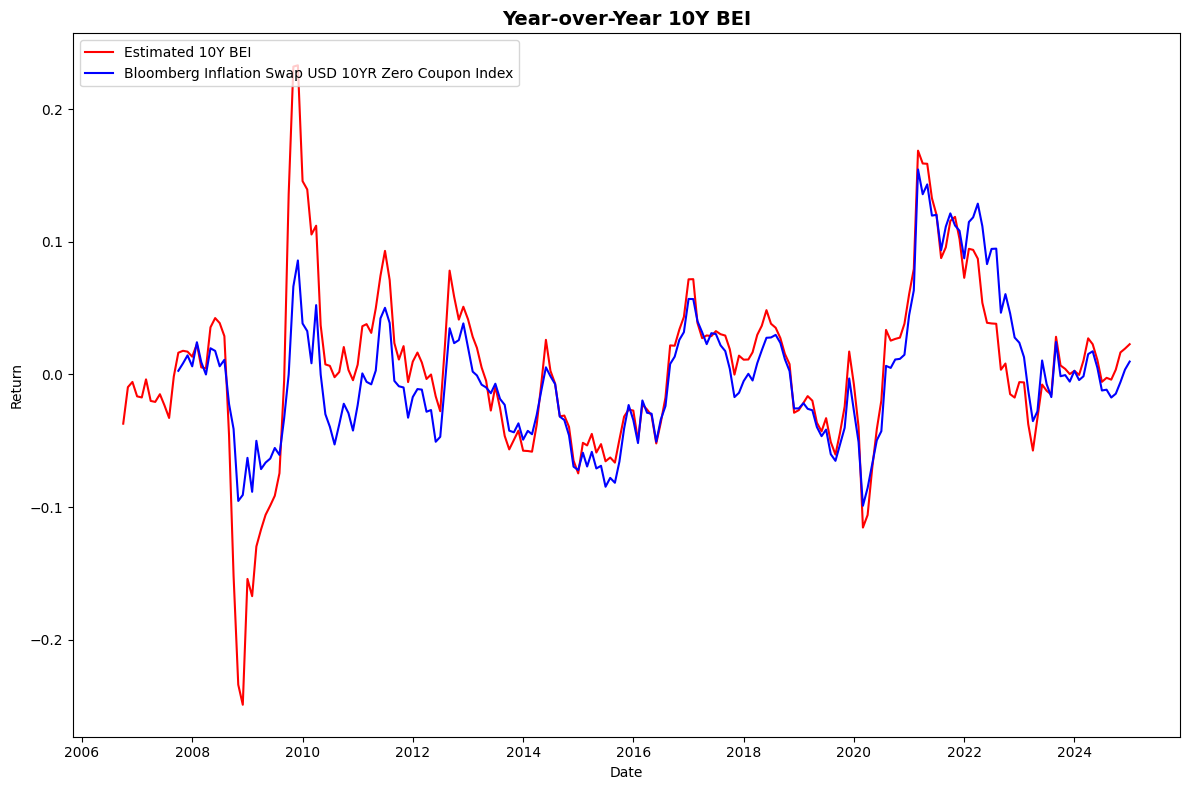

In [17]:
BEI_returndata = combined_data[["bei_10y_excess_return_yoy","BSWIZU10 Index"]].dropna(thresh=2)
# shiller_10y_compounded['bond10y_return_yoy'].iloc[0] = shiller_10y_compounded['SPBDU1BT Index'].iloc[0]
BEI_returndata.index = pd.to_datetime(BEI_returndata.index)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
# Plot 
ax.plot(BEI_returndata["bei_10y_excess_return_yoy"], label='Estimated 10Y BEI', color='red')
ax.plot(BEI_returndata["BSWIZU10 Index"].pct_change(12), label='Bloomberg Inflation Swap USD 10YR Zero Coupon Index', color='blue')

# Final formatting
ax.set_title('Year-over-Year 10Y BEI', fontsize=14, weight='bold')
ax.set_ylabel('Return')
ax.set_xlabel('Date')

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()

plt.savefig("BEI_comparison_yoy.png", bbox_inches='tight', dpi=300)

plt.show()

## Now, we calculate excess returns for assets

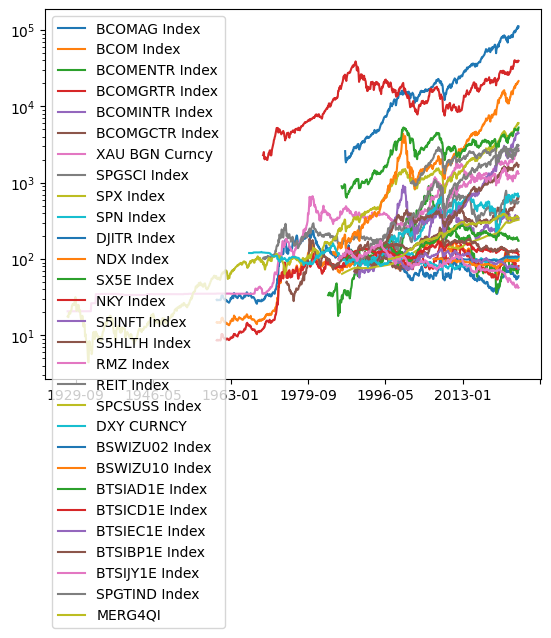

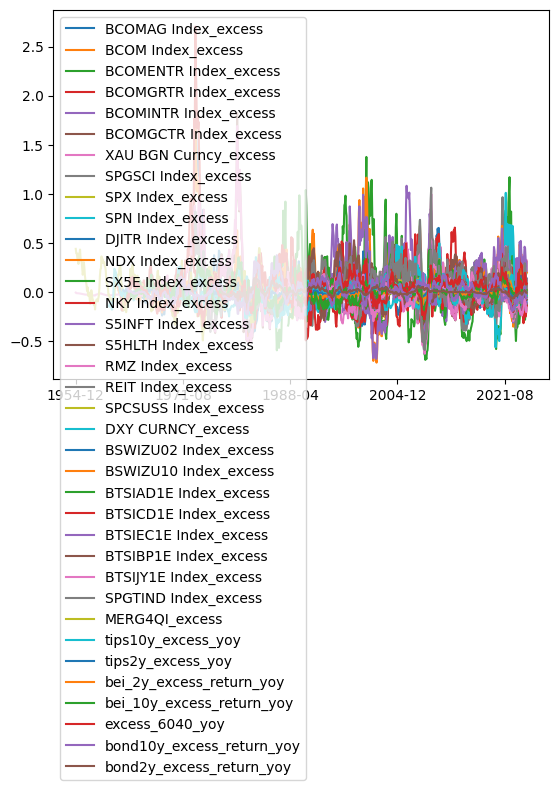

In [18]:
# ----------------------------
# Excess returns for assets
# ----------------------------

# Defined as annual return minus 10Y return
#YoY
selected_columns = ['BCOMAG Index', 'BCOM Index',
       'BCOMENTR Index', 'BCOMGRTR Index', 'BCOMINTR Index', 'BCOMGCTR Index', 'XAU BGN Curncy',
       'SPGSCI Index', 'SPX Index', 'SPN Index', 'DJITR Index', 'NDX Index',
       'SX5E Index', 'NKY Index', 'S5INFT Index', 'S5HLTH Index', 'RMZ Index',
       'REIT Index', 'SPCSUSS Index', 'DXY CURNCY', 'BSWIZU02 Index',
       'BSWIZU10 Index', 'BTSIAD1E Index', 'BTSICD1E Index', 'BTSIEC1E Index',
       'BTSIBP1E Index', 'BTSIJY1E Index', 'SPGTIND Index', 'MERG4QI']

yoy_return_asset = pd.DataFrame()
for column in selected_columns:
    yoy_return_asset[f"{column}_yoy_return"] = combined_data[column].pct_change(12)
yoy_return_asset = yoy_return_asset.join(combined_data[['tips_10y_return_yoy', 'tips_2y_return_yoy', 'bond2y_return_yoy', 'bond10y_return_yoy', 
                                                        'return_6040_yoy', 'bei_2y_return_yoy', 'bei_10y_return_yoy']], how='outer')

excess_return_asset = pd.DataFrame()
for column in selected_columns:
    excess_return_asset[f"{column}_excess"] = combined_data[column].pct_change(12) - combined_data["US3M_approx_yoy"]

excess_return_asset = excess_return_asset.join(combined_data[['tips10y_excess_yoy', 'tips2y_excess_yoy', 'bei_2y_excess_return_yoy', 'bei_10y_excess_return_yoy', 'excess_6040_yoy', 
                                                              'bond10y_excess_return_yoy', 'bond2y_excess_return_yoy']], how='outer')

combined_data[selected_columns].plot(logy=True)

excess_return_asset.dropna(how='all').plot()
excess_return_asset_nomask = excess_return_asset
mask_excess = pd.to_datetime(excess_return_asset.index, format='%Y-%m') < '2021-01-01'
excess_return_asset = excess_return_asset[mask_excess]

In [19]:
# ----------------------------
# Reporting on asset returns
# ----------------------------

# Compute metrics, handling NaN values asset-wise
summary_yoy = pd.DataFrame({
    "Observations": yoy_return_asset.count(),  # Count non-NaN values for each asset
    "Mean Return": yoy_return_asset.mean(skipna=True),  # Ignore NaN in calculations
    "Min Return": yoy_return_asset.min(skipna=True),
    "Max Return": yoy_return_asset.max(skipna=True),
    "Volatility": yoy_return_asset.std(skipna=True),
    "Risk-Adjusted Return": yoy_return_asset.mean(skipna=True) / yoy_return_asset.std(skipna=True),
    "Skewness": yoy_return_asset.apply(lambda x: skew(x.dropna()), axis=0),  # Compute per asset, ignoring NaNs. 
    #Skewness value between -1 and +1 is excellent, while -2 to +2 is generally acceptable
    "Kurtosis": yoy_return_asset.apply(lambda x: kurtosis(x.dropna()), axis=0)  # Compute per asset, ignoring NaNs.
    #Kurtosis greater than +2 suggests a too peaked distribution, while less than -2 indicates a too flat one. 
})

# Compute metrics, handling NaN values asset-wise
summary_excess = pd.DataFrame({
    "Observations": excess_return_asset.count(),  # Count non-NaN values for each asset
    "Mean Excess Return": excess_return_asset.mean(skipna=True),  # Ignore NaN in calculations
    "Min Excess Return": excess_return_asset.min(skipna=True),
    "Max Excess Return": excess_return_asset.max(skipna=True),
    "Volatility": excess_return_asset.std(skipna=True),
    "Sharpe Ratio": excess_return_asset.mean(skipna=True) / excess_return_asset.std(skipna=True),
    "Skewness": excess_return_asset.apply(lambda x: skew(x.dropna()), axis=0),  # Compute per asset, ignoring NaNs. 
    #Skewness value between -1 and +1 is excellent, while -2 to +2 is generally acceptable
    "Kurtosis": excess_return_asset.apply(lambda x: kurtosis(x.dropna()), axis=0)  # Compute per asset, ignoring NaNs.
    #Kurtosis greater than +2 suggests a too peaked distribution, while less than -2 indicates a too flat one. 
})

# Display results
print("Summary of YoY Returns")
print(summary_yoy)
print("Summary of Excess Returns")
print(summary_excess)


excel_filename = "Asset_Returns_Summary.xlsx"
with pd.ExcelWriter(excel_filename, engine="openpyxl") as writer:
    summary_yoy.to_excel(writer, sheet_name="YoY_Returns")
    summary_excess.to_excel(writer, sheet_name="Excess_Returns")

Summary of YoY Returns
                           Observations  Mean Return  Min Return  Max Return  \
BCOMAG Index_yoy_return             770     0.034753   -0.474099    2.010965   
BCOM Index_yoy_return               770     0.050604   -0.508224    1.739975   
BCOMENTR Index_yoy_return           482     0.085996   -0.681173    1.427008   
BCOMGRTR Index_yoy_return           770     0.066158   -0.477499    2.762328   
BCOMINTR Index_yoy_return           398     0.074548   -0.610219    1.123865   
BCOMGCTR Index_yoy_return           590     0.075698   -0.367049    1.927606   
XAU BGN Curncy_yoy_return          1155     0.067545   -0.377129    1.794181   
SPGSCI Index_yoy_return             650     0.055310   -0.505368    0.967963   
SPX Index_yoy_return               1155     0.080572   -0.701281    1.462754   
SPN Index_yoy_return                414     0.084503   -0.543569    1.011761   
DJITR Index_yoy_return              438     0.122834   -0.405804    0.537798   
NDX Index_yoy_ret

# Performance (total returns) during drawdowns, inflation, and deflation

Top Deflation (Drawdown) Periods (Cumulative CPI change):
      start      end  cumulative_inflation
3   1920-06  1921-06             -0.157895
5   1925-11  1927-04             -0.038889
6   1937-05  1938-10             -0.027778
27  2008-07  2009-07             -0.020972
4   1923-09  1924-08             -0.011628
33  2020-01  2020-05             -0.006113
30  2014-05  2015-04             -0.005469
32  2018-07  2019-02              0.003055
17  1986-01  1986-12              0.008212
22  1995-05  1995-12              0.008541
25  2003-03  2004-02              0.010858
26  2005-09  2006-10              0.015091
Top Inflation Buildup Periods (Cumulative CPI change):
      start      end  cumulative_inflation
7   1944-05  1947-03              0.251429
10  1972-06  1974-12              0.244604
8   1946-02  1947-03              0.209945
6   1938-10  1942-05              0.164286
26  2020-05  2022-06              0.155686
0   1918-04  1918-11              0.147887
9   1967-10  1969-12       

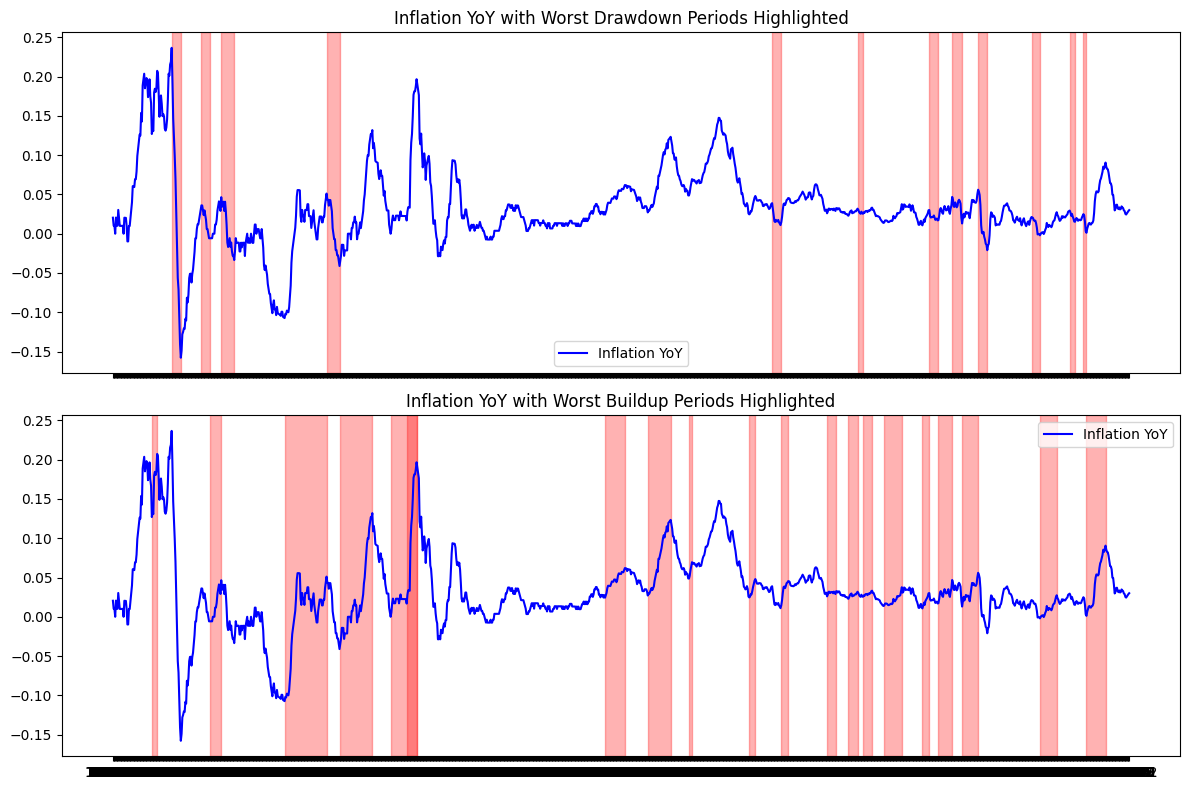

In [20]:
# (Discarded)
# --------------------------------------------------------------------

from scipy.signal import argrelextrema

# Assume combined_data is your DataFrame with 'CPIAUCNS' as the CPI levels.
cpi = combined_data['CPIAUCNS'].dropna()

# Compute the YoY percentage change (this is only used to detect regime turning points)
cpi_yoy = cpi.pct_change(12).dropna()

# Define a window for local extrema detection (tweak this as needed)
window = 12

# Identify local peaks (when YoY inflation is high) and troughs (when it is low)
peak_indices = argrelextrema(cpi_yoy.values, np.greater, order=window)[0]
trough_indices = argrelextrema(cpi_yoy.values, np.less, order=window)[0]

peaks = cpi_yoy.index[peak_indices]
troughs = cpi_yoy.index[trough_indices]

# --- Compute Deflation (Drawdown) Periods ---
# For each detected peak in the YoY series, find the first subsequent trough.
drawdowns = []
for peak in peaks:
    # Find the first trough after this peak (using dates)
    subsequent_troughs = troughs[troughs > peak]
    if len(subsequent_troughs) > 0:
        trough_date = subsequent_troughs[0]
        # Use the underlying CPI levels to compute the cumulative change
        peak_cpi = cpi.loc[peak]
        trough_cpi = cpi.loc[trough_date]
        # This return is comparable to asset returns.
        cumulative_inflation = trough_cpi / peak_cpi - 1
        drawdowns.append({
            'start': peak, 
            'end': trough_date, 
            'cumulative_inflation': cumulative_inflation
        })

drawdown_df = pd.DataFrame(drawdowns)
# Sort so that the worst (lowest cumulative change) appear first.
worst_drawdown_df = drawdown_df.sort_values(by='cumulative_inflation').head(12)

print("Top Deflation (Drawdown) Periods (Cumulative CPI change):")
print(worst_drawdown_df)

# --- Compute Inflation Buildup Periods ---
# For each detected trough, find the first subsequent peak.
buildups = []
for trough in troughs:
    subsequent_peaks = peaks[peaks > trough]
    if len(subsequent_peaks) > 0:
        peak_date = subsequent_peaks[0]
        trough_cpi = cpi.loc[trough]
        peak_cpi = cpi.loc[peak_date]
        cumulative_inflation = peak_cpi / trough_cpi - 1
        buildups.append({
            'start': trough, 
            'end': peak_date, 
            'cumulative_inflation': cumulative_inflation
        })

buildup_df = pd.DataFrame(buildups)
# Sort to get the largest cumulative increases
top_buildup_df = buildup_df.sort_values(by='cumulative_inflation', ascending=False).head(20)

print("Top Inflation Buildup Periods (Cumulative CPI change):")
print(top_buildup_df)


# Visualization
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot top 10 drawdowns as red spans
ax[0].plot(cpi_yoy.index, cpi_yoy, label='Inflation YoY', color='blue')
for i, row in worst_drawdown_df.iterrows():
    ax[0].axvspan(row['start'], row['end'], color='red', alpha=0.3)

ax[0].set_title('Inflation YoY with Worst Drawdown Periods Highlighted')
ax[0].legend()

# Plot top 10 drawdowns as red spans
ax[1].plot(cpi_yoy.index, cpi_yoy, label='Inflation YoY', color='blue')
for i, row in top_buildup_df.iterrows():
    ax[1].axvspan(row['start'], row['end'], color='red', alpha=0.3)

ax[1].set_title('Inflation YoY with Worst Buildup Periods Highlighted')
ax[1].legend()

plt.tight_layout()
plt.show()


In [21]:

price_based_assets = ['CPIAUCNS', 'SPX Index', 'BCOMAG Index', 'BCOM Index', 'BCOMENTR Index', 
       'BCOMGRTR Index', 'BCOMINTR Index', 'XAU BGN Curncy', 'SPGSCI Index', 
       'SPN Index', 'DJITR Index', 'NDX Index', 'SX5E Index', 'NKY Index', 
       'S5INFT Index', 'S5HLTH Index', 'RMZ Index', 'REIT Index', 'SPCSUSS Index', 
       'DXY CURNCY', 'BTSIAD1E Index', 'BTSICD1E Index', 'BTSIEC1E Index', 
       'BTSIBP1E Index', 'BTSIJY1E Index', 'SPGTIND Index']
return_based_assets = ['tips_10y_return', 'tips_2y_return', '2y_returns', 
        '10y_returns', 'return_6040', 'bei_2y_excess_return', 'bei_10y_excess_return']  # These are already returns

def calculate_returns(period_df):
    returns_list = []
    for i, row in period_df.iterrows():
        period_start = row['start']
        period_end = row['end']
        
        period_returns = {'start': period_start, 'end': period_end}
        
        # Price based assets
        for asset in price_based_assets:
            asset_prices = combined_data[asset].dropna().copy()
            asset_prices.index = pd.to_datetime(asset_prices.index)
            start_price = asset_prices.asof(period_start)
            end_price = asset_prices.asof(period_end)
            if pd.notna(start_price) and pd.notna(end_price):
                asset_return = (end_price / start_price) - 1
            else:
                asset_return = None
            period_returns[f'{asset}_return'] = asset_return
        
        # Return based assets
        for asset in return_based_assets:
            asset_returns = combined_data[asset].dropna().copy()
            asset_returns.index = pd.to_datetime(asset_returns.index)
            period_monthly_returns = asset_returns.loc[period_start:period_end]
            if not period_monthly_returns.empty:
                accumulated_return = (np.prod(1 + period_monthly_returns) - 1)
            else:
                accumulated_return = None
            period_returns[f'{asset}_return'] = accumulated_return
        
        returns_list.append(period_returns)
    
    return pd.DataFrame(returns_list)

# Calculate returns for deflation (drawdown) periods and inflation buildup periods
returns_df_deflation = calculate_returns(worst_drawdown_df)
returns_df_inflation = calculate_returns(top_buildup_df)

# Sort the DataFrames by the 'start' date
returns_df_deflation = returns_df_deflation.sort_values(by="start")
returns_df_inflation = returns_df_inflation.sort_values(by="start")

print("Asset returns for the deflation periods:")
print(returns_df_deflation)
print("Asset returns for the inflation buildup periods:")
print(returns_df_inflation)

# --- Save Both DataFrames to an Excel File with Two Sheets ---
# excel_filename = "Asset_Returns_Inflation_Periods.xlsx"
# with pd.ExcelWriter(excel_filename) as writer:
#     returns_df_deflation.to_excel(writer, sheet_name="Deflation", index=False)
#     returns_df_inflation.to_excel(writer, sheet_name="Inflation", index=False)

# print(f"Excel file '{excel_filename}' created with two sheets: 'Deflation' and 'Inflation'.")


Asset returns for the deflation periods:
      start      end  CPIAUCNS_return  SPX Index_return  BCOMAG Index_return  \
0   1920-06  1921-06        -0.157895               NaN                  NaN   
4   1923-09  1924-08        -0.011628               NaN                  NaN   
1   1925-11  1927-04        -0.038889               NaN                  NaN   
2   1937-05  1938-10        -0.027778         -0.190037                  NaN   
8   1986-01  1986-12         0.008212          0.143498            -0.086876   
9   1995-05  1995-12         0.008541          0.154724             0.153113   
10  2003-03  2004-02         0.010858          0.349879             0.269714   
11  2005-09  2006-10         0.015091          0.121361             0.032157   
3   2008-07  2009-07        -0.020972         -0.220849            -0.310938   
6   2014-05  2015-04        -0.005469          0.084187            -0.264443   
7   2018-07  2019-02         0.003055         -0.011291            -0.099140   

## Worst SPX drawdowns

In [22]:
dd_return_plot_data = combined_data[['10y_returns', 'return_6040']]
dd_return_plot_data['SPX Index'] = combined_data['SPX Index'].pct_change(1)
dd_return_plot_data = dd_return_plot_data.dropna(thresh=3)

C:\Users\kons-esm\AppData\Local\Temp\ipykernel_16088\1330159513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_return_plot_data['SPX Index'] = combined_data['SPX Index'].pct_change(1)


Top 10 Worst Drawdown Periods:
       start      end    max_dd
256  2007-10  2009-02 -0.485039
211  2000-08  2003-02 -0.441134
65   1972-10  1974-09 -0.373994
42   1968-09  1970-06 -0.279782
133  1987-06  1987-11 -0.250819
2    1962-01  1962-09 -0.192110
333  2021-12  2022-09 -0.187614
107  1980-07  1982-03 -0.171364
21   1965-12  1966-09 -0.136520
152  1990-05  1990-10 -0.107992


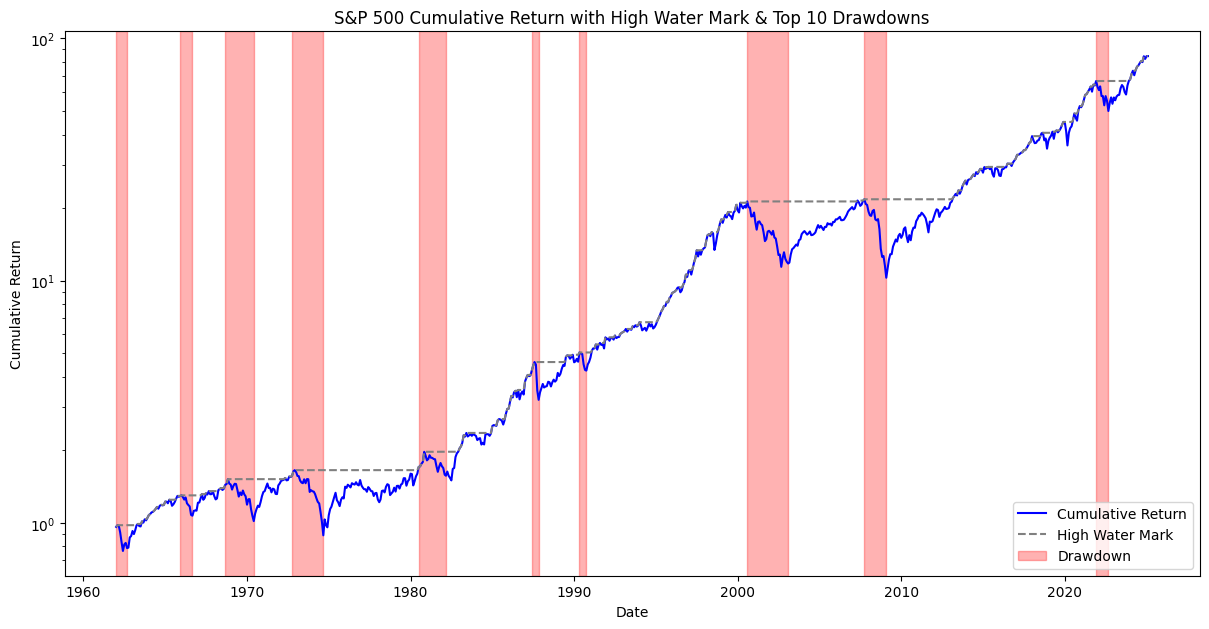

In [23]:
# --------------------------------------------------------------------
# Calculate drawdowns for S&P
# --------------------------------------------------------------------

returns = dd_return_plot_data["SPX Index"]
cum_return = (1 + returns).cumprod()

hwm = cum_return.cummax()
dd = (cum_return-hwm)/hwm

initialised = False
drawdown_list = []
for date in dd.index:
    # print(date)
    if initialised:
        if dd[date] <= last_dd:
            end_date = date
        else:
            drawdown_list.append({'start': start_date, 'end': end_date, 'max_dd': dd[date]})
            initialised = False
    
    if not initialised:
        if dd[date] == 0:
            start_date = date
        end_date = date

    last_dd = dd[date]
    initialised = True

dd_df = pd.DataFrame(drawdown_list)

# Group by 'start' and keep the worst drawdown for each unique period
idx = dd_df.groupby('start')['max_dd'].idxmin()
worst_dd_df = dd_df.loc[idx].sort_values(by='max_dd').head(10)

print("Top 10 Worst Drawdown Periods:")
print(worst_dd_df)

# For each unique start date, take the highest dd
cum_return.index = pd.to_datetime(cum_return.index)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot your data as before
ax.semilogy(cum_return.index, cum_return.values, label='Cumulative Return', color='blue')
ax.semilogy(cum_return.index, hwm.values, label='High Water Mark', linestyle='--', color='gray')

# Example of shading drawdown periods:
for i, row in worst_dd_df.iterrows():
    ax.axvspan(row['start'], row['end'], color='red', alpha=0.3,
               label='Drawdown' if i == worst_dd_df.index[0] else None)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))

plt.tight_layout()

# Final touches
ax.set_title('S&P 500 Cumulative Return with High Water Mark & Top 10 Drawdowns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.show()

# Worst 60/40 drawdowns

Top 10 Worst Drawdown Periods for 60/40:
       start      end    max_dd
256  2007-10  2009-02 -0.485039
211  2000-08  2003-02 -0.441134
65   1972-10  1974-09 -0.373994
42   1968-09  1970-06 -0.279782
133  1987-06  1987-11 -0.250819
2    1962-01  1962-09 -0.192110
333  2021-12  2022-09 -0.187614
107  1980-07  1982-03 -0.171364
21   1965-12  1966-09 -0.136520
152  1990-05  1990-10 -0.107992
190  1998-06  1998-08 -0.103039


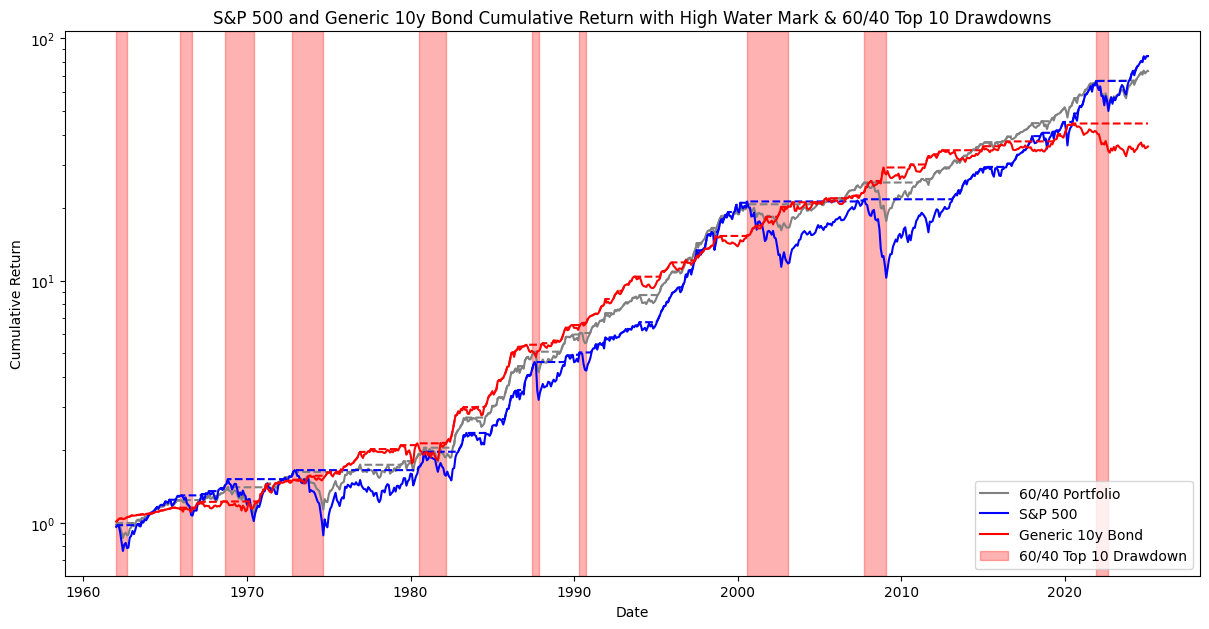

In [24]:
#### 60/40 10 worst drawdowns
cumulative_returns_6040 = (1 + dd_return_plot_data["return_6040"].dropna()).cumprod()
hwm_6040 = cumulative_returns_6040.cummax()
dd_6040 = (cumulative_returns_6040-hwm_6040)/hwm_6040

cumulative_returns_spx = (1 + dd_return_plot_data['SPX Index'].dropna()).cumprod()
hwm_spx = cumulative_returns_spx.cummax()
dd_spx = (cumulative_returns_spx-hwm_spx)/hwm_spx

cumulative_returns_bonds = (1 + dd_return_plot_data['10y_returns'].dropna()).cumprod()
hwm_bonds = cumulative_returns_bonds.cummax()
dd_bonds = (cumulative_returns_bonds-hwm_bonds)/hwm_bonds

initialised = False
drawdown_list_6040 = []
for date in dd.index:
    # print(date)
    if initialised:
        if dd[date] <= last_dd:
            end_date = date
        else:
            drawdown_list_6040.append({'start': start_date, 'end': end_date, 'max_dd': dd[date]})
            initialised = False
    
    if not initialised:
        if dd[date] == 0:
            start_date = date
        end_date = date

    last_dd = dd[date]
    initialised = True

dd_df_6040 = pd.DataFrame(drawdown_list_6040)

# Group by 'start' and keep the worst drawdown for each unique period
idx = dd_df_6040.groupby('start')['max_dd'].idxmin()
worst_dd_df_6040 = dd_df_6040.loc[idx].sort_values(by='max_dd').head(11)

print("Top 10 Worst Drawdown Periods for 60/40:")
print(worst_dd_df_6040)

worst_dd_6040 = [(f'DD{str(i+1).zfill(2)}', start_end[0], start_end[1]) for i, start_end in enumerate(worst_dd_df_6040.itertuples(index=False))]

# For each unique start date, take the highest dd
cumulative_returns_6040.index = pd.to_datetime(cumulative_returns_6040.index)
cumulative_returns_spx.index = pd.to_datetime(cumulative_returns_spx.index)
cumulative_returns_bonds.index = pd.to_datetime(cumulative_returns_bonds.index)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot your data as before
ax.semilogy(cumulative_returns_6040.index, cumulative_returns_6040.values, label='60/40 Portfolio', color='gray')
ax.semilogy(cumulative_returns_6040.index, hwm_6040.values, linestyle='--', color='gray')

ax.semilogy(cumulative_returns_spx.index, cumulative_returns_spx.values, label='S&P 500', color='blue')
ax.semilogy(cumulative_returns_spx.index, hwm_spx.values, linestyle='--', color='blue')

ax.semilogy(cumulative_returns_bonds.index, cumulative_returns_bonds.values, label='Generic 10y Bond', color='red')
ax.semilogy(cumulative_returns_bonds.index, hwm_bonds.values, linestyle='--', color='red')

# Example of shading drawdown periods:
for i, row in worst_dd_df.iterrows():
    ax.axvspan(row['start'], row['end'], color='red', alpha=0.3,
               label='60/40 Top 10 Drawdown' if i == worst_dd_df.index[0] else None)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))

plt.tight_layout()

# Final touches
ax.set_title('S&P 500 and Generic 10y Bond Cumulative Return with High Water Mark & 60/40 Top 10 Drawdowns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.show()

In [25]:
# --------------------------------------------------------------------
# Calculate asset returns in S&P drawdowns
# --------------------------------------------------------------------

# List of assets: differentiate between price-based and return-based assets
price_based_assets = ['SPX Index', 'BCOMAG Index', 'BCOM Index', 'BCOMENTR Index', 
       'BCOMGRTR Index', 'BCOMINTR Index', 'XAU BGN Curncy', 'SPGSCI Index', 
       'SPN Index', 'DJITR Index', 'NDX Index', 'SX5E Index', 'NKY Index', 
       'S5INFT Index', 'S5HLTH Index', 'RMZ Index', 'REIT Index', 'SPCSUSS Index', 
       'DXY CURNCY', 'BTSIAD1E Index', 'BTSICD1E Index', 'BTSIEC1E Index', 
       'BTSIBP1E Index', 'BTSIJY1E Index', 'SPGTIND Index']
return_based_assets = ['tips_10y_return', 'tips_2y_return', '2y_returns', 
        '10y_returns', 'return_6040', 'bei_2y_excess_return', 'bei_10y_excess_return']  # These are already returns

returns_list = []

# Loop over each drawdown period in worst_dd_df.
for i, row in worst_dd_df.iterrows():
    period_start = row['start']
    period_end = row['end']
    
    period_returns = {'start': period_start, 'end': period_end}
    
    for asset in price_based_assets:
        asset_prices = combined_data[asset].dropna().copy()
        asset_prices.index = pd.to_datetime(asset_prices.index)  # Ensure datetime index
        
        # Get last available price on or before the start and end dates
        start_price = asset_prices.asof(period_start)
        end_price = asset_prices.asof(period_end)
        
        # Calculate total return
        if pd.notna(start_price) and pd.notna(end_price):
            asset_return = (end_price / start_price) - 1
        else:
            asset_return = None  # Handle missing data gracefully
        
        period_returns[f'{asset}_return'] = asset_return
    
    for asset in return_based_assets:
        asset_returns = combined_data[asset].dropna().copy()
        asset_returns.index = pd.to_datetime(asset_returns.index)  # Ensure datetime index
        
        # Filter returns within the period
        period_monthly_returns = asset_returns.loc[period_start:period_end]
        
        if not period_monthly_returns.empty:
            # Convert percentage returns (if necessary) and compound them: (1 + r1) * (1 + r2) * ... - 1
            accumulated_return = (np.prod(1 + period_monthly_returns) - 1)
        else:
            accumulated_return = None  # Handle missing data
        
        period_returns[f'{asset}_return'] = accumulated_return
    
    returns_list.append(period_returns)

returns_df = pd.DataFrame(returns_list)
returns_df = returns_df.sort_values(by="start")

print("Asset returns for the worst drawdown periods:")
print(returns_df)

# Save to Excel
excel_filename = "Asset_Returns_SPXDrawdowns.xlsx"
returns_df.to_excel(excel_filename, index=False)

Asset returns for the worst drawdown periods:
     start      end  SPX Index_return  BCOMAG Index_return  BCOM Index_return  \
5  1962-01  1962-09         -0.182597            -0.051035          -0.051034   
8  1965-12  1966-09         -0.171698             0.053001           0.036837   
3  1968-09  1970-06         -0.291711             0.227721           0.253396   
2  1972-10  1974-09         -0.430543             3.330731           2.525992   
7  1980-07  1982-03         -0.079806            -0.362772          -0.401854   
4  1987-06  1987-11         -0.242434             0.030350           0.005352   
9  1990-05  1990-10         -0.158431            -0.116451           0.188958   
1  2000-08  2003-02         -0.445766            -0.085945           0.132719   
0  2007-10  2009-02         -0.525559            -0.278106          -0.422485   
6  2021-12  2022-09         -0.247695             0.116757           0.124225   

   BCOMENTR Index_return  BCOMGRTR Index_return  BCOMINTR Inde

Asset returns for the worst inflationary periods:
                               Regime       start         end  \
0                          End of WW2     1946-03     1947-03   
1       Recession of 1949 (deflation)     1948-07     1949-07   
10                           Period 1  1962-01-01  1982-12-31   
2                End of Bretton Woods     1966-02     1970-01   
3                    OPEC Oil Embargo     1972-07     1974-12   
4                  Iranian Revolution     1977-02     1980-03   
5   Early 1980s Recession (deflation)     1980-04     1983-01   
11                           Period 2  1983-01-01  2001-12-31   
6                       Reagan's Boom     1987-02     1990-11   
12                           Period 3  2002-01-01  2020-12-31   
7                   China Demand Boom     2007-09     2008-07   
8        Financial Crisis (deflation)     2008-07     2009-07   
9                            Covid-19     2020-05     2021-12   
13                           Period 4  2

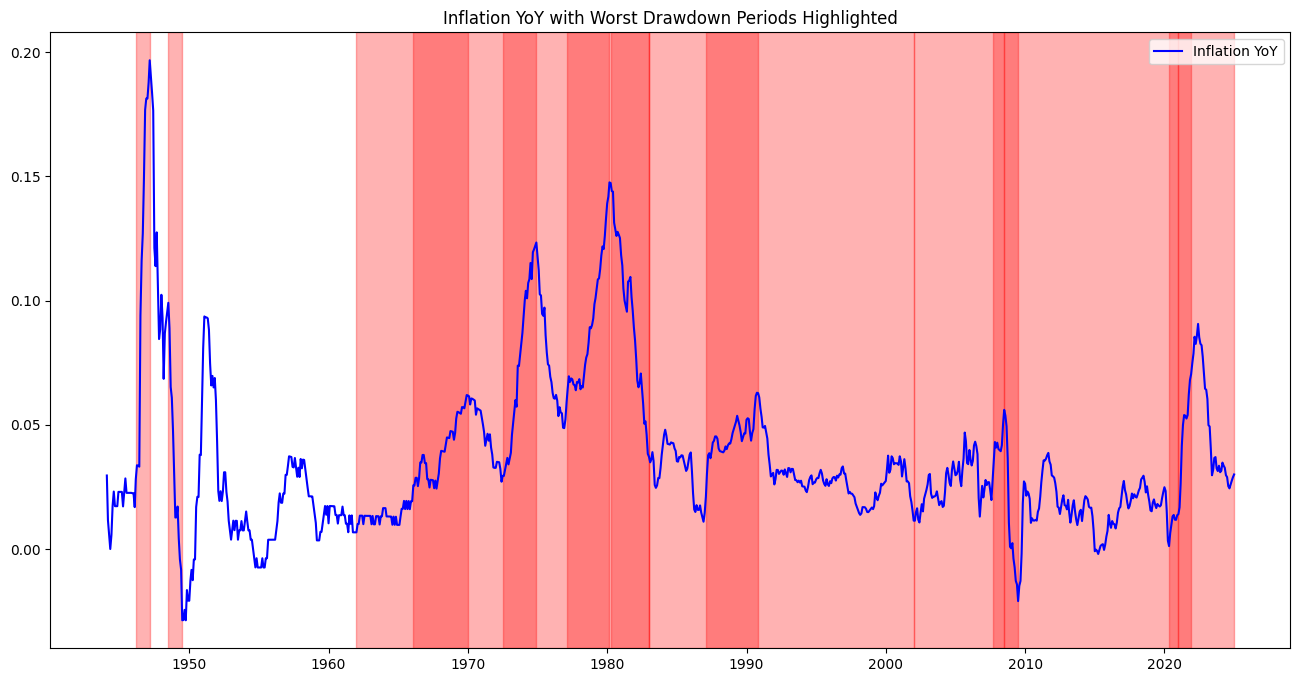

In [26]:
# --------------------------------------------------------------------
# Asset returns in inflationary and deflationary periods
# --------------------------------------------------------------------

# Define inflation regimes properly as a DataFrame
inflation_regimes = [
    ("End of WW2", "1946-03", "1947-03"),
    ("Recession of 1949 (deflation)", "1948-07", "1949-07"),
    ("End of Bretton Woods", "1966-02", "1970-01"),
    ("OPEC Oil Embargo", "1972-07", "1974-12"), 
    ("Iranian Revolution", "1977-02", "1980-03"),
    ("Early 1980s Recession (deflation)", "1980-04", "1983-01"), 
    ("Reagan's Boom", "1987-02", "1990-11"),
    ("China Demand Boom", "2007-09", "2008-07"),
    ("Financial Crisis (deflation)", "2008-07", "2009-07"),
    ("Covid-19", "2020-05", "2021-12"),
    ("Period 1", "1962-01-01", "1982-12-31"),
    ("Period 2", "1983-01-01", "2001-12-31"),
    ("Period 3", "2002-01-01", "2020-12-31"),
    ("Period 4", "2021-01-01", "2024-12-31")   
]

price_based_assets = ['CPIAUCNS', 'SPX Index', 'BCOMAG Index', 'BCOM Index', 'BCOMENTR Index', 
       'BCOMGRTR Index', 'BCOMINTR Index', 'XAU BGN Curncy', 'SPGSCI Index', 
       'SPN Index', 'DJITR Index', 'NDX Index', 'SX5E Index', 'NKY Index', 
       'S5INFT Index', 'S5HLTH Index', 'RMZ Index', 'REIT Index', 'SPCSUSS Index', 
       'DXY CURNCY', 'BTSIAD1E Index', 'BTSICD1E Index', 'BTSIEC1E Index', 
       'BTSIBP1E Index', 'BTSIJY1E Index', 'SPGTIND Index']
return_based_assets = ['tips_10y_return', 'tips_2y_return', '2y_returns', 
        '10y_returns', 'return_6040', 'bei_2y_excess_return', 'bei_10y_excess_return']  # These are already returns


infl_regimes_df = pd.DataFrame(inflation_regimes, columns=["Regime", "start", "end"])

infl_returns_list = []

# Loop over each inflation regime
for i, row in infl_regimes_df.iterrows():
    period_start = row['start']
    period_end = row['end']
    
    period_returns = {'Regime': row['Regime'], 'start': period_start, 'end': period_end}
    
    for asset in price_based_assets:
        asset_prices = combined_data[asset].dropna().copy()
        asset_prices.index = pd.to_datetime(asset_prices.index)  # Ensure datetime index
        
        # Get last available price on or before the start and end dates
        start_price = asset_prices.asof(period_start)
        end_price = asset_prices.asof(period_end)
        
        # Calculate total return
        if pd.notna(start_price) and pd.notna(end_price):
            asset_return = (end_price / start_price) - 1
        else:
            asset_return = None  # Handle missing data gracefully
        
        period_returns[f'{asset}_return'] = asset_return
    
    for asset in return_based_assets:
        asset_returns = combined_data[asset].dropna().copy()
        asset_returns.index = pd.to_datetime(asset_returns.index)  # Ensure datetime index
        
        # Filter returns within the period
        period_monthly_returns = asset_returns.loc[period_start:period_end]
        
        if not period_monthly_returns.empty:
            # Compound monthly returns over the period
            accumulated_return = (np.prod(1 + period_monthly_returns) - 1)
        else:
            accumulated_return = None  # Handle missing data
        
        period_returns[f'{asset}_return'] = accumulated_return
    
    infl_returns_list.append(period_returns)

returns_df = pd.DataFrame(infl_returns_list)

# Sort by start date
returns_df = returns_df.sort_values(by="start")

print("Asset returns for the worst inflationary periods:")
print(returns_df)

# Save to Excel
excel_filename = "Asset_Returns_Inflation.xlsx"
returns_df.to_excel(excel_filename, index=False)

print(f"Saved to {excel_filename}")


cpi_yoy = combined_data['YoYCPI'].dropna()
mask_cpi = pd.to_datetime(cpi_yoy.index, format='%Y-%m') > '1944-01-01'
cpi_yoy = cpi_yoy[mask_cpi]
cpi_yoy.index = pd.to_datetime(cpi_yoy.index)
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True)

# Plot top 10 drawdowns as red spans
ax.plot(cpi_yoy.index, cpi_yoy, label='Inflation YoY', color='blue')
for i, row in returns_df.iterrows():
    ax.axvspan(row['start'], row['end'], color='red', alpha=0.3)


ax.set_title('Inflation YoY with Worst Drawdown Periods Highlighted')
ax.legend()

plt.show()


## Now, define unexpected inflation

### Unexpected:

1913-01         NaN
1913-02         NaN
1913-03         NaN
1913-04         NaN
1913-05         NaN
             ...   
2024-10    0.027696
2024-11    0.027912
2024-12    0.030917
2025-01    0.024186
2025-02         NaN
Name: 1y_expected_FED, Length: 1346, dtype: float64


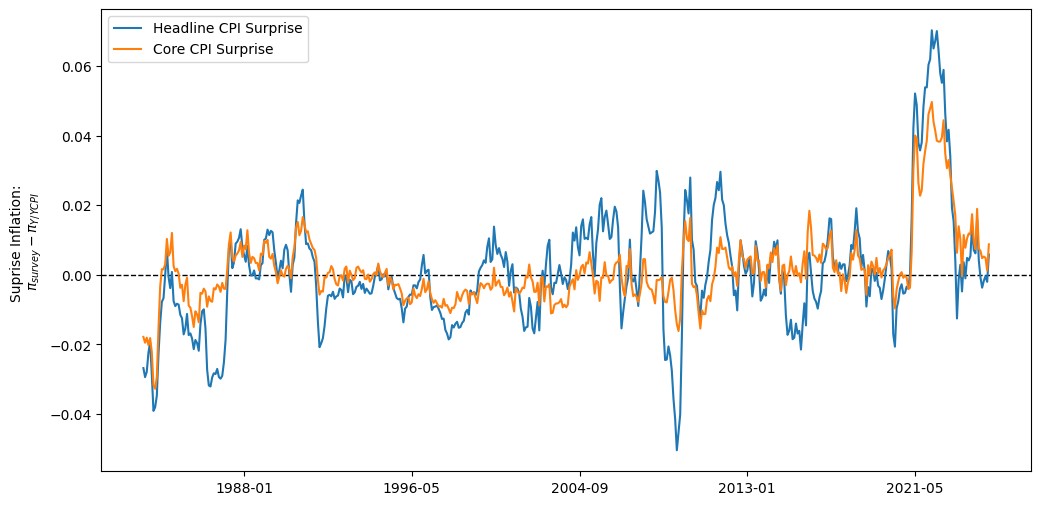

In [27]:
combined_data["surprise_CPI"] = combined_data["YoYCPI"] - combined_data["1y_expected_FED"]
combined_data["surprise_CPI_core"] = combined_data["YoYCoreCPI"] - combined_data["1y_expected_FED"]
print(combined_data["1y_expected_FED"])

fig, axs = plt.subplots(1, 1, figsize=(12, 6))
axs.axhline(0, color='black', linestyle='--', linewidth=1)
axs.set_ylabel("Suprise Inflation: \n$\pi_{survey}-\pi_{Y/Y CPI}$")
combined_data["surprise_CPI"].plot(ax=axs, label="Headline CPI Surprise")
combined_data["surprise_CPI_core"].plot(ax=axs, label="Core CPI Surprise")
axs.legend()

Date
1959-01         NaN
1959-02         NaN
1959-03         NaN
1959-04         NaN
1959-05         NaN
             ...   
2024-08    0.028637
2024-09    0.028032
2024-10    0.025919
2024-11    0.027429
2024-12         NaN
Name: Survey_PCE, Length: 792, dtype: float64


<Axes: ylabel='Suprise Inflation: \n$\\pi_{survey}-\\pi_{Y/Y PCE}$'>

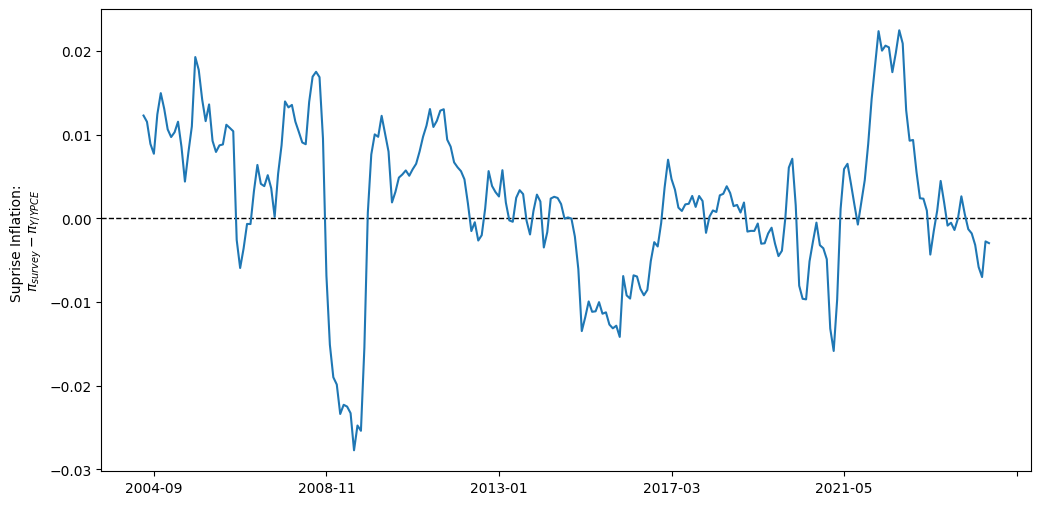

In [28]:
combined_data["suprise_PCE"] = PCE_data["YoYPCE"] - PCE_data["Survey_PCE"]
print(PCE_data["Survey_PCE"])

fig, axs = plt.subplots(1, 1, figsize=(12, 6))
axs.axhline(0, color='black', linestyle='--', linewidth=1)
axs.set_ylabel("Suprise Inflation: \n$\pi_{survey}-\pi_{Y/Y PCE}$")
combined_data["suprise_PCE"].plot()

# Then: if the difference between forecasts for year 2024 (in 2023) and realized inflation in 2024 is larger than 2 %, then that can be defined as unexpected inflation.
# Remember to use first release figures after 2002

## Correlations

In [29]:
# ----------------------------
# Correlations between asset returns and inflation
# ----------------------------

def compute_asset_inflation_correlations(inflation_names, excess_return_asset, combined_data, 
                                           shift_period=1, significance_level=0.05):
    corr_results = []
    
    for infl_name in inflation_names:
        # Create a shifted inflation series for the specified measure.
        inflation_series = combined_data[infl_name].shift(shift_period).copy()
        
        for asset in excess_return_asset.columns:
            # Align the asset's returns with the shifted inflation series.
            asset_returns = excess_return_asset[asset].dropna()
            data = pd.concat([inflation_series, asset_returns], axis=1, join='inner').dropna(thresh=2)
            
            if data.shape[0] > 0:
                r_val, p_val = pearsonr(data[infl_name], data[asset])
            else:
                r_val, p_val = np.nan, np.nan
                
            corr_results.append({
                "Asset": asset,
                "Inflation Measure": infl_name,
                "Pearson_r": r_val,
                "p_value": p_val,
                "Significance": "Significant" if p_val < significance_level else "Insignificant"
            })
    
    # Create a DataFrame from the results.
    results_df = pd.DataFrame(corr_results)
    
    # Round the Pearson correlation and p_value columns.
    results_df["Pearson_r"] = results_df["Pearson_r"]
    results_df["p_value"] = results_df["p_value"]
    
    return results_df

# Specify the list of inflation measures you want to analyze.
inflation_measures = ["YoYCPI", "YoYCoreCPI", "YoYEnergyCPI", "surprise_CPI"]

# Compute the correlations.
correlations_df = compute_asset_inflation_correlations(inflation_measures, excess_return_asset, combined_data)

# Pivot tables
pivot_r = correlations_df.pivot(index="Inflation Measure", columns="Asset", values="Pearson_r")
pivot_p = correlations_df.pivot(index="Inflation Measure", columns="Asset", values="p_value")
pivot_signif = correlations_df.pivot(index="Inflation Measure", columns="Asset", values="Significance")

# Tables with correlation, p-value, significance
# pivot_r.index = pd.MultiIndex.from_product([pivot_r.index, ["Correlation"]])
# pivot_p.index = pd.MultiIndex.from_product([pivot_p.index, ["p-value"]])
# pivot_signif.index = pd.MultiIndex.from_product([pivot_signif.index, ["Significance"]])

# Concatenate
combined_metrics = pd.concat([pivot_r, pivot_p, pivot_signif]).sort_index(level=0)

# Print the combined table.
print("Asset-Inflation Correlations:")
print(combined_metrics)

# Save to Excel
excel_filename = "Asset_Inflation_Correlations.xlsx"
combined_metrics.to_excel(excel_filename)
print(f"Combined table has been saved to {excel_filename}")


Asset-Inflation Correlations:
Asset             BCOM Index_excess BCOMAG Index_excess BCOMENTR Index_excess  \
Inflation Measure                                                               
YoYCPI                     0.270962            0.149439              0.554122   
YoYCPI                          0.0            0.000057                   0.0   
YoYCPI                  Significant         Significant           Significant   
YoYCoreCPI                 0.021523           -0.042248              0.182826   
YoYCoreCPI                 0.564224            0.257568              0.000133   
YoYCoreCPI            Insignificant       Insignificant           Significant   
YoYEnergyCPI               0.477594            0.232868              0.598528   
YoYEnergyCPI                    0.0                 0.0                   0.0   
YoYEnergyCPI            Significant         Significant           Significant   
surprise_CPI               0.504722            0.187513                0.4573  

In [30]:
# ----------------------------
# Asset returns correlations
# ----------------------------
 
# List of asset names
assets = excess_return_asset.columns.tolist()
n_assets = len(assets)

# Initialize empty DataFrames for the correlation matrix and the corresponding p-values
corr_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)
pval_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)

# Loop through each pair of assets
for i in range(n_assets):
    for j in range(i, n_assets):
        asset1 = assets[i]
        asset2 = assets[j]
        
        # Align the two series
        data_pair = pd.concat([excess_return_asset[asset1], excess_return_asset[asset2]], axis=1, join='inner').dropna()
        if data_pair.shape[0] > 0:
            corr, p_value = pearsonr(data_pair.iloc[:, 0].values.astype(float),
                                     data_pair.iloc[:, 1].values.astype(float))
        else:
            corr, p_value = np.nan, np.nan
        
        # Fill both the upper and lower triangles
        corr_matrix.loc[asset1, asset2] = corr
        corr_matrix.loc[asset2, asset1] = corr
        pval_matrix.loc[asset1, asset2] = p_value
        pval_matrix.loc[asset2, asset1] = p_value

print("Correlation matrix between all assets:")
print(corr_matrix)

print("P-value matrix for asset correlations:")
print(pval_matrix)

excel_corr_filename = "Asset_Correlation_Matrix.xlsx"
with pd.ExcelWriter(excel_corr_filename, engine='openpyxl') as writer:
    corr_matrix.to_excel(writer, sheet_name="Correlations")
    pval_matrix.to_excel(writer, sheet_name="P-values")

print(f"\nCorrelation matrices have been saved to {excel_corr_filename}")

Correlation matrix between all assets:
                           BCOMAG Index_excess  BCOM Index_excess  \
BCOMAG Index_excess                   1.000000           0.851388   
BCOM Index_excess                     0.851388           1.000000   
BCOMENTR Index_excess                 0.068601           0.732182   
BCOMGRTR Index_excess                 0.944984           0.802219   
BCOMINTR Index_excess                 0.287670           0.584288   
BCOMGCTR Index_excess                 0.332817           0.576493   
XAU BGN Curncy_excess                 0.489480           0.621923   
SPGSCI Index_excess                   0.560785           0.782455   
SPX Index_excess                     -0.072839          -0.018280   
SPN Index_excess                      0.391269           0.631586   
DJITR Index_excess                    0.233675           0.284128   
NDX Index_excess                      0.014291           0.120510   
SX5E Index_excess                     0.005550           0.16879

## Regressions

In [31]:
# ----------------------------
# Regression for multiple inflation measures
# ----------------------------

linreg_dict = dict()
results_list = []

inflation_measures = ["YoYCPI", "YoYCoreCPI", "YoYEnergyCPI", "surprise_CPI"] 

assets_reg = excess_return_asset.columns.to_list()

for infl in inflation_measures:
    infl_series = combined_data[infl].shift(1)

    for asset in assets_reg:
        regression_data = pd.DataFrame({
            'inflation': infl_series,
            asset: excess_return_asset[asset]
        }).dropna(thresh=2)

        # Define dependent and independent variables
        X = sm.add_constant(regression_data['inflation'])  # Add intercept
        Y = regression_data[asset]

        # Fit OLS regression with Newey-West standard errors
        model = sm.OLS(Y, X)
        results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})  # maxlags = number of months in annualization

        print(f"===== {asset} ~ {infl} =====")
        print(results.summary())

        param_infl = results.params['inflation']
        # statsmodels uses a two-sided p-value for the t- (or z-) statistic
        pval_infl = results.pvalues['inflation']

        significance = "Significant" if norm.cdf(results.tvalues[1]) > 0.95 or norm.cdf(results.tvalues[1]) < 0.05 else "Insignificant"

         # Also get intercept if you like
        intercept_val = results.params['const']
        intercept_pval = results.pvalues['const']

        # Store the result in a list
        results_list.append({
            "Asset": asset,
            "Inflation_Measure": infl,
            "Intercept": intercept_val,
            "Intercept_p": intercept_pval,
            "Inflation_Coef": param_infl,
            "Inflation_p": pval_infl,
            "Significance": significance,
            "N_Obs": int(results.nobs),        # number of observations
            "R_squared": results.rsquared,    # R-squared
            "Adj_R_squared": results.rsquared_adj
        })

        # # print(asset, norm.cdf(results.tvalues[1]))
        # if norm.cdf(results.tvalues[1]) > 0.95 or norm.cdf(results.tvalues[1]) < 0.05:
        #     linreg_dict.update({asset:
        #                         results.params
        #                         # 'stats': results.tvalues
        #                         })

# Convert the list of dicts to a DataFrame
results_df = pd.DataFrame(results_list)

# Example: Sort by asset name, then inflation measure
results_df.sort_values(by=["Asset", "Inflation_Measure"], inplace=True)

# Print the final table
print("\nFinal Regression Results (one row per asset-inflation model):")
print(results_df)

# Save to Excel
results_df.to_excel("Asset_Inflation_Regressions.xlsx", index=False)
print("Saved results to Asset_Inflation_Regressions.xlsx")

# pd.DataFrame.from_dict(linreg_dict)

===== BCOMAG Index_excess ~ YoYCPI =====
                             OLS Regression Results                            
Dep. Variable:     BCOMAG Index_excess   R-squared:                       0.022
Model:                             OLS   Adj. R-squared:                  0.021
Method:                  Least Squares   F-statistic:                     1.014
Date:                 Wed, 07 May 2025   Prob (F-statistic):              0.314
Time:                         11:29:36   Log-Likelihood:                -31.159
No. Observations:                  720   AIC:                             66.32
Df Residuals:                      718   BIC:                             75.48
Df Model:                            1                                         
Covariance Type:                   HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

## Different periods

In [32]:
inflation_data = combined_data[["YoYCPI", "YoYCoreCPI", "YoYEnergyCPI","surprise_CPI"]].copy().shift(1)
print(pd.DataFrame.corr(inflation_data))
asset_data = excess_return_asset_nomask.copy()  # columns for each asset

# Date intervals 
four_periods = [
    ("1962-01-01", "1982-12-31"),
    ("1983-01-01", "2006-12-31"),
    ("2007-01-01", "2020-12-31"),
    ("2021-01-01", "2024-12-31")
]

# Ensure the indices are datetime
inflation_data.index = pd.to_datetime(inflation_data.index)
asset_data.index = pd.to_datetime(asset_data.index)

# Merge the two DataFrames (outer join to preserve all dates)
full_data = inflation_data.join(asset_data, how="outer")

# Prepare Excel Writer
excel_filename = "Asset_Regression_Periods_2007split.xlsx"
writer = pd.ExcelWriter(excel_filename, engine="openpyxl")

# Loop over each date interval
for start_date, end_date in four_periods:
    period_name = f"{start_date} to {end_date}"
    print(f"\nProcessing period: {period_name}")
    
    # Subset data for the period; drop rows only if all values are missing
    period_data = full_data.loc[start_date:end_date].dropna(how="all")
    if period_data.empty:
        print(f"No data available for {period_name}. Skipping...")
        continue
    
    # Determine available inflation measures and assets in this period:
    available_inflation = [col for col in inflation_data.columns if col in period_data.columns and period_data[col].notnull().sum() > 0]
    available_assets = [col for col in asset_data.columns if col in period_data.columns and period_data[col].notnull().sum() > 0]
    
    if not available_assets:
        print(f"No valid asset data in {period_name}. Skipping...")
        continue

    print(f"Available Inflation Measures: {available_inflation}")
    print(f"Available Assets: {available_assets}")

    # --- Inflation Correlations ---
    corr_list = []
    for infl_a in available_inflation:
        for infl_b in available_inflation:
            if infl_a == infl_b:
                continue
            subset = period_data[[infl_a, infl_b]].dropna()
            if subset.shape[0] > 0:
                r, p = pearsonr(subset[infl_a], subset[infl_b])
                sig = "Significant" if p < 0.05 else "Not Significant"
            else:
                r, p, sig = np.nan, np.nan, "N/A"
            corr_list.append({
                "Inflation Measure A": infl_a,
                "Inflation Measure B": infl_b,
                "Correlation": round(r, 6),
                "p-value": f"{p:.6g}",
                "Significance": sig
            })
    corr_infl_df = pd.DataFrame(corr_list)
    
    # --- Asset-Asset Correlation Matrix ---
    asset_corr = period_data[available_assets].corr().round(6)


    # --- Asset-Inflation Correlations ---
    corr_list = []
    for infl in available_inflation:
        for asset in available_assets:
            subset = period_data[[infl, asset]].dropna()
            if subset.shape[0] > 0:
                r, p = pearsonr(subset[infl], subset[asset])
                sig = "Significant" if p < 0.05 else "Not Significant"
            else:
                r, p, sig = np.nan, np.nan, "N/A"
            corr_list.append({
                "Inflation Measure": infl,
                "Asset": asset,
                "Correlation": round(r, 6),
                "p-value": f"{p:.6g}",
                "Significance": sig
            })
    corr_df = pd.DataFrame(corr_list)
    
    # --- Asset-Asset Correlation Matrix ---
    asset_corr = period_data[available_assets].corr().round(6)
    
    # --- Regressions ---
    # We'll run separate regressions: for each inflation measure and asset, regress Asset on Inflation.
    reg_results = []
    for infl in available_inflation:
        for asset in available_assets:
            # Prepare design matrix X (add constant) and dependent variable Y
            subset = period_data[[infl, asset]].dropna()
            if subset.empty:
                continue
            X = sm.add_constant(subset[infl])
            Y = subset[asset]
            try:
                model = sm.OLS(Y, X).fit()
                n_obs = int(model.nobs)
                r_sq = round(model.rsquared, 6)
                adj_r_sq = round(model.rsquared_adj, 6)
                intercept_val = round(model.params["const"], 6)
                intercept_p = f"{model.pvalues['const']:.6g}"
                coef_val = round(model.params[infl], 6)
                coef_p = model.pvalues[infl]
                sig = "Significant" if coef_p < 0.05 else "Not Significant"
                coef_p_formatted = f"{coef_p:.6g}"
                
                reg_results.append({
                    "Asset": asset,
                    "Inflation_Measure": infl,
                    "Intercept": intercept_val,
                    "Intercept_p": intercept_p,
                    "Inflation_Coef": coef_val,
                    "Inflation_p": coef_p_formatted,
                    "Significance": sig,
                    "N_Obs": n_obs,
                    "R_squared": r_sq,
                    "Adj_R_squared": adj_r_sq
                })
            except Exception as e:
                reg_results.append({
                    "Asset": asset,
                    "Inflation_Measure": infl,
                    "Error": str(e)
                })
    reg_df = pd.DataFrame(reg_results)
    
    # # --- Overall Returns ---
    # overall_returns = {}
    # for asset in available_assets:
    #     series = period_data[asset].dropna()
    #     if len(series) > 0:
    #         overall_ret = (series.iloc[-1] / series.iloc[0]) - 1
    #         overall_returns[asset] = round(overall_ret, 6)
    #     else:
    #         overall_returns[asset] = np.nan
    # overall_returns_df = pd.DataFrame([overall_returns])
    # overall_returns_df.insert(0, "Measure", "Overall_Return")
    # overall_returns_df.set_index("Measure", inplace=True)

    # Compute return characteristics
    asset_characteristics = []
    
    for asset in available_assets:
        series = period_data[asset].dropna()

        if series.empty:
            continue

        mean_return = series.mean()
        std_dev = series.std()
        sharpe_ratio = mean_return / std_dev if std_dev != 0 else np.nan
        min_return = series.min()
        max_return = series.max()

        asset_characteristics.append({
            "Asset": asset,
            "Mean Excess Return": mean_return,
            "Standard Deviation": std_dev,
            "Sharpe Ratio": sharpe_ratio,
            "Min Return": min_return,
            "Max Return": max_return
        })

    asset_char_df = pd.DataFrame(asset_characteristics)
    
    # --- Save all outputs to Excel: Each period gets its own sheet ---
    startrow = 0
    sheet_name = period_name[:30]
    corr_infl_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    startrow += len(corr_infl_df) + 3
    corr_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    startrow += len(corr_df) + 3
    asset_corr.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
    startrow += len(asset_corr.index) + 3
    reg_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    startrow += len(reg_df.index) + 3
    asset_char_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    # overall_returns_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
    
    print(f"Results for {period_name} saved to sheet '{sheet_name}'.")

writer.close()
print(f"\nAll period results saved in '{excel_filename}'")


                YoYCPI  YoYCoreCPI  YoYEnergyCPI  surprise_CPI
YoYCPI        1.000000    0.926164      0.695549      0.737377
YoYCoreCPI    0.926164    1.000000      0.432726      0.265703
YoYEnergyCPI  0.695549    0.432726      1.000000      0.808433
surprise_CPI  0.737377    0.265703      0.808433      1.000000

Processing period: 1962-01-01 to 1982-12-31
Available Inflation Measures: ['YoYCPI', 'YoYCoreCPI', 'YoYEnergyCPI']
Available Assets: ['BCOMAG Index_excess', 'BCOM Index_excess', 'BCOMGRTR Index_excess', 'BCOMGCTR Index_excess', 'XAU BGN Curncy_excess', 'SPGSCI Index_excess', 'SPX Index_excess', 'NKY Index_excess', 'DXY CURNCY_excess', 'tips10y_excess_yoy', 'tips2y_excess_yoy', 'bei_2y_excess_return_yoy', 'bei_10y_excess_return_yoy', 'excess_6040_yoy', 'bond10y_excess_return_yoy', 'bond2y_excess_return_yoy']
Results for 1962-01-01 to 1982-12-31 saved to sheet '1962-01-01 to 1982-12-31'.

Processing period: 1983-01-01 to 2006-12-31
Available Inflation Measures: ['YoYCPI', 'YoYC

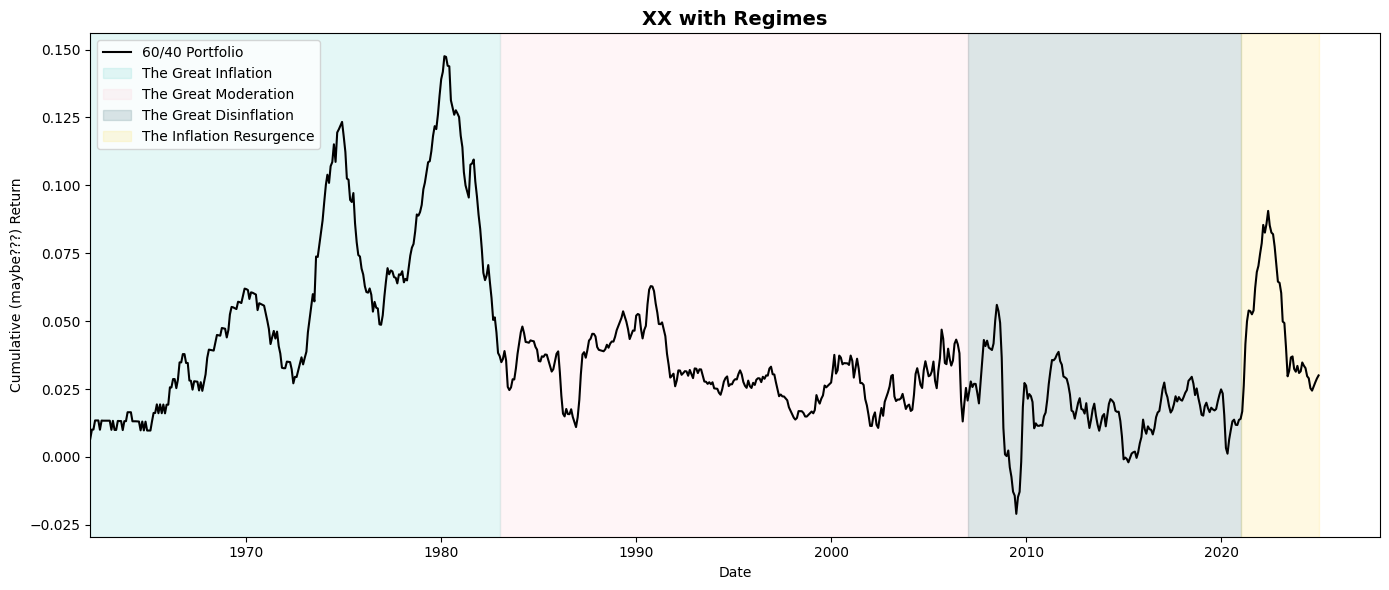

In [33]:
# Date intervals 
# Define periods with names and colors
four_periods = [
    ("The Great Inflation", "1962-01-01", "1982-12-31", '#4ECDC4'),
    ("The Great Moderation", "1983-01-01", "2006-12-31", 'pink'),
    ("The Great Disinflation", "2007-01-01", "2020-12-31", '#1A535C'),
    ("The Inflation Resurgence", "2021-01-01", "2024-12-31", '#FFD93D')
]

# # Compute cumulative return for 60/40
# returns_6040 = (combined_data['return_6040'] + 1).cumprod()
# returns_6040.index = pd.to_datetime(returns_6040.index)

# Compute cumulative return for 60/40
returns_6040 = (combined_data['YoYCPI'])
returns_6040.index = pd.to_datetime(returns_6040.index)

# Filter data to start from 1962
returns_6040 = returns_6040[returns_6040.index >= "1962-01-01"]

# Set x-axis limits
start_date = pd.to_datetime("1962-01-01")
end_date = pd.to_datetime(returns_6040.index.max())

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
# Plot your data as before
# ax.semilogy(returns_6040.index, returns_6040.values, label='Cumulative 60/40 Return', color='blue')
ax.plot(returns_6040, label='60/40 Portfolio', color='black')

# Overlay the periods with their own colors
for label, start, end, color in four_periods:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    if end < start_date or start > end_date:
        continue
    ax.axvspan(max(start, start_date), min(end, end_date), color=color, alpha=0.15, label=label)


# # Add drawdown overlays
# for i, (_, start, end) in enumerate(worst_dd_6040):
#     start = pd.to_datetime(start)
#     end = pd.to_datetime(end)
#     if end < start_date or start > end_date:
#         continue
#     ax.axvspan(max(start, start_date), min(end, end_date), color='pink', alpha=0.8)


# Final formatting
ax.set_xlim(left=start_date)
ax.set_title('XX with Regimes', fontsize=14, weight='bold')
ax.set_ylabel('Cumulative (maybe???) Return')
ax.set_xlabel('Date')

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()

# Optional: Save figure
# plt.savefig("6040_drawdowns_infl.png", bbox_inches='tight', dpi=300)

plt.show()


In [34]:
### For inflationary periods
inflation_data = combined_data[["YoYCPI", "YoYCoreCPI", "YoYEnergyCPI","surprise_CPI"]].copy().shift(1)
asset_data = excess_return_asset_nomask.copy()  # columns for each asset

# Date intervals 
date_intervals = [
    ("End of WW2", "1946-03", "1947-03"),
    ("Recession of 1949 (deflation)", "1948-07", "1949-07"),
    ("End of Bretton Woods", "1966-02", "1970-01"),
    ("OPEC Oil Embargo", "1972-07", "1974-12"), 
    ("Iranian Revolution", "1977-02", "1980-03"),
    ("Early 1980s Recession (deflation)", "1980-04", "1983-01"), 
    ("Reagan's Boom", "1987-02", "1990-11"),
    ("Dot Com Bubble (Burst)", "2000-08", "2003-01"),
    ("China Demand Boom", "2007-09", "2008-07"),
    ("Financial Crisis (deflation)", "2008-07", "2009-07"),
    ("Covid-19", "2021-03", "2022-06")
]

# Ensure the indices are datetime
inflation_data.index = pd.to_datetime(inflation_data.index)
asset_data.index = pd.to_datetime(asset_data.index)

# Merge the two DataFrames (outer join to preserve all dates)
full_data = inflation_data.join(asset_data, how="outer")

# Prepare Excel Writer
excel_filename = "Asset_Regression_InflationPeriods.xlsx"
writer = pd.ExcelWriter(excel_filename, engine="openpyxl")

# Loop over each date interval
for name, start_date, end_date in date_intervals:
    period_name = f"{name} {start_date} to {end_date}"
    print(f"\nProcessing period: {period_name}")
    
    # Subset data for the period; drop rows only if all values are missing
    period_data = full_data.loc[start_date:end_date].dropna(how="all")
    if period_data.empty:
        print(f"No data available for {period_name}. Skipping...")
        continue
    
    # Determine available inflation measures and assets in this period:
    available_inflation = [col for col in inflation_data.columns if col in period_data.columns and period_data[col].notnull().sum() > 0]
    available_assets = [col for col in asset_data.columns if col in period_data.columns and period_data[col].notnull().sum() > 0]
    
    if not available_assets:
        print(f"No valid asset data in {period_name}. Skipping...")
        continue

    print(f"Available Inflation Measures: {available_inflation}")
    print(f"Available Assets: {available_assets}")
    
    # --- Asset-Inflation Correlations ---
    corr_list = []
    for infl in available_inflation:
        for asset in available_assets:
            subset = period_data[[infl, asset]].dropna()
            if subset.shape[0] > 0:
                r, p = pearsonr(subset[infl], subset[asset])
                sig = "Significant" if p < 0.05 else "Not Significant"
            else:
                r, p, sig = np.nan, np.nan, "N/A"
            corr_list.append({
                "Inflation Measure": infl,
                "Asset": asset,
                "Correlation": round(r, 6),
                "p-value": f"{p:.6g}",
                "Significance": sig
            })
    corr_df = pd.DataFrame(corr_list)
    
    # --- Asset-Asset Correlation Matrix ---
    asset_corr = period_data[available_assets].corr().round(6)
    
    # --- Regressions ---
    # We'll run separate regressions: for each inflation measure and asset, regress Asset on Inflation.
    reg_results = []
    for infl in available_inflation:
        for asset in available_assets:
            # Prepare design matrix X (add constant) and dependent variable Y
            subset = period_data[[infl, asset]].dropna()
            if subset.empty:
                continue
            X = sm.add_constant(subset[infl])
            Y = subset[asset]
            try:
                model = sm.OLS(Y, X).fit()
                n_obs = int(model.nobs)
                r_sq = round(model.rsquared, 6)
                adj_r_sq = round(model.rsquared_adj, 6)
                intercept_val = round(model.params["const"], 6)
                intercept_p = f"{model.pvalues['const']:.6g}"
                coef_val = round(model.params[infl], 6)
                coef_p = model.pvalues[infl]
                sig = "Significant" if coef_p < 0.05 else "Not Significant"
                coef_p_formatted = f"{coef_p:.6g}"
                
                reg_results.append({
                    "Asset": asset,
                    "Inflation_Measure": infl,
                    "Intercept": intercept_val,
                    "Intercept_p": intercept_p,
                    "Inflation_Coef": coef_val,
                    "Inflation_p": coef_p_formatted,
                    "Significance": sig,
                    "N_Obs": n_obs,
                    "R_squared": r_sq,
                    "Adj_R_squared": adj_r_sq
                })
            except Exception as e:
                reg_results.append({
                    "Asset": asset,
                    "Inflation_Measure": infl,
                    "Error": str(e)
                })
    reg_df = pd.DataFrame(reg_results)
    
    # # --- Overall Returns ---
    # overall_returns = {}
    # for asset in available_assets:
    #     series = period_data[asset].dropna()
    #     if len(series) > 0:
    #         overall_ret = (series.iloc[-1] / series.iloc[0]) - 1
    #         overall_returns[asset] = round(overall_ret, 6)
    #     else:
    #         overall_returns[asset] = np.nan
    # overall_returns_df = pd.DataFrame([overall_returns])
    # overall_returns_df.insert(0, "Measure", "Overall_Return")
    # overall_returns_df.set_index("Measure", inplace=True)

    # Compute return characteristics
    asset_characteristics = []
    
    for asset in available_assets:
        series = period_data[asset].dropna()

        if series.empty:
            continue

        mean_return = series.mean()
        std_dev = series.std()
        sharpe_ratio = mean_return / std_dev if std_dev != 0 else np.nan
        min_return = series.min()
        max_return = series.max()

        asset_characteristics.append({
            "Asset": asset,
            "Mean Excess Return": mean_return,
            "Standard Deviation": std_dev,
            "Sharpe Ratio": sharpe_ratio,
            "Min Return": min_return,
            "Max Return": max_return
        })

    asset_char_df = pd.DataFrame(asset_characteristics)
    
    # --- Save all outputs to Excel: Each period gets its own sheet ---
    startrow = 0
    sheet_name = period_name[:30]
    corr_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    startrow += len(corr_df) + 3
    asset_corr.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
    startrow += len(asset_corr.index) + 3
    reg_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    startrow += len(reg_df.index) + 3
    asset_char_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False)
    # overall_returns_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
    
    print(f"Results for {period_name} saved to sheet '{sheet_name}'.")

writer.close()
print(f"\nAll period results saved in '{excel_filename}'")


Processing period: End of WW2 1946-03 to 1947-03
No valid asset data in End of WW2 1946-03 to 1947-03. Skipping...

Processing period: Recession of 1949 (deflation) 1948-07 to 1949-07
No valid asset data in Recession of 1949 (deflation) 1948-07 to 1949-07. Skipping...

Processing period: End of Bretton Woods 1966-02 to 1970-01
Available Inflation Measures: ['YoYCPI', 'YoYCoreCPI', 'YoYEnergyCPI']
Available Assets: ['BCOMAG Index_excess', 'BCOM Index_excess', 'BCOMGRTR Index_excess', 'XAU BGN Curncy_excess', 'SPX Index_excess', 'DXY CURNCY_excess', 'tips10y_excess_yoy', 'tips2y_excess_yoy', 'bei_10y_excess_return_yoy', 'excess_6040_yoy', 'bond10y_excess_return_yoy']
Results for End of Bretton Woods 1966-02 to 1970-01 saved to sheet 'End of Bretton Woods 1966-02 t'.

Processing period: OPEC Oil Embargo 1972-07 to 1974-12
Available Inflation Measures: ['YoYCPI', 'YoYCoreCPI', 'YoYEnergyCPI']
Available Assets: ['BCOMAG Index_excess', 'BCOM Index_excess', 'BCOMGRTR Index_excess', 'XAU BGN 

# VAR time for impulse responses

### Log returns

<class 'pandas.core.frame.DataFrame'>
Index: 1295 entries, 1913-02 to 2020-12
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BCOM Index_log_return      731 non-null    float64
 1   CPIAUCNS_log_return        1295 non-null   float64
 2   XAU BGN Curncy_log_return  1116 non-null   float64
 3   SPX Index_log_return       1116 non-null   float64
 4   SX5E Index_log_return      408 non-null    float64
 5   SPCSUSS Index_log_return   407 non-null    float64
 6   DXY CURNCY_log_return      647 non-null    float64
 7   SPGTIND Index_log_return   229 non-null    float64
 8   2y_returns_log             534 non-null    float64
 9   10y_returns_log            708 non-null    float64
 10  tips_10y_return_log        742 non-null    float64
 11  tips_2y_return_log         715 non-null    float64
 12  combined_tips10y_log       742 non-null    float64
 13  combined_tips2y_log        715 non-null    f

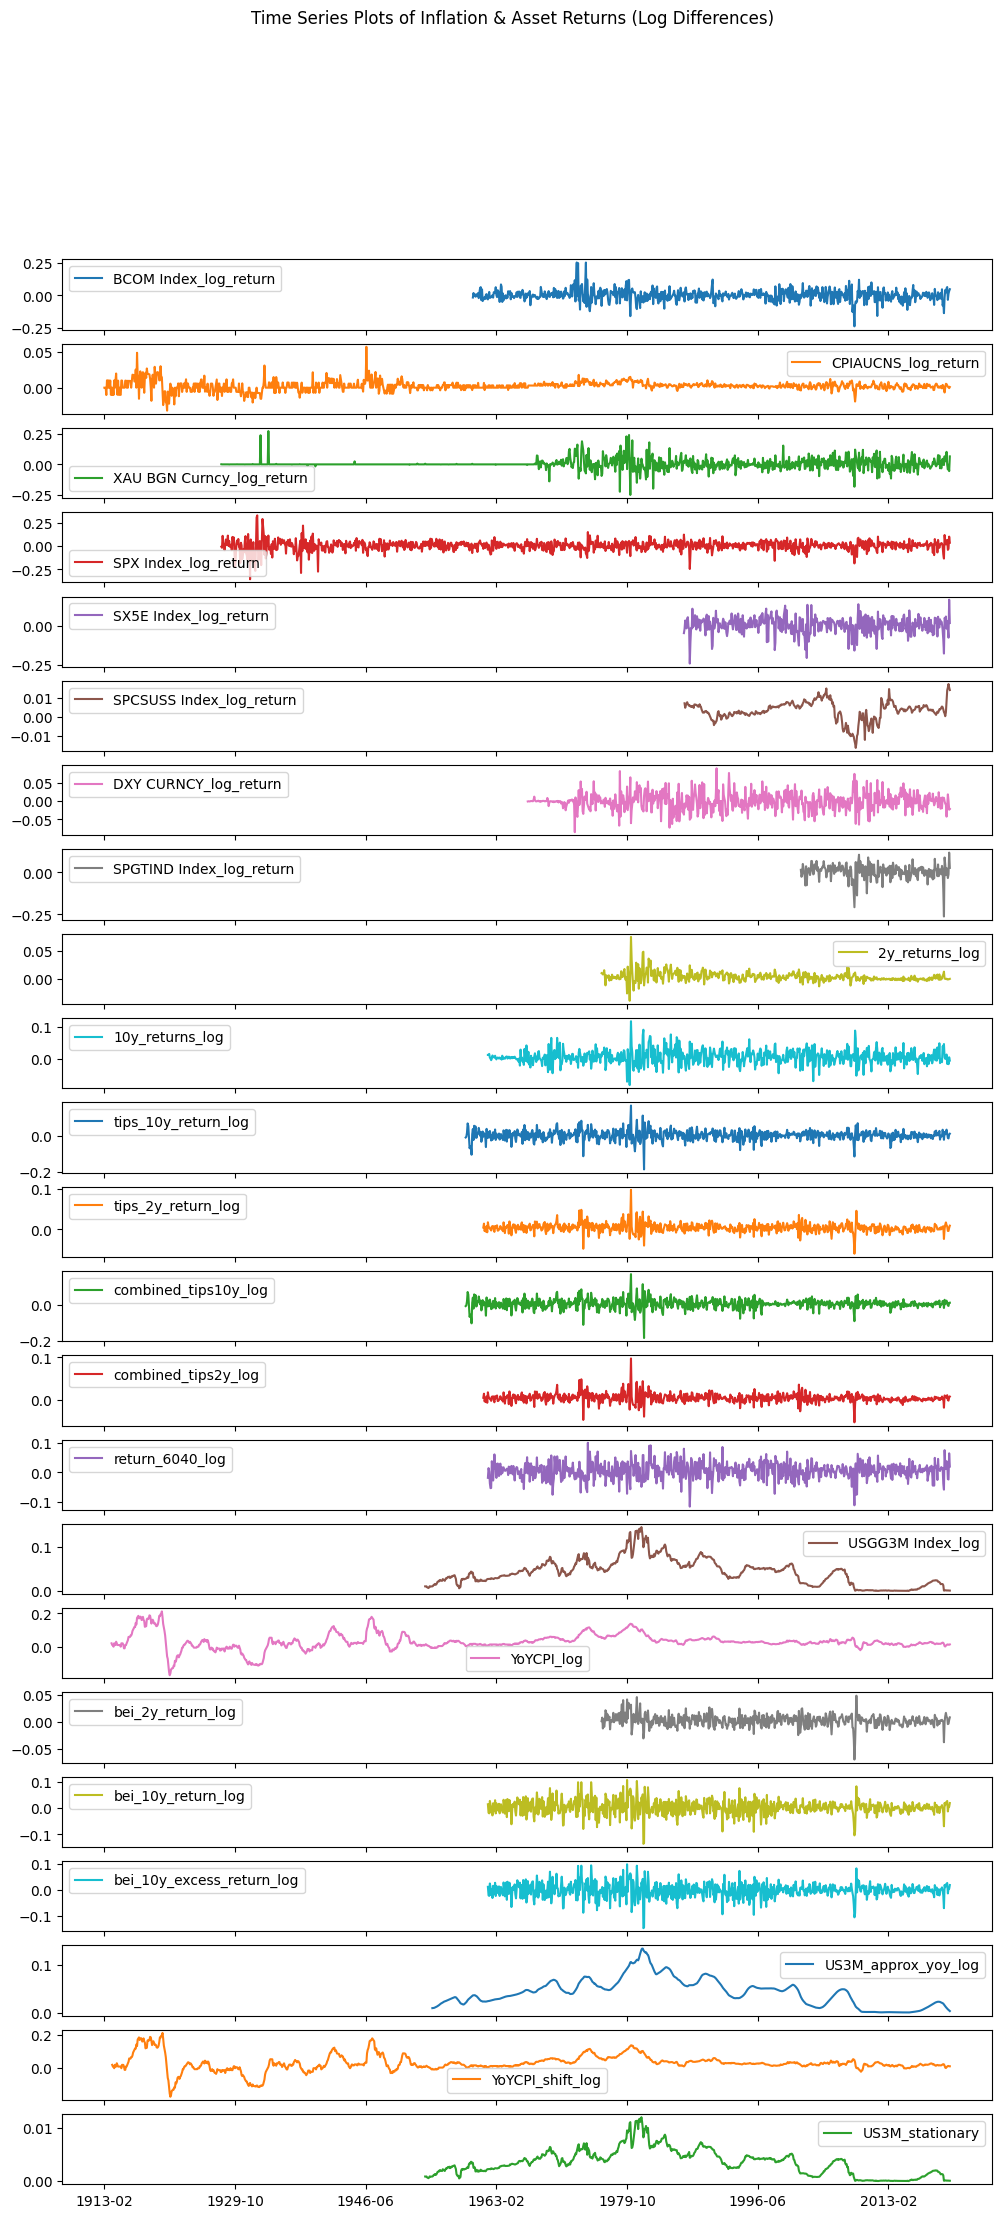

In [35]:
# ----------------------------
# M/M
# ----------------------------

selected_columns = ['BCOM Index', 'CPIAUCNS', 'XAU BGN Curncy', 'SPX Index',
       'SX5E Index', 'SPCSUSS Index', 'DXY CURNCY', 'SPGTIND Index']

log_return_asset = pd.DataFrame()
for column in selected_columns:
    log_return_asset[f"{column}_log_return"] = np.log(1+combined_data[column].pct_change())


bond_cols = ['2y_returns', '10y_returns', 'tips_10y_return', 'tips_2y_return', 'combined_tips10y', 'combined_tips2y', 'return_6040', 'USGG3M Index', 'YoYCPI', 'bei_2y_return', 'bei_10y_return', 'bei_10y_excess_return', 'US3M_approx_yoy']
for col in bond_cols:
    log_return_asset[f"{col}_log"] = np.log(1+combined_data[col])


infl_shift_cols = ['YoYCPI']
for col in infl_shift_cols:
    log_return_asset[f"{col}_shift_log"] = np.log(1+inflation_data[col])


nolog_cols = ['US3M_approx']
for col in nolog_cols:
    # log_return_asset[f"US3M_stationary"] = np.log(1+(combined_data["US3M_approx"]).diff())
    log_return_asset[f"US3M_stationary"] = np.log(1+(combined_data["US3M_approx"]))

# log_return_asset = log_return_asset.diff()
log_return_asset = log_return_asset.dropna(how='all')
mask = pd.to_datetime(log_return_asset.index, format='%Y-%m') < '2021-01-01'
log_return_asset = log_return_asset[mask]

# Inspect missing values and summary stats
print(log_return_asset.info())
print(log_return_asset.describe())

def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NaNs for valid test
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1] < 0.05  # Stationary if p-value < 0.05

# Check stationarity for each variable
for col in log_return_asset.columns:
    print(f"\nChecking stationarity for: {col}")
    is_stationary = check_stationarity(log_return_asset[col])
    if not is_stationary:
        print(f"{col} is NOT stationary, differencing is needed!")


# Plot time series (each subplot will show the log differences)
log_return_asset.plot(subplots=True, figsize=(12, 25))
plt.suptitle("Time Series Plots of Inflation & Asset Returns (Log Differences)")
plt.show()

In [36]:
# Check stationarity for each variable
stationarity_before = ['BCOM Index', 'CPIAUCNS', 'XAU BGN Curncy', 'SPX Index',
       'SX5E Index', 'SPCSUSS Index', 'DXY CURNCY', 'SPGTIND Index']

returns_stationary = pd.DataFrame()
for column in stationarity_before:
    returns_stationary[f"{column}_return"] = combined_data[column].pct_change()

returns_stationary = returns_stationary.join(combined_data[['2y_returns', '10y_returns', 'tips_10y_return', 'tips_2y_return', 'combined_tips10y', 'combined_tips2y', 
                                                'return_6040', 'USGG3M Index', 'YoYCPI', 'bei_2y_return', 'bei_10y_return']], how='outer')

for col in returns_stationary.columns:
    print(f"\nChecking stationarity for: {col}")
    is_stationary = check_stationarity(returns_stationary[col])
    if not is_stationary:
        print(f"{col} is NOT stationary, differencing is needed!")


Checking stationarity for: BCOM Index_return
ADF Statistic: -17.2376, p-value: 0.0000

Checking stationarity for: CPIAUCNS_return
ADF Statistic: -4.8466, p-value: 0.0000

Checking stationarity for: XAU BGN Curncy_return
ADF Statistic: -6.6117, p-value: 0.0000

Checking stationarity for: SPX Index_return
ADF Statistic: -8.7982, p-value: 0.0000

Checking stationarity for: SX5E Index_return
ADF Statistic: -19.7219, p-value: 0.0000

Checking stationarity for: SPCSUSS Index_return
ADF Statistic: -2.8739, p-value: 0.0485

Checking stationarity for: DXY CURNCY_return
ADF Statistic: -25.3478, p-value: 0.0000

Checking stationarity for: SPGTIND Index_return
ADF Statistic: -8.8003, p-value: 0.0000

Checking stationarity for: 2y_returns
ADF Statistic: -3.1904, p-value: 0.0205

Checking stationarity for: 10y_returns
ADF Statistic: -19.5668, p-value: 0.0000

Checking stationarity for: tips_10y_return
ADF Statistic: -6.5656, p-value: 0.0000

Checking stationarity for: tips_2y_return
ADF Statistic: 

<class 'pandas.core.frame.DataFrame'>
Index: 708 entries, 1962-01 to 2020-12
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   US3M_stationary        708 non-null    float64
 1   10y_returns_log        708 non-null    float64
 2   tips_10y_return_log    708 non-null    float64
 3   bei_10y_return_log     708 non-null    float64
 4   SPX Index_log_return   708 non-null    float64
 5   return_6040_log        708 non-null    float64
 6   BCOM Index_log_return  708 non-null    float64
 7   YoYCPI_log             708 non-null    float64
dtypes: float64(8)
memory usage: 49.8+ KB
None
       US3M_stationary  10y_returns_log  tips_10y_return_log  \
count       708.000000       708.000000           708.000000   
mean          0.003687         0.005313             0.005245   
std           0.002546         0.022421             0.027119   
min          -0.000017        -0.083461            -0.184148   
25% 

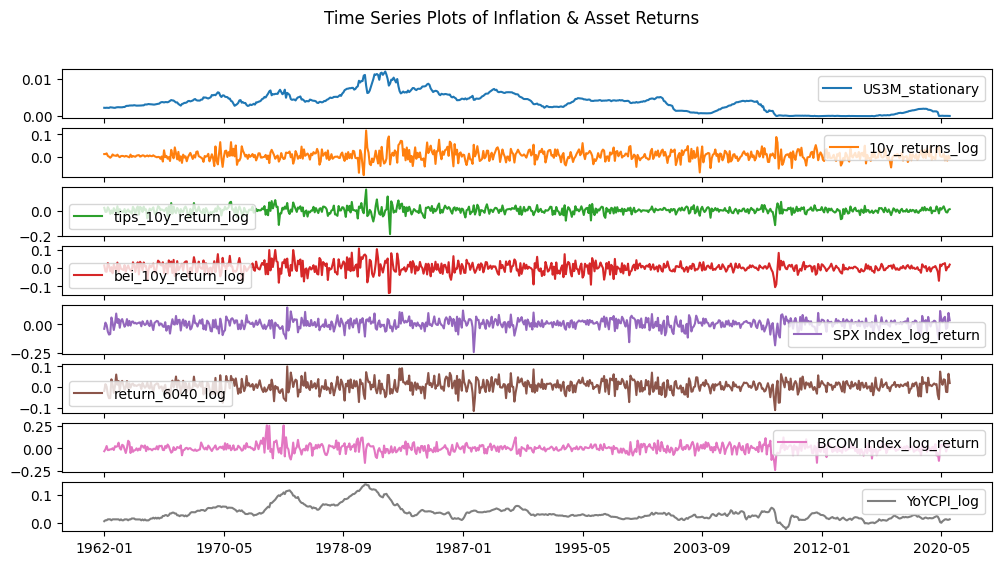

In [37]:
# Do not forget to make sure that the impulse responses only measure for inflation
var_data = pd.DataFrame()

#M/M
var_data = log_return_asset[["US3M_stationary", "10y_returns_log", "tips_10y_return_log", 'bei_10y_return_log', "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]]
var_data = var_data.dropna(thresh=8)

# Inspect missing values and summary stats
print(var_data.info())
print(var_data.describe())

# Plot time series
var_data.plot(subplots=True, figsize=(12, 6))
plt.suptitle("Time Series Plots of Inflation & Asset Returns")
plt.show()

## Stationarity and lag order
## Fit the VAR model

In [38]:
def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NaNs for valid test
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1] < 0.05  # Stationary if p-value < 0.05

# Check stationarity for each variable
for col in var_data.columns:
    print(f"\nChecking stationarity for: {col}")
    is_stationary = check_stationarity(var_data[col])
    if not is_stationary:
        print(f"{col} is NOT stationary, differencing is needed!")

# Fit a preliminary VAR model to determine lag order
model = VAR(var_data)
lag_selection = model.select_order(maxlags=10)  # Search up to 10 lags
print(lag_selection.summary())  # Show AIC/BIC criteria

# Choose the best lag (e.g., based on AIC)
optimal_lag = lag_selection.aic

# Fit the VAR model
var_model = VAR(var_data)
fitted_model = var_model.fit(optimal_lag)

# Display summary
print(fitted_model.summary())


Checking stationarity for: US3M_stationary
ADF Statistic: -1.9216, p-value: 0.3220
US3M_stationary is NOT stationary, differencing is needed!

Checking stationarity for: 10y_returns_log
ADF Statistic: -19.2802, p-value: 0.0000

Checking stationarity for: tips_10y_return_log
ADF Statistic: -6.4365, p-value: 0.0000

Checking stationarity for: bei_10y_return_log
ADF Statistic: -17.5558, p-value: 0.0000

Checking stationarity for: SPX Index_log_return
ADF Statistic: -25.5032, p-value: 0.0000

Checking stationarity for: return_6040_log
ADF Statistic: -19.6703, p-value: 0.0000

Checking stationarity for: BCOM Index_log_return
ADF Statistic: -16.4508, p-value: 0.0000

Checking stationarity for: YoYCPI_log
ADF Statistic: -2.9639, p-value: 0.0384
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -76.12      -76.07   8.727e-34      -76.10
1       -84.06     -83.59*   3.109e-37     -83.

C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     11:30:02
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -83.3157
Nobs:                     706.000    HQIC:                  -83.8547
Log likelihood:           21842.3    FPE:                2.72283e-37
AIC:                     -84.1941    Det(Omega_mle):     2.25088e-37
--------------------------------------------------------------------
Results for equation US3M_stationary
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.000019         0.000024            0.775           0.438
L1.US3M_stationary               1.051505         0.043335           24.265           0.000
L1.10y

### Robustness checks

In [39]:
# Check for serial correlation in residuals
dw_stats = durbin_watson(fitted_model.resid)
print("Durbin-Watson Statistics:")
for col, stat in zip(var_data.columns, dw_stats):
    print(f"{col}: {stat:.2f}")

# Stability check
is_stable = fitted_model.is_stable()
print(f"VAR Model Stability: {is_stable}")

# Convert VAR residuals to a DataFrame with appropriate column names
resid_df = pd.DataFrame(fitted_model.resid, columns=fitted_model.model.endog_names)

Durbin-Watson Statistics:
US3M_stationary: 2.02
10y_returns_log: 2.00
tips_10y_return_log: 2.01
bei_10y_return_log: 2.02
SPX Index_log_return: 2.02
return_6040_log: 2.02
BCOM Index_log_return: 2.00
YoYCPI_log: 2.03
VAR Model Stability: True


In [40]:
# Convert the VAR residuals to a DataFrame with proper column names.
resid_df = pd.DataFrame(fitted_model.resid, columns=fitted_model.model.endog_names)

for col in resid_df.columns:
    print(f"\nHeteroskedasticity test for: {col}")
    resid_series = resid_df[col]
    
    # Check if the VAR model has an exogenous matrix.
    if fitted_model.model.exog is None:
        # No exogenous variables were included.
        # Construct an exog matrix using a constant and the fitted values for this equation.
        col_index = fitted_model.model.endog_names.index(col)
        # Extract fitted values for this equation.
        if isinstance(fitted_model.fittedvalues, pd.DataFrame):
            fitted_col = fitted_model.fittedvalues.iloc[:, col_index].values
        else:
            fitted_col = fitted_model.fittedvalues[:, col_index]
        # Build exog: constant + fitted values.
        exog_test = np.column_stack([np.ones(len(fitted_col)), fitted_col])
    else:
        # If exogenous variables exist, ensure a constant is included.
        exog_test = sm.add_constant(fitted_model.model.exog, has_constant='add')
    
    # Run the Breusch-Pagan test.
    bp_test = het_breuschpagan(resid_series, exog_test)
    labels = ['LM statistic', 'LM p-value', 'F-statistic', 'F p-value']
    for label, value in zip(labels, bp_test):
        print(f"  {label}: {value:.4f}")
    
    # Conclude on heteroskedasticity using a significance level of 5%
    if bp_test[1] < 0.05 or bp_test[3] < 0.05:
        print(f"Conclusion: Evidence of heteroskedasticity is present in {col} (p < 0.05).")
    else:
        print(f"Conclusion: No significant evidence of heteroskedasticity in {col} (p >= 0.05).")



Heteroskedasticity test for: US3M_stationary
  LM statistic: 79.9849
  LM p-value: 0.0000
  F-statistic: 89.9489
  F p-value: 0.0000
Conclusion: Evidence of heteroskedasticity is present in US3M_stationary (p < 0.05).

Heteroskedasticity test for: 10y_returns_log
  LM statistic: 20.3861
  LM p-value: 0.0000
  F-statistic: 20.9327
  F p-value: 0.0000
Conclusion: Evidence of heteroskedasticity is present in 10y_returns_log (p < 0.05).

Heteroskedasticity test for: tips_10y_return_log
  LM statistic: 0.0225
  LM p-value: 0.8808
  F-statistic: 0.0224
  F p-value: 0.8810
Conclusion: No significant evidence of heteroskedasticity in tips_10y_return_log (p >= 0.05).

Heteroskedasticity test for: bei_10y_return_log
  LM statistic: 0.3021
  LM p-value: 0.5826
  F-statistic: 0.3014
  F p-value: 0.5832
Conclusion: No significant evidence of heteroskedasticity in bei_10y_return_log (p >= 0.05).

Heteroskedasticity test for: SPX Index_log_return
  LM statistic: 0.5983
  LM p-value: 0.4392
  F-stati

## Impulse Response Functions (IRFs)

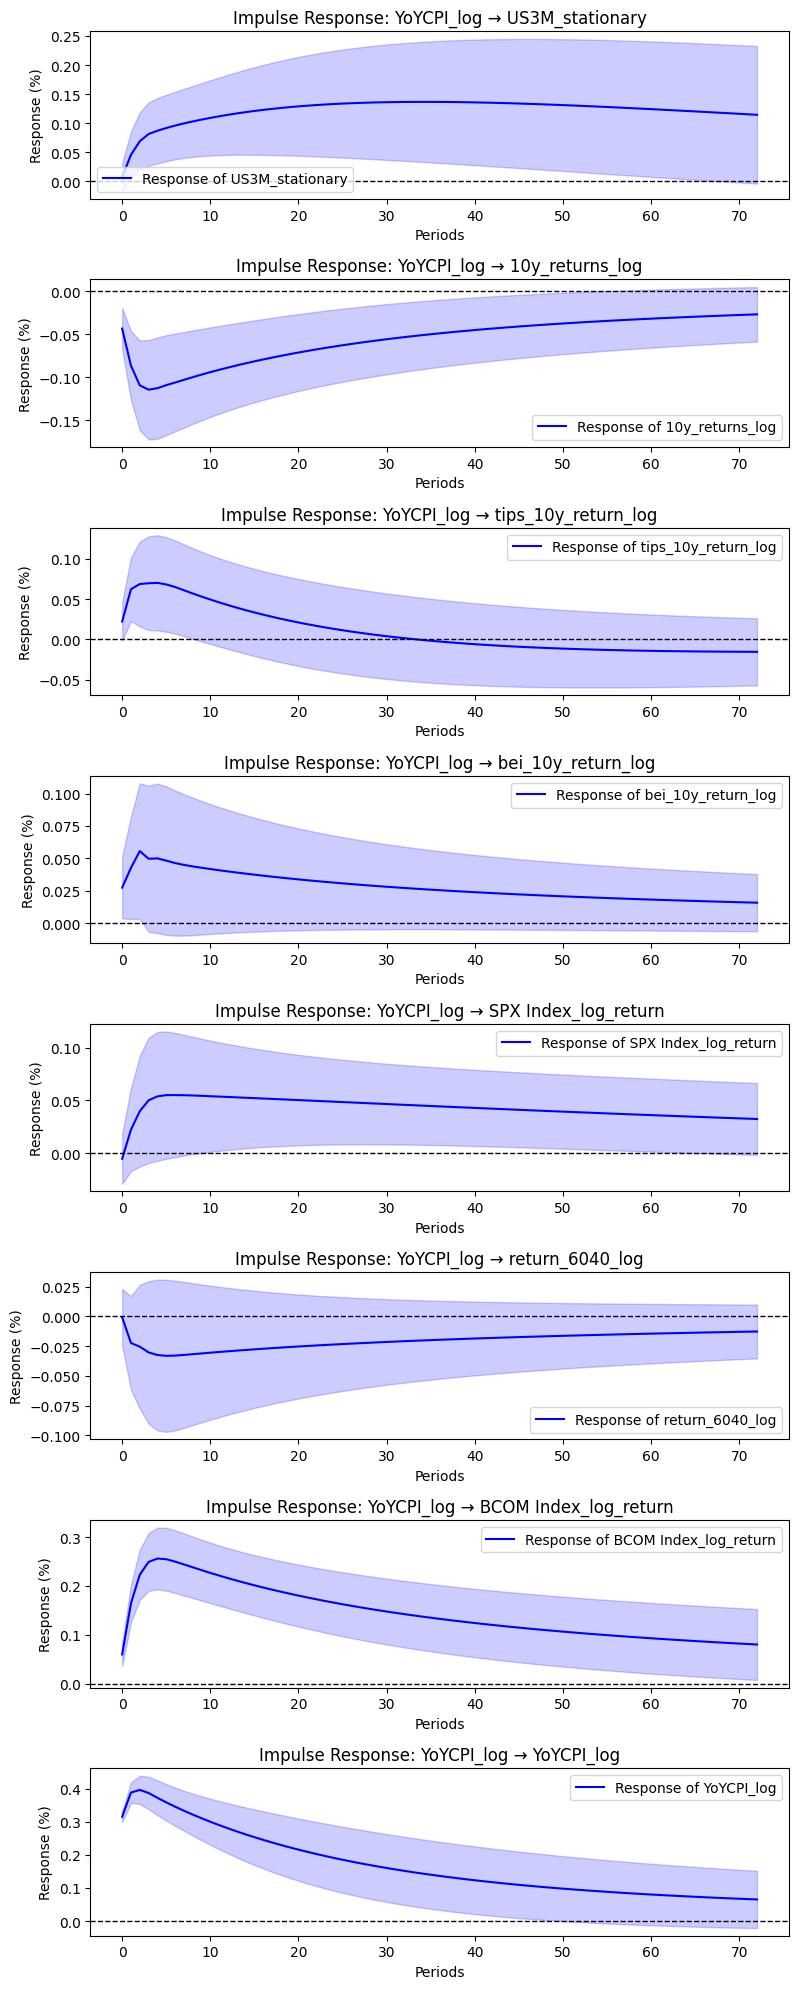

In [41]:
def plot_irfs(irf, impulse, response_vars, periods=72):
    fig, axes = plt.subplots(len(response_vars), 1, figsize=(8, 20))
    # fig, axes = plt.subplots(len(response_vars), 1, figsize=(8, 5 * len(response_vars)))

    if len(response_vars) == 1:
        axes = [axes]  # Ensure indexing works when there is only one plot

    impulse_index = fitted_model.model.endog_names.index(impulse)  # Get index of impulse variable

    for i, response in enumerate(response_vars):
        response_index = fitted_model.model.endog_names.index(response)

        irf_data = irf.orth_irfs[:periods+1, impulse_index, response_index]
        stderr = irf.stderr(orth=True)[:periods+1, impulse_index, response_index]  # Get standard errors

        lower = irf_data - 1.96 * stderr  # 95% lower bound
        upper = irf_data + 1.96 * stderr  # 95% upper bound

        axes[i].plot(range(periods+1), irf_data * 100, label=f"Response of {response}", color="blue")
        axes[i].fill_between(range(periods+1), lower * 100, upper * 100, color="blue", alpha=0.2)  # Shading

        axes[i].set_title(f"Impulse Response: {impulse} → {response}")
        axes[i].axhline(y=0, color="black", linestyle="--", linewidth=1)
        axes[i].set_xlabel("Periods")
        axes[i].set_ylabel("Response (%)")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage
response_vars = list(var_data.columns)
plot_irfs(fitted_model.irf(72), impulse="YoYCPI_log", response_vars=response_vars)



### Ordering

## Different VAR variables and orders

### A wide array of orders

In [42]:
# # Define different versions of var_data
# var_data_versions = {
#     "Version 1 (excl. DXY)": log_return_asset[["SPX Index_log_return", "BCOM Index_log_return", 
#                                                     "10y_returns_log", "return_6040_log", "tips_10y_return_log", "YoYCPI_log"]].dropna(thresh=6),
    
#     "Version 2 (excl. DXY and 60/40)": log_return_asset[["SPX Index_log_return", "BCOM Index_log_return", 
#                                                     "10y_returns_log", "tips_10y_return_log", "YoYCPI_log"]].dropna(thresh=5),
    
#     "Version 3 (BEI then TIPS, excl. DXY and 60/40)": log_return_asset[["SPX Index_log_return", "BCOM Index_log_return", 'bei_10y_return_log',
#                                                     "tips_10y_return_log", "10y_returns_log", "YoYCPI_log"]].dropna(thresh=6),

#     "Version 4 (TIPS then BEI, excl. DXY and 60/40)": log_return_asset[["SPX Index_log_return", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "YoYCPI_log"]].dropna(thresh=6),

#     "Version 5 (TIPS then BEI, incl. cash)": log_return_asset[["SPX Index_log_return", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "US3M_stationary", "10y_returns_log", "YoYCPI_log"]].dropna(thresh=7),

#     "Version 5.2 (TIPS then BEI, incl. 60/40)": log_return_asset[["SPX Index_log_return", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "return_6040_log", "YoYCPI_log"]].dropna(thresh=7),

#     "Version 5.3 (TIPS then BEI, 60/40 early)": log_return_asset[["SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "YoYCPI_log"]].dropna(thresh=7),

#     "Version 6 (TIPS then BEI, incl. 60/40 and cash)": log_return_asset[["SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "US3M_stationary", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 6.1 (TIPS then BEI, incl. 60/40 and cash)": log_return_asset[["SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "US3M_stationary", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 6.1.1 (TIPS then BEI, incl. 60/40 and cash)": log_return_asset[["SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "tips_10y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "USGG3M Index_log", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 6.2 (TIPS then BEI, incl. 60/40 and cash)": log_return_asset[["SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "tips_2y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "USGG3M Index_log", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 6.3 (TIPS then BEI, incl. 60/40 and cash)": log_return_asset[["SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "tips_2y_return_log", 
#                                                                         'bei_10y_return_log', "10y_returns_log", "US3M_stationary", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 7 (Order like paper with TIPS and BEI)": log_return_asset[["US3M_stationary", "10y_returns_log", 'bei_10y_return_log', "tips_10y_return_log", 
#                                                       "SPX Index_log_return", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=7),

#     "Version 8 (Order like paper with TIPS and BEI and 6040)": log_return_asset[["US3M_stationary", "10y_returns_log", 'bei_10y_return_log', "tips_10y_return_log", 
#                                                       "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 8.2 (Order like paper with TIPS and BEI and 6040)": log_return_asset[["US3M_stationary", "10y_returns_log", "tips_10y_return_log", 'bei_10y_return_log',
#                                                       "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 8.2.1 (Order like paper with TIPS and BEI and 6040)": log_return_asset[["US3M_stationary", "10y_returns_log", "tips_10y_return_log", 'bei_10y_return_log',
#                                                       "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 8.2.2 (Order like paper with TIPS and BEI and 6040)": log_return_asset[["USGG3M Index_log", "10y_returns_log", "tips_10y_return_log", 'bei_10y_return_log',
#                                                       "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=8),

#     "Version 8.2.3 (Order like paper with TIPS and BEI and 6040)": log_return_asset[["USGG3M Index_log", "10y_returns_log", "tips_2y_return_log", 'bei_10y_return_log',
#                                                       "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=8)

#     "Version 9 (Like paper)": log_return_asset[["US3M_stationary", "10y_returns_log", "SPX Index_log_return", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=5)

#     "Version 10 (Order like paper with TIPS and BEI excess and 6040)": log_return_asset[["US3M_stationary", "10y_returns_log", "tips_10y_return_log", 'bei_10y_excess_return_log',
#                                                       "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]].dropna(thresh=8),
# }

# # Dictionary to store results
# var_results = {}

# for version_name, var_data in var_data_versions.items():
#     print(f"\n============================")
#     print(f"Running VAR for: {version_name}")
#     print("============================\n")

#     # Inspect missing values and summary stats
#     # print(var_data.info())
#     # print(var_data.describe())

#     # Plot time series
#     # var_data.plot(subplots=True, figsize=(12, 6))
#     # plt.suptitle(f"Time Series: {version_name}")
#     # plt.show()

#     # Fit a preliminary VAR model to determine lag order
#     model = VAR(var_data)
#     lag_selection = model.select_order(maxlags=10)  # Search up to 10 lags
#     print(lag_selection.summary())  # Show AIC/BIC criteria

#     # Choose the best lag (e.g., based on AIC)
#     optimal_lag = lag_selection.aic

#     # Fit the VAR model
#     fitted_model = model.fit(2)
#     var_results[version_name] = fitted_model  # Store the fitted model

#     # Display summary
#     print(fitted_model.summary())

#     # Check for serial correlation in residuals
#     dw_stats = durbin_watson(fitted_model.resid)
#     print("Durbin-Watson Statistics:")
#     for col, stat in zip(var_data.columns, dw_stats):
#         print(f"{col}: {stat:.2f}")

#     # Stability check
#     is_stable = fitted_model.is_stable()
#     print(f"VAR Model Stability: {is_stable}")

#     # Convert VAR residuals to a DataFrame
#     resid_df = pd.DataFrame(fitted_model.resid, columns=fitted_model.model.endog_names)

#     # # Normality test (Jarque-Bera) for each equation
#     # for col in resid_df.columns:
#     #     jb_stat, jb_p, _, _ = jarque_bera(resid_df[col])
#     #     print(f"Jarque-Bera for {col}: stat={jb_stat:.2f}, p-value={jb_p:.4f}")
#         # if jb_p < 0.05:
#         #     print(f"--> Residuals for {col} deviate from normality (p < 0.05).")
#         #     all_normal = False
#         # if all_normal:
#         #     print("Conclusion: Residuals appear normally distributed (all p-values >= 0.05).")
#         # else:
#         #     print("Conclusion: Some residuals deviate significantly from normality (p-value < 0.05).")

#     # Define the impulse variable (inflation) and all other variables as responses.
#     impulse_var = "YoYCPI_log"  # adjust if your inflation variable has a different name
#     var_names = fitted_model.model.endog_names
#     response_vars = [name for name in var_names]
    
#     # Compute the IRF for 72 periods.
#     irf_obj = fitted_model.irf(72)
#     print(f"Plotting IRFs for {version_name} (Impulse: {impulse_var})")
#     plot_irfs(irf_obj, impulse=impulse_var, response_vars=response_vars, periods=72)


## Scatterplots

In [1]:
# yoy_return_asset["bond10y_return_yoy"]

# assets = {
#     "Inflation": combined_data["YoYCPI"],
#     "Gold": yoy_return_asset["XAU BGN Curncy_yoy_return"],
#     "Stocks": yoy_return_asset["SPX Index_yoy_return"],
#     "60/40": yoy_return_asset["return_6040_yoy"],
#     "Bonds": yoy_return_asset["bond10y_return_yoy"],
#     "3M T-bill": combined_data["US3M_approx_yoy"],
#     "TIPS 10Y": yoy_return_asset["tips_10y_return_yoy"],
#     "BEI 10Y": yoy_return_asset["bei_10y_return_yoy"],
#     "Commodities": yoy_return_asset["BCOM Index_yoy_return"]
# }

# df = pd.DataFrame(assets)

# # Define dynamic grid size
# num_assets = len(df.columns) - 1  # Excluding "Inflation"
# cols = 1  # Set number of columns (adjust as needed)
# rows = (num_assets + cols - 1) // cols  # Ensure enough rows

# # Plot scatterplots dynamically
# plt.figure(figsize=(cols * 12, rows * 6))

# for i, asset in enumerate(df.columns[1:]):  # Skip "Inflation"
#     plt.subplot(rows, cols, i + 1)
#     sns.regplot(x="Inflation", y=asset, data=df, scatter_kws={'alpha':0.7})
#     plt.xlabel("Inflation (%)")
#     plt.ylabel(f"{asset} Return")
#     plt.title(f"Inflation vs {asset}")

# plt.tight_layout()
# plt.show()


### VAR and IRF for YoY CPI $>0.02$ and $<0.02$

C:\Users\kons-esm\AppData\Local\Temp\ipykernel_16088\282871099.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  var_data_high = var_data[condition].dropna()
C:\Users\kons-esm\AppData\Local\Temp\ipykernel_16088\282871099.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  var_data_low  = var_data[~condition].dropna()
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of observations in High YoYCPI sample: 514
Number of observations in Low YoYCPI sample: 194

Computing IRFs for High YoYCPI (>2%) periods:

High YoYCPI (>2%) VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     11:30:09
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -82.9253
Nobs:                     513.000    HQIC:                  -83.2872
Log likelihood:           15671.7    FPE:                5.33997e-37
AIC:                     -83.5205    Det(Omega_mle):     4.64637e-37
--------------------------------------------------------------------
Results for equation US3M_stationary
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const 

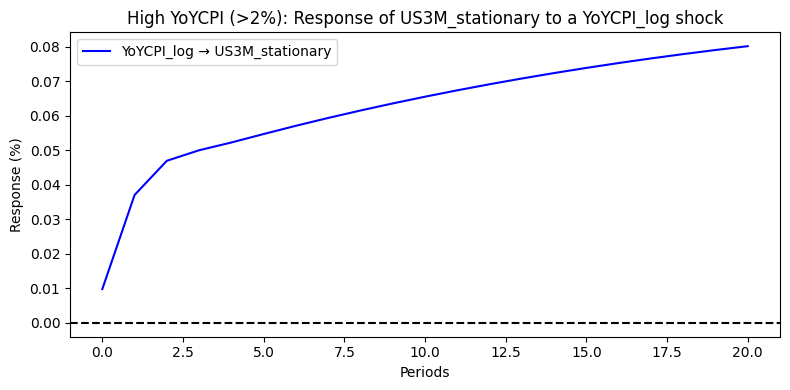

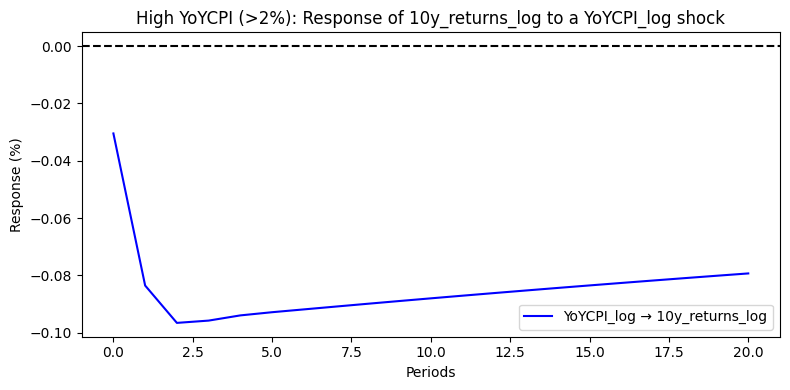

KeyboardInterrupt: 

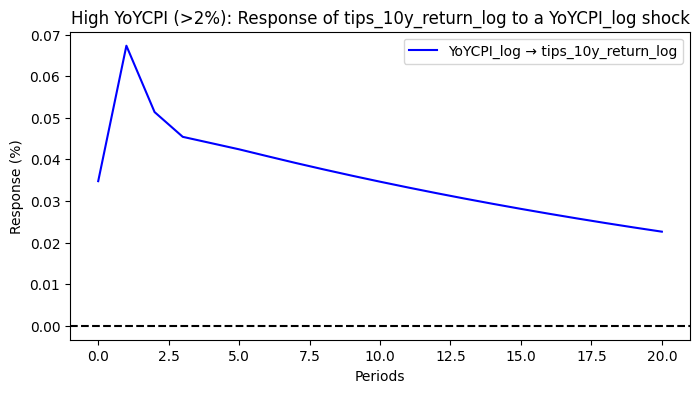

In [44]:
# --- Split sample ---
condition = combined_data["YoYCPI"] > 0.02

# Select the VAR columns from the log_return_asset DataFrame.
var_cols = ["US3M_stationary", "10y_returns_log", "tips_10y_return_log", "bei_10y_return_log",
            "SPX Index_log_return", "return_6040_log", "BCOM Index_log_return", "YoYCPI_log"]

# Extract the VAR data
var_data = log_return_asset[var_cols]

# Split the data using the condition from combined_data.
# (Assumes both DataFrames share the same DateTime index.)
var_data_high = var_data[condition].dropna()
var_data_low  = var_data[~condition].dropna()

print("Number of observations in High YoYCPI sample:", len(var_data_high))
print("Number of observations in Low YoYCPI sample:", len(var_data_low))

# --- Function to compute and plot IRFs for a VAR model ---
def compute_and_plot_irf(var_data_subset, title, horizon=20):
    model = VAR(var_data_subset)
    lag_order = model.select_order(maxlags=10)
    chosen_lag = lag_order.aic if not np.isnan(lag_order.aic) and lag_order.aic >= 1 else 1
    results = model.fit(chosen_lag)
    print(f"\n{title} VAR Model Summary:")
    print(results.summary())
    
    irf_obj = results.irf(horizon)
    impulse_var = "YoYCPI_log"
    var_names = results.model.endog_names
    
    # Plot responses for each variable other than the impulse variable.
    for asset in var_names:
        if asset == impulse_var:
            continue
        impulse_idx = var_names.index(impulse_var)
        response_idx = var_names.index(asset)
        irf_line = irf_obj.orth_irfs[:horizon+1, impulse_idx, response_idx]
        plt.figure(figsize=(8, 4))
        plt.plot(range(horizon+1), irf_line * 100, label=f"{impulse_var} → {asset}", color="blue")
        plt.axhline(0, color="black", linestyle="--")
        plt.xlabel("Periods")
        plt.ylabel("Response (%)")
        plt.title(f"{title}: Response of {asset} to a {impulse_var} shock")
        plt.legend()
        plt.tight_layout()
        plt.show()

# --- Compute and Plot IRFs for Each Subsample ---
print("\nComputing IRFs for High YoYCPI (>2%) periods:")
compute_and_plot_irf(var_data_high, "High YoYCPI (>2%)", horizon=20)

print("\nComputing IRFs for Low YoYCPI (<=2%) periods:")
compute_and_plot_irf(var_data_low, "Low YoYCPI (<=2%)", horizon=20)

# Portfolio time

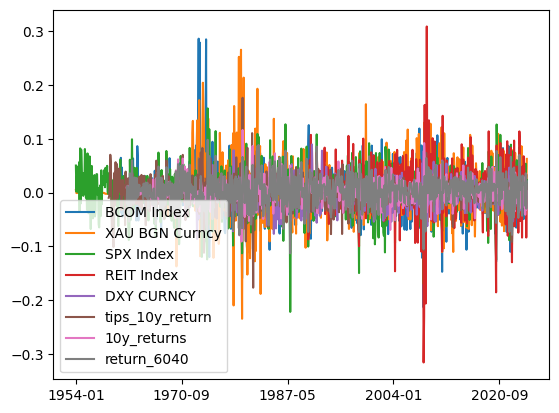

In [ ]:
# ----------------------------
# Monthly excess returns
# ----------------------------

# Defined as annual return minus 10Y return
#YoY
port_columns = ['BCOM Index', 'XAU BGN Curncy', 'SPX Index', 
       'REIT Index', 'DXY CURNCY'] 
port_returns_columns = ['tips_10y_return', '10y_returns', 'return_6040']

excess_return_mom = pd.DataFrame()
for column in port_columns:
    excess_return_mom[f"{column}"] = combined_data[column].pct_change() - combined_data["US3M_approx"]

for col in port_returns_columns:
    excess_return_mom[f"{col}"] = combined_data[col] - combined_data["US3M_approx"]

excess_return_mom.dropna(how='all').plot()
excess_return_mom_nomask = excess_return_mom
mask_mom_excess = pd.to_datetime(excess_return_mom.index, format='%Y-%m') < '2021-01-01'
excess_return_mom = excess_return_mom[mask_mom_excess]

## Stats

In [ ]:
def port_VaR(returns, CI=0.05):
    returns = returns.dropna()
    sorted_returns = np.sort(returns)
    n_obs = len(returns)
    var_index = int(n_obs*CI)
    return sorted_returns[var_index]

def port_cVaR(returns, CI=0.05):
    returns = returns.dropna()
    sorted_returns = np.sort(returns)
    n_obs = len(returns)
    cvar_index = int(n_obs*CI)
    return np.mean(sorted_returns[:cvar_index])

def port_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

def port_sortino_ratio(returns, target_return=0):
    excess_returns = returns - target_return
    downside_deviation = np.sqrt(np.mean(np.minimum(0, excess_returns) ** 2))
    mean_excess_return = np.mean(excess_returns)
    if downside_deviation == 0:
        return np.nan  # Avoid division by zero
    return mean_excess_return / downside_deviation


#### Keyfigures on 10 worst 60/40 drawdowns

In [ ]:
return_Data = pd.DataFrame()
return_Data['XAU BGN Curncy'] = combined_data['XAU BGN Curncy'].pct_change(1)
# return_Data['REIT Index'] = combined_data['REIT Index'].pct_change(1)
return_Data['DXY CURNCY'] = combined_data['DXY CURNCY'].pct_change(1)
return_Data['BCOM Index'] = combined_data['BCOM Index'].pct_change(1)
return_Data['SPX Index'] = combined_data['SPX Index'].pct_change(1)
return_Data['tips_10y_return'] = combined_data['tips_10y_return']
return_Data['10y_returns'] = combined_data['10y_returns']
return_Data['return_6040'] = combined_data['return_6040']
# return_Data['US3M_return'] = combined_data['US3M_approx']


subset_return_Data = pd.concat(
    [return_Data.loc[start:end] for _, start, end in date_intervals]
)

mask_before_2021 = pd.to_datetime(subset_return_Data.index, format='%Y-%m')<'2021-01-01'
subset_return_Data= subset_return_Data[mask_before_2021]

instrument_stats = pd.DataFrame()
instrument_stats['Min'] = subset_return_Data.min()
instrument_stats['Max'] = subset_return_Data.max()
instrument_stats['Mean'] = subset_return_Data.mean()
instrument_stats['Std'] = subset_return_Data.std()
instrument_stats['SR'] = instrument_stats['Mean']/instrument_stats['Std']
instrument_stats['Skew'] = subset_return_Data.skew()
instrument_stats['Kurtosis'] = subset_return_Data.kurtosis()
instrument_stats["VaR at 5 % CI"] = subset_return_Data.apply(lambda x: port_VaR(x))
instrument_stats["CVaR at 5 % CI"] = subset_return_Data.apply(lambda x: port_cVaR(x))
instrument_stats["Sortino Ratio"] = subset_return_Data.apply(lambda x: port_sortino_ratio(x))

# Annualize
instrument_stats['Annualized Mean'] = instrument_stats['Mean'] * 12
instrument_stats['Annualized Std'] = instrument_stats['Std'] * np.sqrt(12)
instrument_stats['Annualized SR'] = instrument_stats['SR'] * np.sqrt(12)
instrument_stats['Annualized Sortino'] = instrument_stats["Sortino Ratio"] * np.sqrt(12)

# Optional: reorder columns for readability
cols_order = [
    'Annualized Mean',
    'Annualized Std', 'Annualized SR', 'Annualized Sortino',
    'Skew', 'Kurtosis', 'VaR at 5 % CI', 'CVaR at 5 % CI'
]
instrument_stats = instrument_stats[cols_order]

instrument_stats.sort_values("Annualized SR")

Annualized Mean  Annualized Std  Annualized SR  \
SPX Index              -0.036353        0.171188      -0.212354   
DXY CURNCY             -0.008947        0.088352      -0.101266   
return_6040             0.006050        0.111957       0.054035   
BCOM Index              0.093052        0.206884       0.449777   
10y_returns             0.060210        0.090377       0.666210   
XAU BGN Curncy          0.154298        0.221324       0.697158   
tips_10y_return         0.090460        0.121842       0.742441   

                 Annualized Sortino      Skew  Kurtosis  VaR at 5 % CI  \
SPX Index                 -0.276359 -0.384537  1.356498      -0.090279   
DXY CURNCY                -0.144182  0.224395  1.082128      -0.043335   
return_6040                0.077252 -0.036408  0.867488      -0.053593   
BCOM Index                 0.796665  1.085815  5.596037      -0.073308   
10y_returns                1.209174  0.661194  2.526208      -0.034432   
XAU BGN Curncy             1.294407  0.678897  3.457207      -0.070251   
tips_10y_return            1.237914  0.053301  5.136736      -0.040786   

                 CVaR at 5 % CI  
SPX Index             -0.116810  
DXY CURNCY            -0.055730  
return_6040           -0.071018  
BCOM Index            -0.112620  
10y_returns           -0.045334  
XAU BGN Curncy        -0.125964  
tips_10y_return       -0.070534

### Check returns

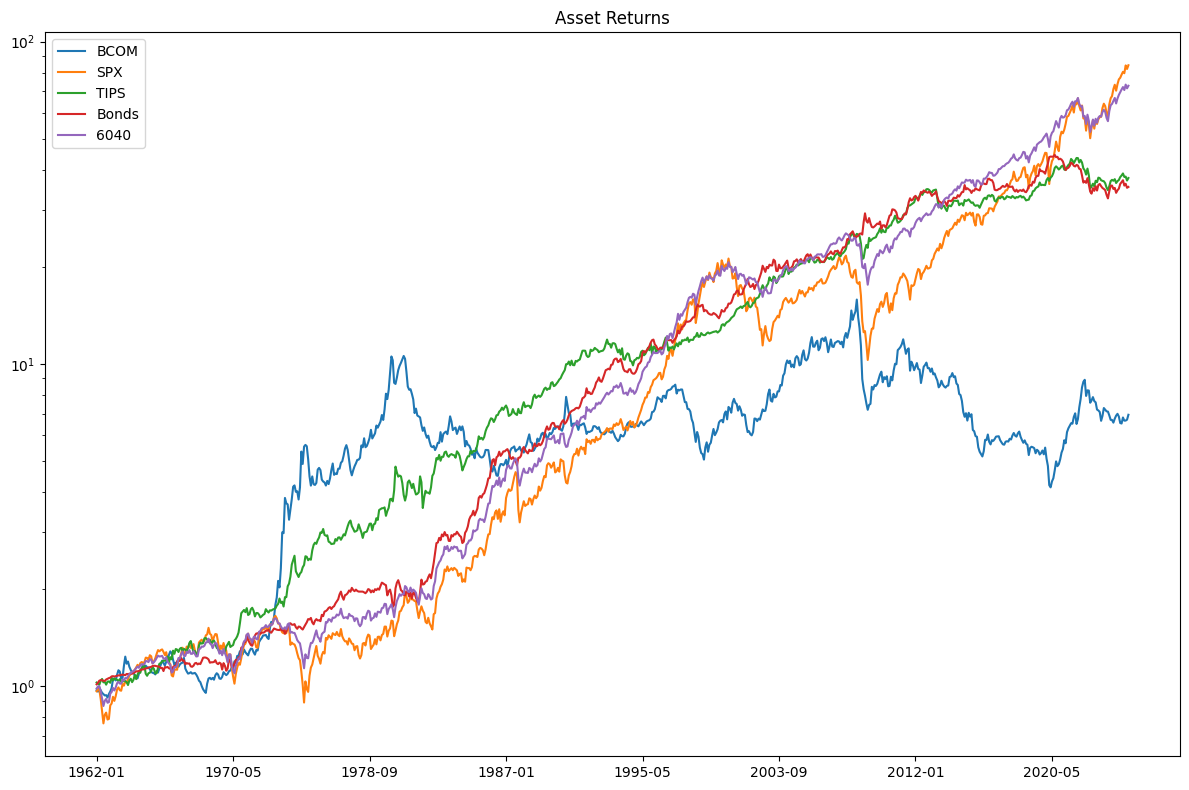

In [ ]:
combined_data["BCOM Index_yoy"] = combined_data["BCOM Index"].pct_change(12)
combined_data["SPX Index_yoy"] = combined_data["SPX Index"].pct_change(12)
combined_data["XAU BGN Curncy_yoy"] = combined_data["XAU BGN Curncy"].pct_change(12)
combined_data["BCOM Index_mom"] = combined_data["BCOM Index"].pct_change(1)
combined_data["SPX Index_mom"] = combined_data["SPX Index"].pct_change(1)

asset_return_check = combined_data[["BCOM Index_yoy", "XAU BGN Curncy", "SPX Index_yoy", 'tips_10y_return_yoy', 'bond10y_return_yoy', 'return_6040_yoy']].dropna(thresh=6)
asset_return_check_mom = combined_data[["BCOM Index_mom", "SPX Index_mom", 'tips_10y_return', '10y_returns', 'return_6040', 'US3M_approx']].dropna(thresh=5)

mask = pd.to_datetime(asset_return_check.index, format='%Y-%m') < '2021-01-01'
asset_return_check = asset_return_check[mask]

# Visualization
normalreturns = pd.DataFrame()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

normalreturns['BCOM'] = (asset_return_check_mom['BCOM Index_mom'] + 1).cumprod()
normalreturns['SPX'] = (asset_return_check_mom['SPX Index_mom'] + 1).cumprod()
normalreturns['TIPS'] = (asset_return_check_mom['tips_10y_return'] + 1).cumprod()
normalreturns['Bonds'] = (asset_return_check_mom['10y_returns'] + 1).cumprod()
normalreturns['6040'] = (asset_return_check_mom['return_6040'] + 1).cumprod()
# normalreturns['3M'] = (asset_return_check_mom['US3M_approx'] + 1).cumprod()

normalreturns.plot(ax=ax, logy=True)
ax.set_title('Asset Returns')
ax.legend()

plt.tight_layout()
plt.show()

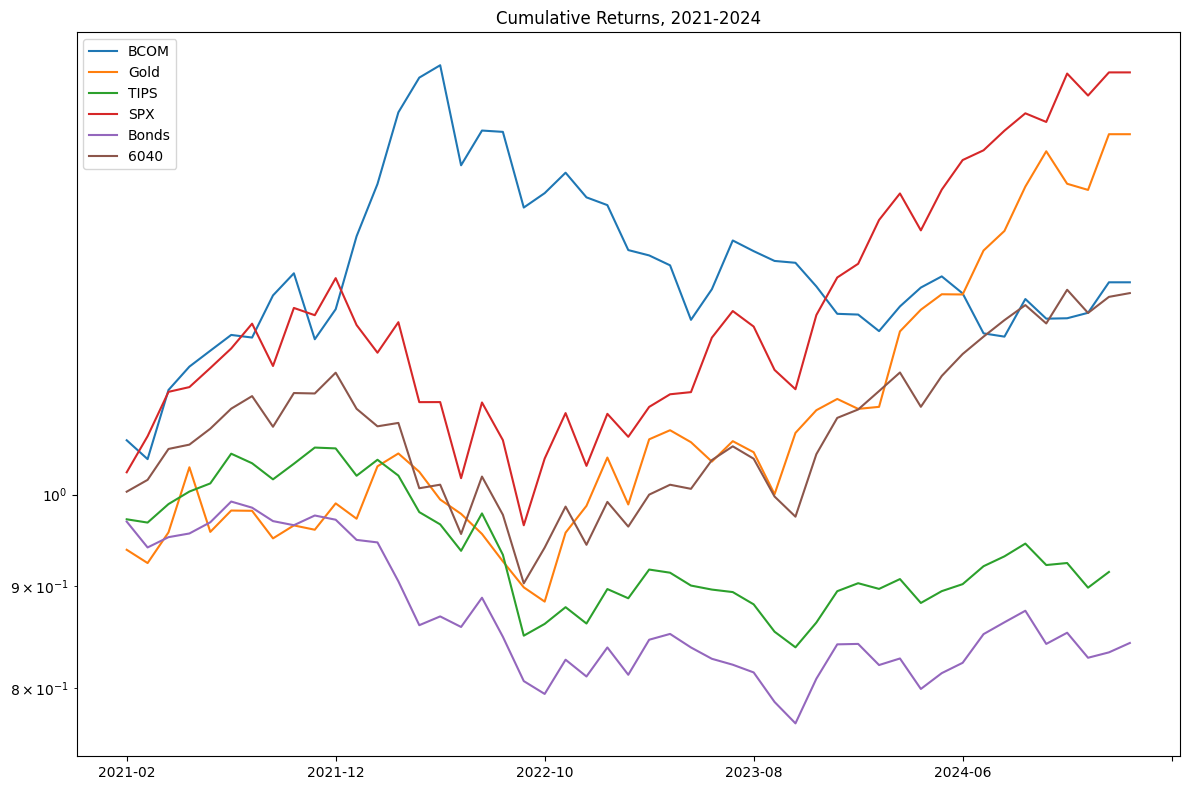

In [ ]:
combined_data["BCOM Index_yoy"] = combined_data["BCOM Index"].pct_change(12)
combined_data["SPX Index_yoy"] = combined_data["SPX Index"].pct_change(12)
combined_data["XAU BGN Curncy_yoy"] = combined_data["XAU BGN Curncy"].pct_change(12)
combined_data["BCOM Index_mom"] = combined_data["BCOM Index"].pct_change(1)
combined_data["SPX Index_mom"] = combined_data["SPX Index"].pct_change(1)
combined_data["XAU BGN Curncy_mom"] = combined_data["XAU BGN Curncy"].pct_change(1)

asset_return_check = combined_data[["BCOM Index_yoy", "XAU BGN Curncy", "SPX Index_yoy", 'tips_10y_return_yoy', 'bond10y_return_yoy', 'return_6040_yoy']].dropna(thresh=6)
asset_return_check_mom = combined_data[["BCOM Index_mom", "XAU BGN Curncy_mom", "SPX Index_mom", 'tips_10y_return', '10y_returns', 'return_6040']].dropna(thresh=5)

mask = pd.to_datetime(asset_return_check_mom.index, format='%Y-%m') > '2021-01-01'
asset_return_check_mom = asset_return_check_mom[mask]

# Visualization
normalreturns = pd.DataFrame()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)


normalreturns['BCOM'] = (asset_return_check_mom['BCOM Index_mom'] + 1).cumprod()
normalreturns['Gold'] = (asset_return_check_mom['XAU BGN Curncy_mom'] + 1).cumprod()
normalreturns['TIPS'] = (asset_return_check_mom['tips_10y_return'] + 1).cumprod()
normalreturns['SPX'] = (asset_return_check_mom['SPX Index_mom'] + 1).cumprod()
normalreturns['Bonds'] = (asset_return_check_mom['10y_returns'] + 1).cumprod()
normalreturns['6040'] = (asset_return_check_mom['return_6040'] + 1).cumprod()

normalreturns.plot(ax=ax, logy=True)
ax.set_title('Cumulative Returns, 2021-2024')
ax.legend()

plt.tight_layout()
plt.show()

## Variations of the 60/40

In [ ]:
# ----------------------------
# Variations of the 60/40
# ----------------------------
asset_port_df = combined_data[["BCOM Index", "XAU BGN Curncy", "SPX Index", 'tips_10y_return', '10y_returns', 'return_6040']].dropna(thresh=6)

# Returns
combined_data['return_7030'] = asset_port_df['SPX Index'].pct_change(1)*0.7 + asset_port_df['10y_returns']*0.3
combined_data['return_7030_yoy'] = (1 + combined_data['return_7030']).rolling(window=12).apply(np.prod) - 1

combined_data['return_50103208'] = asset_port_df['SPX Index'].pct_change(1)*0.5 + asset_port_df['BCOM Index'].pct_change(1)*0.1 + asset_port_df['10y_returns']*0.32 + asset_port_df['tips_10y_return']*0.08
combined_data['return_50103208_yoy'] = (1 + combined_data['return_50103208']).rolling(window=12).apply(np.prod) - 1

combined_data['return_50102512'] = asset_port_df['SPX Index'].pct_change(1)*0.5 + asset_port_df['BCOM Index'].pct_change(1)*0.1 + asset_port_df['10y_returns']*0.25 + asset_port_df['tips_10y_return']*0.15
combined_data['return_50102515_yoy'] = (1 + combined_data['return_50102512']).rolling(window=12).apply(np.prod) - 1

combined_data['6040_48comm'] = asset_port_df['return_6040']*0.52 + asset_port_df['BCOM Index'].pct_change(1)*0.48
combined_data['6040_48comm_yoy'] = (1 + combined_data['6040_48comm']).rolling(window=12).apply(np.prod) - 1

combined_data['6040_235comm'] = asset_port_df['return_6040']*0.765 + asset_port_df['BCOM Index'].pct_change(1)*0.235
combined_data['6040_235comm_yoy'] = (1 + combined_data['6040_235comm']).rolling(window=12).apply(np.prod) - 1

combined_data['7030_235comm'] = combined_data['return_7030']*0.765 + asset_port_df['BCOM Index'].pct_change(1)*0.235
combined_data['7030_235comm_yoy'] = (1 + combined_data['7030_235comm']).rolling(window=12).apply(np.prod) - 1

# Performance in 2021-2024, mean, volatility, and Sharpe in and out of sample
# Drawdowns and performance in worst inflationary periods
# Expected shortfall (CVaR) and VaR, probability of losses >5 and >10 %

## Mean Variance optimization

#### Mean variance with Gold and TIPS

In [ ]:
mean_var_df = excess_return_mom[["BCOM Index", "XAU BGN Curncy", "SPX Index", 'tips_10y_return', '10y_returns']].dropna(thresh=5)

Sigma = mean_var_df.cov() 
mu = mean_var_df.mean()
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

def optim_func(weights):
    pf_sigma = weights.T @ Sigma @ weights
    pf_mu = weights.T @ mu
    pf_sr = pf_mu/pf_sigma
    return - pf_sr

cons = [
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: x[3]},
    {'type': 'ineq', 'fun': lambda x: x[4]}
]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})

weights_optim = res.x

combined_data['mean_var_portfolio_gold_TIPS'] = asset_port_df[['BCOM Index', 'XAU BGN Curncy', 'SPX Index']].pct_change(1) @ weights_optim[0:3] + asset_port_df[['tips_10y_return', '10y_returns']] @ weights_optim[3:5]
combined_data['mean_var_portfolio_gold_TIPS_yoy'] = (1 + combined_data['mean_var_portfolio_gold_TIPS']).rolling(window=12).apply(np.prod) - 1

weights_optim

array([0.0173429 , 0.11196585, 0.17785212, 0.2572971 , 0.43554202])

#### Minimum Variance

In [ ]:
mean_var_df = excess_return_mom[["BCOM Index", "XAU BGN Curncy", "SPX Index", 'tips_10y_return', '10y_returns']].dropna(thresh=5)

Sigma = mean_var_df.cov() 
mu = mean_var_df.mean()
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

def optim_func(weights):
    pf_sigma = weights.T @ Sigma @ weights
    pf_mu = weights.T @ mu
    pf_sr = pf_mu/pf_sigma
    return pf_sigma

cons = [
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: x[3]},
    {'type': 'ineq', 'fun': lambda x: x[4]}
]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})

weights_optim = res.x 

combined_data['min_var_portfolio'] = asset_port_df[['BCOM Index', 'XAU BGN Curncy', 'SPX Index']].pct_change(1) @ weights_optim[0:3] + asset_port_df[['tips_10y_return', '10y_returns']] @ weights_optim[3:5]
combined_data['min_var_portfolio_yoy'] = (1 + combined_data['min_var_portfolio']).rolling(window=12).apply(np.prod) - 1

weights_optim

array([0.13864281, 0.02998098, 0.11797196, 0.22100609, 0.49239815])

# Minimum shortfall probability

#### Empirical distribution

In [ ]:
# mean_var_df = excess_return_asset[["BCOM Index_excess", "XAU BGN Curncy_excess", "SPX Index_excess", 'tips10y_excess_yoy', 'bond10y_excess_return_yoy']].dropna(thresh=5) # performer konge
mean_var_df = excess_return_mom[["BCOM Index", "XAU BGN Curncy", "SPX Index", 'tips_10y_return', '10y_returns']].dropna(thresh=5) # performer på niveau med minimum variance

Sigma = mean_var_df.cov() 
mu = mean_var_df.mean()
weights = np.array([0.10067284, 0.14127681, 0.22202121, 0.25560216, 0.28042697])
# threshold = 0.02 # yearly threshold
threshold = 0.015/12 # Monthly threshold

def optim_func(weights):
    pf_returns = mean_var_df @ weights
    shortfall_probability = np.mean(pf_returns < threshold)
    return shortfall_probability

cons = [
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: x[3]},
    {'type': 'ineq', 'fun': lambda x: x[4]}
]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP', #nelder-mead
                              options={'ftol': 1e-15, 'eps' :1e-2})

# res = scipy.optimize.brute(optim_func, 
#                            ranges=[slice(0, 1, 0.05)]*5, full_output=True, finish=None, workers=-1)

weights_optim = res.x 

# Optional: set NumPy to print with fixed-point precision
np.set_printoptions(precision=4, suppress=True)

print("Probability of shortfall below ", threshold*100, "%:", res.fun)
print("Weights", weights_optim)
# (mean_var_df @ np.array(weights_optim).reshape(-1, 1)).plot()
# (mean_var_df @ np.array(weights_optim).reshape(-1, 1) + 1).cumprod().plot(logy=True)

combined_data['min_shortfall_portfolio_empirical']  = asset_port_df[['BCOM Index', 'XAU BGN Curncy', 'SPX Index']].pct_change(1) @ weights_optim[0:3] + asset_port_df[['tips_10y_return', '10y_returns']] @ weights_optim[3:5]

Probability of shortfall below  0.125 %: 0.4435028248587571
Weights [0.2455 0.0382 0.4739 0.1809 0.0615]


# Dynamic hedge portfolio

### Recession Portfolio: minimum shortfall using date_intervals

In [ ]:
hedge_pf_data = excess_return_mom_nomask[["BCOM Index", "XAU BGN Curncy", 'tips_10y_return']].dropna(thresh=3)
# Ensure the index of combined_data is a datetime index
hedge_pf_data.index = pd.to_datetime(hedge_pf_data.index)

# Filter rows where the index falls within any of the date intervals
subset_hedge_pf_data = pd.concat(
    [hedge_pf_data.loc[start:end] for _, start, end in date_intervals]
)

Sigma = subset_hedge_pf_data.cov() 
mu = subset_hedge_pf_data.mean()
weights = np.array([0.33, 0.33, 0.33])
threshold = 0.01/12

def optim_func(weights):
    pf_returns = subset_hedge_pf_data @ weights
    shortfall_probability = np.mean(pf_returns < threshold)
    #shortfall_probability = np.power(np.sqrt(2*np.pi*np.power(pf_sigma,2)), -1) * integrate.quad(lambda x: np.exp(-0.5 * np.power(x-pf_mu, 2) / np.power(pf_sigma,2)), -np.inf, threshold)[0]
    return shortfall_probability

cons = [
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]}
]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP', #nelder-mead
                              options={'ftol': 1e-15, 'eps' :1e-2})

minshort_overlay_weights = res.x 
print("Probability of shortfall below ", threshold*100, "%:", res.fun)
print("Weights", minshort_overlay_weights)

combined_data['recession_min_shortfall'] = asset_port_df[['BCOM Index', 'XAU BGN Curncy']].pct_change(1) @ minshort_overlay_weights[0:2] + asset_port_df[['tips_10y_return']] @ minshort_overlay_weights[2:3]

Probability of shortfall below  0.08333333333333334 %: 0.4699248120300752
Weights [0.306  0.3793 0.3147]


### Recession portfolio: mean variance using date_intervals

In [ ]:
mean_var_df = excess_return_mom[["BCOM Index", "XAU BGN Curncy", 'tips_10y_return']].dropna(thresh=3)
# Filter rows where the index falls within any of the date intervals
mean_var_df = pd.concat(
    [mean_var_df.loc[start:end] for _, start, end in date_intervals]
)

Sigma = mean_var_df.cov() 
mu = mean_var_df.mean()
weights = np.array([0.33, 0.33, 0.33])

def optim_func(weights):
    pf_sigma = weights.T @ Sigma @ weights
    pf_mu = weights.T @ mu
    pf_sr = pf_mu/pf_sigma
    return - pf_sr

cons = [
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]}
]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})

meanvar_overlay_weights = res.x 

combined_data['recession_mean_variance'] = asset_port_df[['BCOM Index', 'XAU BGN Curncy']].pct_change(1) @ meanvar_overlay_weights[0:2] + asset_port_df[['tips_10y_return']] @ meanvar_overlay_weights[2:3]
combined_data['recession_mean_variance_yoy'] = (1 + combined_data['recession_mean_variance']).rolling(window=12).apply(np.prod) - 1

print("Weights", meanvar_overlay_weights) 
print("SR" , -res.fun)

Weights [0.0574 0.3214 0.6213]
SR 4.101465337019586


### Recession portfolio: minimum variance using date_intervals

In [ ]:
mean_var_df = excess_return_mom[["BCOM Index", "XAU BGN Curncy", 'tips_10y_return']].dropna(thresh=3)
# Filter rows where the index falls within any of the date intervals
mean_var_df = pd.concat(
    [mean_var_df.loc[start:end] for _, start, end in date_intervals]
)

Sigma = mean_var_df.cov() 
mu = mean_var_df.mean()
weights = np.array([0.33, 0.33, 0.33])

def optim_func(weights):
    pf_sigma = weights.T @ Sigma @ weights
    pf_mu = weights.T @ mu
    pf_sr = pf_mu/pf_sigma
    return pf_sigma

cons = [
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]}
]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})

minvar_overlay_weights = res.x 

combined_data['recession_min_variance'] = asset_port_df[['BCOM Index', 'XAU BGN Curncy']].pct_change(1) @ minvar_overlay_weights[0:2] + asset_port_df[['tips_10y_return']] @ minvar_overlay_weights[2:3]
combined_data['recession_min_variance_yoy'] = (1 + combined_data['recession_min_variance']).rolling(window=12).apply(np.prod) - 1

print("Weights", minvar_overlay_weights) #combined_data['recession_min_shortfall'], combined_data['recession_mean_variance'], combined_data['recession_min_variance']
print("SR" , -res.fun)

Weights [0.1634 0.1237 0.713 ]
SR -0.0009322132409505901


### Dynamic hedge strategy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


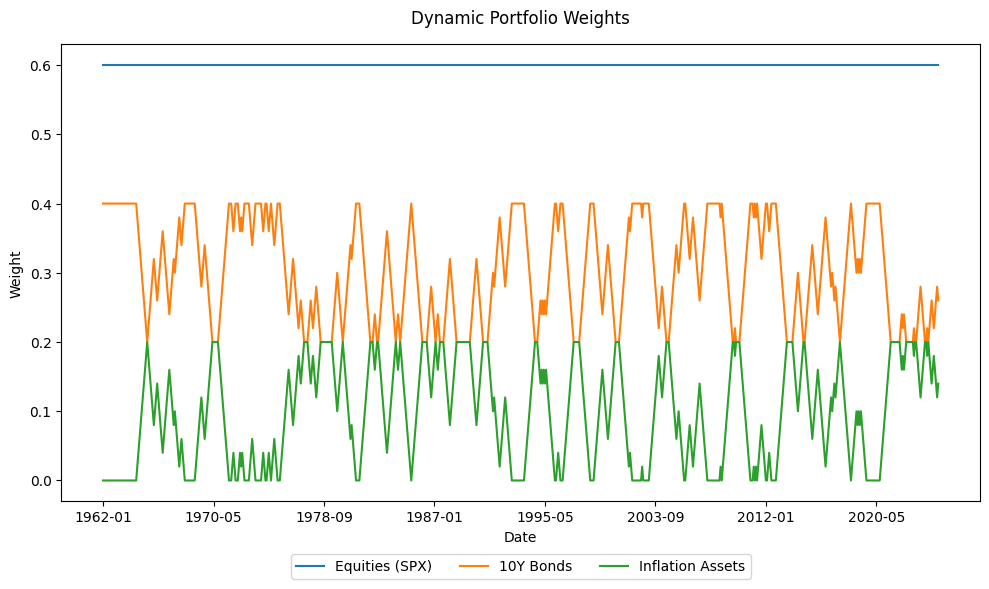

In [ ]:
dynamic_data = excess_return_mom_nomask[["BCOM Index", "XAU BGN Curncy", "SPX Index", 'tips_10y_return', '10y_returns']].dropna(thresh=5)

weights = {
    "SPX Index": 0.6,  # 60% equities
    "10y_returns": 0.4,  # 40% bonds
    "BCOM Index": 0.0  # 0% commodities initially
}
max_bcom_allocation = 0.19  # 20%

# Correlations
rolling_6m_corr = dynamic_data["SPX Index"].rolling(6).corr(dynamic_data["10y_returns"])
rolling_2y_corr = dynamic_data["SPX Index"].rolling(24).corr(dynamic_data["10y_returns"])

# Weights
weights_df = pd.DataFrame(index=dynamic_data.index, columns=weights.keys())
weights_df.iloc[0] = weights  # Set initial weights

# Loop
for i in range(1, len(dynamic_data)):
    
    current_6m_corr = rolling_6m_corr.iloc[i]
    current_2y_corr = rolling_2y_corr.iloc[i]

    prev_weights = weights_df.iloc[i - 1].copy()

    # Check
    if current_6m_corr > current_2y_corr:
        # Allocate 2% from bonds 
        if prev_weights["BCOM Index"] < max_bcom_allocation:
            prev_weights["BCOM Index"] += 0.02
            prev_weights["10y_returns"] -= 0.02
    elif current_6m_corr < current_2y_corr:
        # Reallocate 2% back to bonds 
        if prev_weights["BCOM Index"] > 0.0:
            prev_weights["BCOM Index"] -= 0.02
            prev_weights["10y_returns"] += 0.02

    # Update weights in the DataFrame
    weights_df.iloc[i] = prev_weights

# Calculate portfolio returns based on dynamic weights
weights_df["dynanic_pf_returns"] = (
    weights_df["SPX Index"] * asset_port_df["SPX Index"].pct_change(1) +
    weights_df["10y_returns"] * asset_port_df["10y_returns"] +
    weights_df["BCOM Index"] * asset_port_df["BCOM Index"].pct_change(1)
)

combined_data['dynamic_pf_returns'] = weights_df["dynanic_pf_returns"]


# Name legends
legend_mapping = {
    "SPX Index": "Equities (SPX)",
    "10y_returns": "10Y Bonds",
    "BCOM Index": "Inflation Assets"
}
plot_data = weights_df[["SPX Index", "10y_returns", "BCOM Index"]].rename(columns=legend_mapping)

fig, ax = plt.subplots(figsize=(10, 6))
plot_data.plot(ax=ax)
# Set title and labels
ax.set_title("Dynamic Portfolio Weights", pad=15)
ax.set_ylabel("Weight")
ax.set_xlabel("Date")

# Legend in bottom
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=3  # Number of columns for horizontal layout
)

plt.savefig("dynamic_portfolio_weights.eps", bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()


## Dynamic with mean variance

In [ ]:
dynamic_data = excess_return_mom_nomask[["SPX Index",'10y_returns']]
dynamic_data = (dynamic_data.join(combined_data['recession_mean_variance'], how="inner")).dropna(thresh=3)

weights = {
    "SPX Index": 0.6,  # 60% equities
    "10y_returns": 0.4,  # 40% bonds
    "recession_mean_variance": 0.0  # 0% commodities initially
}
max_bcom_allocation = 0.19  # 20%

# Correlations
rolling_6m_corr = dynamic_data["SPX Index"].rolling(6).corr(dynamic_data["10y_returns"])
rolling_2y_corr = dynamic_data["SPX Index"].rolling(24).corr(dynamic_data["10y_returns"])

# Weights
weights_df = pd.DataFrame(index=dynamic_data.index, columns=weights.keys())
weights_df.iloc[0] = weights  # Set initial weights

# Loop
for i in range(1, len(dynamic_data)):
    
    current_6m_corr = rolling_6m_corr.iloc[i]
    current_2y_corr = rolling_2y_corr.iloc[i]

    prev_weights = weights_df.iloc[i - 1].copy()

    # Check
    if current_6m_corr > current_2y_corr:
        # Allocate 2% from bonds 
        if prev_weights["recession_mean_variance"] < max_bcom_allocation:
            prev_weights["recession_mean_variance"] += 0.02
            prev_weights["10y_returns"] -= 0.02
    elif current_6m_corr < current_2y_corr:
        # Reallocate 2% back to bonds 
        if prev_weights["recession_mean_variance"] > 0.0:
            prev_weights["recession_mean_variance"] -= 0.02
            prev_weights["10y_returns"] += 0.02

    # Update weights in the DataFrame
    weights_df.iloc[i] = prev_weights

# Calculate portfolio returns based on dynamic weights
weights_df["dynanic_pf_returns"] = (
    weights_df["SPX Index"] * asset_port_df["SPX Index"].pct_change(1) +
    weights_df["10y_returns"] * asset_port_df["10y_returns"] +
    weights_df["recession_mean_variance"] * combined_data["recession_mean_variance"]
)

combined_data['dynamic_pf_mean_var_addition'] = weights_df["dynanic_pf_returns"]

# Plot the portfolio weights over time
# weights_df[["SPX Index", "10y_returns", "recession_mean_variance"]].plot(figsize=(12, 6), title="Portfolio Weights")
# plt.show()

## Dynamic with minimum shortfall

In [ ]:
dynamic_data = excess_return_mom_nomask[["SPX Index",'10y_returns']]
dynamic_data = (dynamic_data.join(combined_data['recession_min_shortfall'], how="inner")).dropna(thresh=3)

weights = {
    "SPX Index": 0.6,  # 60% equities
    "10y_returns": 0.4,  # 40% bonds
    "recession_min_shortfall": 0.0  # 0% commodities initially
}
max_bcom_allocation = 0.19  # 20%

# Correlations
rolling_6m_corr = dynamic_data["SPX Index"].rolling(6).corr(dynamic_data["10y_returns"])
rolling_2y_corr = dynamic_data["SPX Index"].rolling(24).corr(dynamic_data["10y_returns"])

# Weights
weights_df = pd.DataFrame(index=dynamic_data.index, columns=weights.keys())
weights_df.iloc[0] = weights  # Set initial weights

# Loop
for i in range(1, len(dynamic_data)):
    
    current_6m_corr = rolling_6m_corr.iloc[i]
    current_2y_corr = rolling_2y_corr.iloc[i]

    prev_weights = weights_df.iloc[i - 1].copy()

    # Check
    if current_6m_corr > current_2y_corr:
        # Allocate 2% from bonds 
        if prev_weights["recession_min_shortfall"] < max_bcom_allocation:
            prev_weights["recession_min_shortfall"] += 0.02
            prev_weights["10y_returns"] -= 0.02
    elif current_6m_corr < current_2y_corr:
        # Reallocate 2% back to bonds 
        if prev_weights["recession_min_shortfall"] > 0.0:
            prev_weights["recession_min_shortfall"] -= 0.02
            prev_weights["10y_returns"] += 0.02

    # Update weights in the DataFrame
    weights_df.iloc[i] = prev_weights

# Calculate portfolio returns based on dynamic weights
weights_df["dynanic_pf_returns"] = (
    weights_df["SPX Index"] * asset_port_df["SPX Index"].pct_change(1) +
    weights_df["10y_returns"] * asset_port_df["10y_returns"] +
    weights_df["recession_min_shortfall"] * combined_data["recession_min_shortfall"]
)

combined_data['dynamic_pf_min_short_addition'] = weights_df["dynanic_pf_returns"]

# Plot the portfolio weights over time
# weights_df[["SPX Index", "10y_returns", "recession_min_shortfall"]].plot(figsize=(12, 6), title="Portfolio Weights")
# plt.show()

## Dynamic with minimum variance

In [ ]:
dynamic_data = excess_return_mom_nomask[["SPX Index",'10y_returns']]
dynamic_data = (dynamic_data.join(combined_data['recession_min_variance'], how="inner")).dropna(thresh=3)

weights = {
    "SPX Index": 0.6,  # 60% equities
    "10y_returns": 0.4,  # 40% bonds
    "recession_min_variance": 0.0  # 0% commodities initially
}
max_bcom_allocation = 0.19  # 20%

# Correlations
rolling_6m_corr = dynamic_data["SPX Index"].rolling(6).corr(dynamic_data["10y_returns"])
rolling_2y_corr = dynamic_data["SPX Index"].rolling(24).corr(dynamic_data["10y_returns"])

# Weights
weights_df = pd.DataFrame(index=dynamic_data.index, columns=weights.keys())
weights_df.iloc[0] = weights  # Set initial weights

# Loop
for i in range(1, len(dynamic_data)):
    
    current_6m_corr = rolling_6m_corr.iloc[i]
    current_2y_corr = rolling_2y_corr.iloc[i]

    prev_weights = weights_df.iloc[i - 1].copy()

    # Check
    if current_6m_corr > current_2y_corr:
        # Allocate 2% from bonds 
        if prev_weights["recession_min_variance"] < max_bcom_allocation:
            prev_weights["recession_min_variance"] += 0.02
            prev_weights["10y_returns"] -= 0.02
    elif current_6m_corr < current_2y_corr:
        # Reallocate 2% back to bonds 
        if prev_weights["recession_min_variance"] > 0.0:
            prev_weights["recession_min_variance"] -= 0.02
            prev_weights["10y_returns"] += 0.02

    # Update weights in the DataFrame
    weights_df.iloc[i] = prev_weights

# Calculate portfolio returns based on dynamic weights
weights_df["dynanic_pf_returns"] = (
    weights_df["SPX Index"] * asset_port_df["SPX Index"].pct_change(1) +
    weights_df["10y_returns"] * asset_port_df["10y_returns"] +
    weights_df["recession_min_variance"] * combined_data["recession_min_variance"]
)

combined_data['dynamic_pf_min_var_addition'] = weights_df["dynanic_pf_returns"]

# Plot the portfolio weights over time
# weights_df[["SPX Index", "10y_returns", "recession_min_shortfall"]].plot(figsize=(12, 6), title="Portfolio Weights")
# plt.show()

# Overlay portfolios

#### Optimize overlays on 60/40 portfolio with a constraint at 8 % leverage

In [ ]:
overlay_to_6040 = pd.DataFrame()
# overlay_to_6040['6040_excess_return'] = excess_return_mom_nomask['return_6040']
overlay_to_6040['6040_excess_return'] = excess_return_mom['return_6040']
overlay_to_6040['meanvar_overlay_return'] = combined_data['recession_mean_variance']
overlay_to_6040['minvar_overlay_return'] = combined_data['recession_min_variance']
overlay_to_6040['minshort_overlay_return'] = combined_data['recession_min_shortfall']

overlay_to_6040['meanvar_overlay_return_excess'] = overlay_to_6040['meanvar_overlay_return'] - combined_data['US3M_approx']
overlay_to_6040['minvar_overlay_return_excess'] = overlay_to_6040['minvar_overlay_return'] - combined_data['US3M_approx']
overlay_to_6040['minshort_overlay_return_excess'] = overlay_to_6040['minshort_overlay_return'] - combined_data['US3M_approx']

overlay_meanvar_to_6040 = overlay_to_6040[['6040_excess_return','meanvar_overlay_return_excess']].dropna(thresh=2)

threshold = 0.03 / 12  # Monthly shortfall threshold

Sigma = overlay_meanvar_to_6040.cov() 
mu = overlay_meanvar_to_6040.mean()
weights = np.array([1, 0.0])

def optim_func(weights):
    pf_sigma = weights.T @ Sigma @ weights
    pf_mu = weights.T @ mu
    pf_sr = pf_mu/pf_sigma
    return -pf_sr

cons = [
    {'type': 'ineq', 'fun': lambda x: 1.08-np.sum(x)},
    {'type': 'ineq', 'fun': lambda x:  np.sum(x)-1.0},
    {'type': 'eq', 'fun': lambda x: x[0] - 1},
    {'type': 'ineq', 'fun': lambda x: x[1]}
    ]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})


weights_optim = np.append(res.x , 1-np.sum(res.x)) 

combined_data['overlay_meanvar'] = asset_port_df['return_6040'] * weights_optim[0] + combined_data['recession_mean_variance'] * weights_optim[1] + combined_data['US3M_approx'] * weights_optim[2]
print("Weights", weights_optim)

overlay_minvar_to_6040 = overlay_to_6040[['6040_excess_return','minvar_overlay_return_excess']].dropna(thresh=2)

Sigma = overlay_minvar_to_6040.cov() 
mu = overlay_minvar_to_6040.mean()
weights = np.array([1, 0.0])


res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})


weights_optim = np.append(res.x , 1-np.sum(res.x)) 
combined_data['overlay_minvar'] = asset_port_df['return_6040'] * weights_optim[0] + combined_data['recession_min_variance'] * weights_optim[1] + combined_data['US3M_approx'] * weights_optim[2]
print("Weights", weights_optim)

overlay_minshort_to_6040 = overlay_to_6040[['6040_excess_return','minshort_overlay_return_excess']].dropna(thresh=2)

Sigma = overlay_minshort_to_6040.cov() 
mu = overlay_minshort_to_6040.mean()
weights = np.array([1, 0.0])


res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})


weights_optim = np.append(res.x , 1-np.sum(res.x)) 
combined_data['overlay_minshort'] = asset_port_df['return_6040'] * weights_optim[0] + combined_data['recession_min_shortfall'] * weights_optim[1] + combined_data['US3M_approx'] * weights_optim[2]
print("Weights", weights_optim)

Weights [ 1.    0.08 -0.08]
Weights [ 1.    0.08 -0.08]
Weights [ 1.    0.08 -0.08]


### Try with 100 % leverage to see if the results get interesting

In [ ]:
Sigma = overlay_meanvar_to_6040.cov() 
mu = overlay_meanvar_to_6040.mean()
weights = np.array([1, 0.0])

def optim_func(weights):
    pf_sigma = weights.T @ Sigma @ weights
    pf_mu = weights.T @ mu
    pf_sr = pf_mu/pf_sigma
    return -pf_sr

cons = [
    {'type': 'ineq', 'fun': lambda x: 2-np.sum(x)},
    {'type': 'ineq', 'fun': lambda x:  np.sum(x)-1.0},
    {'type': 'eq', 'fun': lambda x: x[0] - 1},
    {'type': 'ineq', 'fun': lambda x: x[1]}
    ]

res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})


weights_optim = np.append(res.x , 1-np.sum(res.x)) 

combined_data['nocap_overlay_meanvar'] = asset_port_df['return_6040'] * weights_optim[0] + combined_data['recession_mean_variance'] * weights_optim[1] + combined_data['US3M_approx'] * weights_optim[2]
print("Weights", weights_optim)

overlay_minvar_to_6040 = overlay_to_6040[['6040_excess_return','minvar_overlay_return_excess']].dropna(thresh=2)

Sigma = overlay_minvar_to_6040.cov() 
mu = overlay_minvar_to_6040.mean()
weights = np.array([1, 0.0])


res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})


weights_optim = np.append(res.x , 1-np.sum(res.x)) 
combined_data['nocap_overlay_minvar'] = asset_port_df['return_6040'] * weights_optim[0] + combined_data['recession_min_variance'] * weights_optim[1] + combined_data['US3M_approx'] * weights_optim[2]
print("Weights", weights_optim)

overlay_minshort_to_6040 = overlay_to_6040[['6040_excess_return','minshort_overlay_return_excess']].dropna(thresh=2)

Sigma = overlay_minshort_to_6040.cov() 
mu = overlay_minshort_to_6040.mean()
weights = np.array([1, 0.0])


res = scipy.optimize.minimize(x0=weights, 
                              fun=optim_func,
                              constraints=cons,
                              method='SLSQP',
                              options={'ftol': 1e-15})


weights_optim = np.append(res.x , 1-np.sum(res.x)) 
combined_data['nocap_overlay_minshort'] = asset_port_df['return_6040'] * weights_optim[0] + combined_data['recession_min_shortfall'] * weights_optim[1] + combined_data['US3M_approx'] * weights_optim[2]
print("Weights", weights_optim)

Weights [ 1.      0.3529 -0.3529]
Weights [ 1.      0.3084 -0.3084]
Weights [ 1.      0.2049 -0.2049]


In [ ]:
# # Overlay using minimum shortfal

# threshold = 0.015 / 12  # Monthly shortfall threshold

# # Define a function to optimize and apply for each overlay
# def optimize_overlay_weight(overlay_name):
#     overlay_series = overlay_to_6040[f'{overlay_name}_overlay_return']
#     base_series = excess_return_mom['return_6040']
#     rf_series = combined_data['US3M_approx']

#     # Align data
#     returns_df = pd.DataFrame({
#         '6040': base_series,
#         'overlay': overlay_series,
#         'rf': rf_series
#     }).dropna()

#     def optim_func(x):
#         portfolio_return = (
#             returns_df['6040'] * 1.0 +
#             returns_df['overlay'] * x +
#             returns_df['rf'] * (-x)
#         )
#         return np.mean(portfolio_return < threshold)

#     # Optimize overlay weight
#     opt_result = scipy.optimize.brute(
#         func=optim_func,
#         ranges=[(0, 1)],
#         Ns=100,
#         full_output=False,
#         finish=None,
#         workers=1
#     )

#     overlay_weight = opt_result
#     rf_weight = -overlay_weight
#     weights = [1.0, overlay_weight, rf_weight]

#     # Print results
#     print(f"\n--- {overlay_name.upper()} Overlay Optimization ---")
#     print(f"Overlay weight       : {overlay_weight:.4f}")
#     print(f"Risk-free weight     : {rf_weight:.4f}")
#     print(f"Shortfall probability: {optim_func(overlay_weight):.2%}")
#     print(f"Weights (6040, Overlay, RF): {weights}")

#     # Apply to full period (using _nomask return series)
#     overlay_full = asset_port_df[['BCOM Index', 'XAU BGN Curncy']].pct_change(1) @ globals()[f'{overlay_name}_overlay_weights'][0:2] \
#                     + asset_port_df['tips_10y_return'] * globals()[f'{overlay_name}_overlay_weights'][2]

#     combined_data[f'overlay_{overlay_name}'] = (
#         combined_data['return_6040'] * weights[0] +
#         overlay_full * weights[1] +
#         combined_data['US3M_approx'] * weights[2]
#     )

# # Run for all three overlays
# for name in ['meanvar', 'minvar', 'minshort']:
#     optimize_overlay_weight(name)

# # Compute cumulative returns
# plot_df = pd.DataFrame({
#     '60/40': (1 + combined_data['return_6040']).cumprod(),
#     'Overlay Mean-Var': (1 + combined_data['nocap_overlay_meanvar']).cumprod(),
#     'Overlay Min-Var': (1 + combined_data['nocap_overlay_minvar']).cumprod(),
#     'Overlay Min-Shortfall': (1 + combined_data['nocap_overlay_minshort']).cumprod()
# }).dropna()

## Visualization and Performance

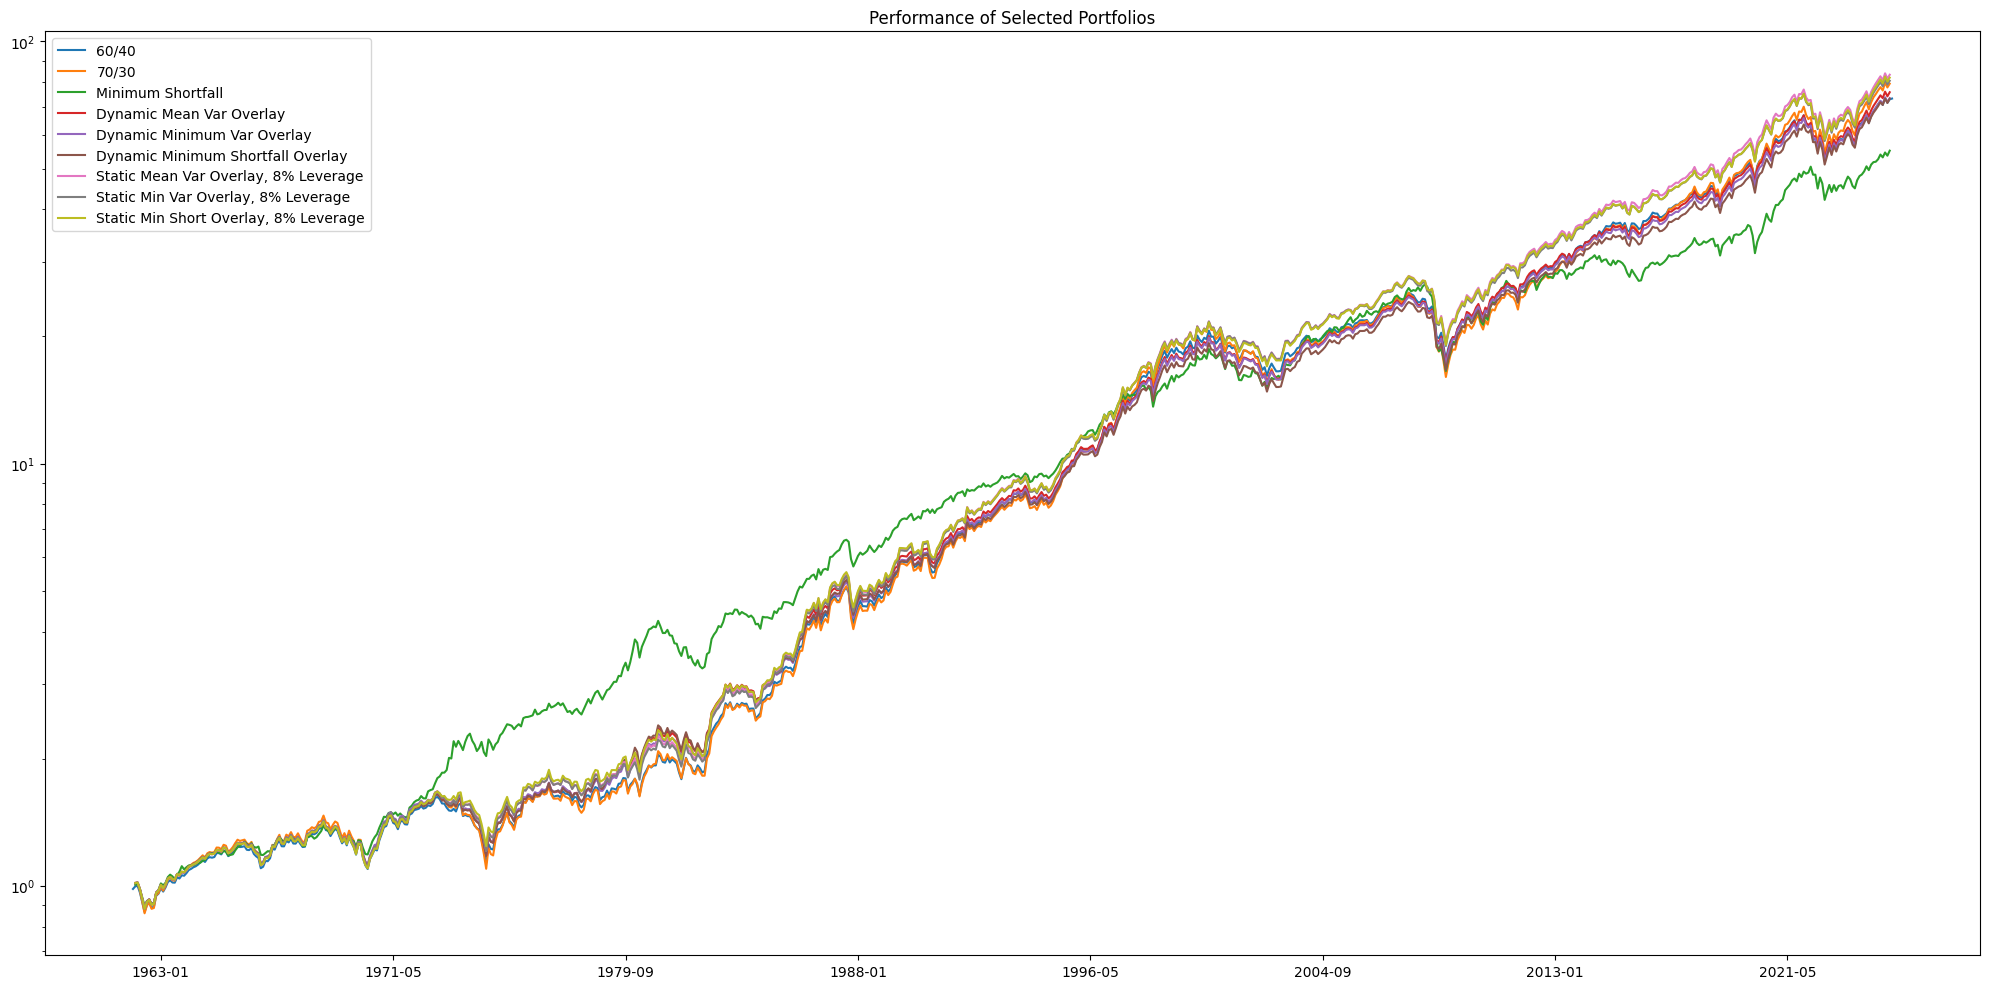

In [ ]:
# Visualization
returns_portfolios = pd.DataFrame()

fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=True)
returns_portfolios['60/40'] = (combined_data['return_6040'] + 1).cumprod()
returns_portfolios['70/30'] = (combined_data['return_7030'] + 1).cumprod()
# returns_portfolios['76.5 % 60/40 and 23.5 % Comm'] = (combined_data['6040_235comm'] + 1).cumprod()
# returns_portfolios['Mean Variance'] = (combined_data['mean_var_portfolio_gold_TIPS'] + 1).cumprod()
# returns_portfolios['Minimum Variance'] = (combined_data['min_var_portfolio'] + 1).cumprod()
returns_portfolios['Minimum Shortfall'] = (combined_data['min_shortfall_portfolio_empirical'] + 1).cumprod()
# returns_portfolios['Dynamic Commodity Overlay'] = (combined_data['dynamic_pf_returns'] + 1).cumprod()
returns_portfolios['Dynamic Mean Var Overlay'] = (combined_data['dynamic_pf_mean_var_addition'] + 1).cumprod()
returns_portfolios['Dynamic Minimum Var Overlay'] = (combined_data['dynamic_pf_min_var_addition'] + 1).cumprod()
returns_portfolios['Dynamic Minimum Shortfall Overlay'] = (combined_data['dynamic_pf_min_short_addition'] + 1).cumprod()
# returns_portfolios['Mean Var addition to dynamic (60/40 DD)'] = (combined_data['dynamic_pf_mean_var_addition_6040_dd'] + 1).cumprod()

returns_portfolios[r'Static Mean Var Overlay, 8% Leverage'] = (combined_data['overlay_meanvar'] + 1).cumprod() #delete
returns_portfolios[r'Static Min Var Overlay, 8% Leverage'] = (combined_data['overlay_minvar'] + 1).cumprod() #delete
returns_portfolios[r'Static Min Short Overlay, 8% Leverage'] = (combined_data['overlay_minshort'] + 1).cumprod() #delete

# returns_portfolios['Static Mean Var Overlay, Uncapped'] = (combined_data['nocap_overlay_meanvar'] + 1).cumprod() #delete
# returns_portfolios['Static Min Var Overlay, Uncapped'] = (combined_data['nocap_overlay_minvar'] + 1).cumprod() #delete
# returns_portfolios['Static Min Short Overlay, Uncapped'] = (combined_data['nocap_overlay_minshort'] + 1).cumprod() #delete

# returns_portfolios['Mean Var infl and recession periods'] = (combined_data['recession_mean_variance'] + 1).cumprod()
# returns_portfolios['Minimum Shortfall infl and recession periods'] = (combined_data['recession_min_shortfall'] + 1).cumprod()


returns_portfolios.plot(ax=ax, logy=True)
ax.set_title('Performance of Selected Portfolios')
ax.legend()

# plt.savefig("portperformance_all.eps", bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

#### Portolio evaluation whole period

In [ ]:
# portfolio_data = combined_data[['return_6040','return_7030','mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 'dynamic_pf_min_var_addition',
#                                 'min_shortfall_portfolio_empirical','6040_235comm', 'dynamic_pf_min_short_addition', 'dynamic_pf_mean_var_addition', 'overlay_1', 'overlay_2', 'overlay_3', 'dynamic_pf_mean_var_addition_6040_dd']]
portfolio_data = combined_data[['return_6040', 'return_7030', 'dynamic_pf_returns', 'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
                                'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
                                'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort']]
inflation = combined_data[['YoYCPI']]

mask = pd.to_datetime(portfolio_data.index, format='%Y-%m') < '2021-01-01'
portfolio_data = portfolio_data[mask]
# portfolio_data.dropna()

# Calculate raw stats
portStats = pd.DataFrame()
portStats['Min'] = portfolio_data.min()
portStats['Max'] = portfolio_data.max()
portStats['Mean'] = portfolio_data.mean()
portStats['Std'] = portfolio_data.std()
portStats['SR'] = portStats['Mean'] / portStats['Std']
portStats['Skew'] = portfolio_data.skew()
portStats['Kurtosis'] = portfolio_data.kurtosis()
portStats["VaR at 5 % CI"] = portfolio_data.apply(lambda x: port_VaR(x))
portStats["CVaR at 5 % CI"] = portfolio_data.apply(lambda x: port_cVaR(x))
portStats["Max DD"] = portfolio_data.apply(lambda x: port_max_drawdown(x))
portStats["Sortino Ratio"] = portfolio_data.apply(lambda x: port_sortino_ratio(x))

# Annualize
portStats['Annualized Mean'] = portStats['Mean'] * 12
portStats['Annualized Std'] = portStats['Std'] * np.sqrt(12)
portStats['Annualized SR'] = portStats['SR'] * np.sqrt(12)
portStats['Annualized Sortino'] = portStats["Sortino Ratio"] * np.sqrt(12)

# cols_order = [
#     'Min', 'Max', 'Mean', 'Std', 'SR', 'Sortino Ratio', 'Annualized Mean',
#     'Annualized Std', 'Annualized SR', 'Annualized Sortino',
#     'Skew', 'Kurtosis', 'VaR at 5 % CI', 'CVaR at 5 % CI', 'Max DD'
# ]
cols_order = [
    'Annualized Mean', 'Annualized Std', 'Annualized SR', 'Annualized Sortino',
    'CVaR at 5 % CI', 'Max DD'
]
portStats = portStats[cols_order]

# Sort portfolios by Sharpe (or any other column)
portStats.sort_values("Annualized SR")

C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Annualized Mean Annualized Std  \
return_7030                              0.075555       0.108456   
dynamic_pf_returns                       0.070061       0.095013   
min_shortfall_portfolio_empirical        0.067176       0.089114   
return_6040                              0.073901       0.096665   
dynamic_pf_min_short_addition             0.07262       0.094491   
dynamic_pf_min_var_addition              0.073189       0.094138   
overlay_minvar                           0.075963       0.097669   
overlay_minshort                         0.076006       0.097716   
dynamic_pf_mean_var_addition             0.073562       0.094285   
nocap_overlay_minshort                    0.07865       0.100753   
overlay_meanvar                          0.076445       0.097651   
nocap_overlay_minvar                     0.080675       0.102771   
nocap_overlay_meanvar                     0.08372       0.104688   
min_var_portfolio                        0.065361       0.058644   
mean_var_portfolio_gold_TIPS             0.070607       0.061714   

                                  Annualized SR  Annualized Sortino  \
return_7030                            0.696639            1.107893   
dynamic_pf_returns                     0.737381            1.185626   
min_shortfall_portfolio_empirical      0.753823            1.188520   
return_6040                            0.764504            1.251998   
dynamic_pf_min_short_addition          0.768541            1.251654   
dynamic_pf_min_var_addition            0.777458            1.271097   
overlay_minvar                         0.777757            1.277453   
overlay_minshort                       0.777825            1.272847   
dynamic_pf_mean_var_addition           0.780207            1.277378   
nocap_overlay_minshort                 0.780627            1.272660   
overlay_meanvar                        0.782835            1.286869   
nocap_overlay_minvar                   0.784996            1.292676   
nocap_overlay_meanvar                  0.799709            1.324270   
min_var_portfolio                      1.114537            2.038489   
mean_var_portfolio_gold_TIPS           1.144117            2.169303   

                                   CVaR at 5 % CI    Max DD  
return_7030                             -0.066234 -0.368503  
dynamic_pf_returns                      -0.056814 -0.322863  
min_shortfall_portfolio_empirical       -0.053896 -0.376039  
return_6040                             -0.057265 -0.307146  
dynamic_pf_min_short_addition           -0.055751 -0.309684  
dynamic_pf_min_var_addition             -0.055905 -0.308870  
overlay_minvar                          -0.057511 -0.311118  
overlay_minshort                        -0.057448 -0.312429  
dynamic_pf_mean_var_addition            -0.055666 -0.306033  
nocap_overlay_minshort                  -0.058751 -0.321100  
overlay_meanvar                         -0.057398 -0.305870  
nocap_overlay_minvar                    -0.060039 -0.323209  
nocap_overlay_meanvar                   -0.060412 -0.303152  
min_var_portfolio                       -0.032386 -0.141120  
mean_var_portfolio_gold_TIPS            -0.032996 -0.132349

In [ ]:
portfolio_data = combined_data[['return_6040', 'return_7030', 'dynamic_pf_returns', 
                                'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
                                'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort']] #'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
monthly_inflation = combined_data[['MoMCPI']]
monthly_inflation = monthly_inflation.loc[portfolio_data.index]

mask = pd.to_datetime(portfolio_data.index, format='%Y-%m') < '2021-01-01'
portfolio_data = portfolio_data[mask]
# portfolio_data.dropna()

# Calculate raw stats
portStats = pd.DataFrame()
portStats['Min'] = portfolio_data.min()
portStats['Max'] = portfolio_data.max()
portStats['Mean'] = portfolio_data.mean()
portStats['Std'] = portfolio_data.std()
portStats['SR'] = portStats['Mean'] / portStats['Std']
portStats['Skew'] = portfolio_data.skew()
portStats['Kurtosis'] = portfolio_data.kurtosis()
portStats["VaR at 5 % CI"] = portfolio_data.apply(lambda x: port_VaR(x))
portStats["CVaR at 5 % CI"] = portfolio_data.apply(lambda x: port_cVaR(x))
portStats["Max DD"] = portfolio_data.apply(lambda x: port_max_drawdown(x))
portStats["Sortino Ratio"] = portfolio_data.apply(lambda x: port_sortino_ratio(x))

# Real return stats (per portfolio)
def real_return_stats(series):
    aligned = pd.concat([series, monthly_inflation], axis=1).dropna()
    nominal = aligned.iloc[:, 0]
    infl = aligned.iloc[:, 1]
    real_returns = (1 + nominal) / (1 + infl) - 1
    return pd.Series({
        'Real Annualized Mean': real_returns.mean(),
        'Real Annualized SR': real_returns.mean() / real_returns.std() if real_returns.std() != 0 else np.nan,
        'Real Max DD': port_max_drawdown(real_returns),
        'Real CVaR': port_cVaR(real_returns)
    })

real_stats = portfolio_data.apply(real_return_stats).T

# Combine nominal and real stats
portStats = pd.concat([portStats, real_stats], axis=1)

# Annualize
portStats['Annualized Mean'] = portStats['Mean'] * 12
portStats['Annualized Std'] = portStats['Std'] * np.sqrt(12)
portStats['Annualized SR'] = portStats['SR'] * np.sqrt(12)
portStats['Annualized Sortino'] = portStats["Sortino Ratio"] * np.sqrt(12)

# Optional: reorder columns
cols_order = [
    'Annualized Mean', 'Annualized Std', 'Annualized SR', 'Annualized Sortino',
    'CVaR at 5 % CI', 'Max DD', 'Real Annualized SR', 'Real Annualized Mean', 'Real Max DD', 'Real CVaR'
]
portStats = portStats[cols_order]

# Sort by Sharpe
portStats.sort_values("Annualized SR")

C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Annualized Mean Annualized Std  \
return_7030                              0.075555       0.108456   
dynamic_pf_returns                       0.070061       0.095013   
min_shortfall_portfolio_empirical        0.067176       0.089114   
return_6040                              0.073901       0.096665   
dynamic_pf_min_short_addition             0.07262       0.094491   
dynamic_pf_min_var_addition              0.073189       0.094138   
overlay_minvar                           0.075963       0.097669   
overlay_minshort                         0.076006       0.097716   
dynamic_pf_mean_var_addition             0.073562       0.094285   
nocap_overlay_minshort                    0.07865       0.100753   
overlay_meanvar                          0.076445       0.097651   
nocap_overlay_minvar                     0.080675       0.102771   
nocap_overlay_meanvar                     0.08372       0.104688   

                                  Annualized SR  Annualized Sortino  \
return_7030                            0.696639            1.107893   
dynamic_pf_returns                     0.737381            1.185626   
min_shortfall_portfolio_empirical      0.753823            1.188520   
return_6040                            0.764504            1.251998   
dynamic_pf_min_short_addition          0.768541            1.251654   
dynamic_pf_min_var_addition            0.777458            1.271097   
overlay_minvar                         0.777757            1.277453   
overlay_minshort                       0.777825            1.272847   
dynamic_pf_mean_var_addition           0.780207            1.277378   
nocap_overlay_minshort                 0.780627            1.272660   
overlay_meanvar                        0.782835            1.286869   
nocap_overlay_minvar                   0.784996            1.292676   
nocap_overlay_meanvar                  0.799709            1.324270   

                                   CVaR at 5 % CI    Max DD  \
return_7030                             -0.066234 -0.368503   
dynamic_pf_returns                      -0.056814 -0.322863   
min_shortfall_portfolio_empirical       -0.053896 -0.376039   
return_6040                             -0.057265 -0.307146   
dynamic_pf_min_short_addition           -0.055751 -0.309684   
dynamic_pf_min_var_addition             -0.055905 -0.308870   
overlay_minvar                          -0.057511 -0.311118   
overlay_minshort                        -0.057448 -0.312429   
dynamic_pf_mean_var_addition            -0.055666 -0.306033   
nocap_overlay_minshort                  -0.058751 -0.321100   
overlay_meanvar                         -0.057398 -0.305870   
nocap_overlay_minvar                    -0.060039 -0.323209   
nocap_overlay_meanvar                   -0.060412 -0.303152   

                                   Real Annualized SR  Real Annualized Mean  \
return_7030                                  0.101983              0.003243   
dynamic_pf_returns                           0.099760              0.002784   
min_shortfall_portfolio_empirical            0.098098              0.002533   
return_6040                                  0.109251              0.003110   
dynamic_pf_min_short_addition                0.107969              0.002996   
dynamic_pf_min_var_addition                  0.110028              0.003044   
overlay_minvar                               0.114061              0.003276   
overlay_minshort                             0.114160              0.003280   
dynamic_pf_mean_var_addition                 0.111003              0.003075   
nocap_overlay_minshort                       0.118463              0.003497   
overlay_meanvar                              0.115477              0.003316   
nocap_overlay_minvar                         0.121846              0.003665   
nocap_overlay_meanvar                        0.128011              0.003918   

                                   Real Max DD  Real CVaR  
return_7030                         

### Portfolio evaluation in inflation periods

In [ ]:
portfolio_data = combined_data[['return_6040', 'return_7030', 'dynamic_pf_returns', 'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
                                'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
                                'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort']]

# Extract relevant periods based on inflation events
portfolio_data_10_worst_infl = pd.concat(
    [portfolio_data.loc[start:end] for _, start, end in date_intervals[2:]]
)

monthly_inflation_10_worst_infl = pd.concat(
    [monthly_inflation.loc[start:end] for _, start, end in date_intervals[2:]]
)

# Real return stats (per portfolio)
def real_return_stats(series):
    aligned = pd.concat([series, monthly_inflation_10_worst_infl], axis=1).dropna()
    nominal = aligned.iloc[:, 0]
    infl = aligned.iloc[:, 1]
    real_returns = (1 + nominal) / (1 + infl) - 1
    real_annual_mean = real_returns.mean() * 12
    real_annual_std = real_returns.std() * np.sqrt(12)
    real_annual_sr = real_annual_mean / real_annual_std if real_annual_std != 0 else np.nan
    return pd.Series({
        'Real Annualized Mean': real_annual_mean,
        'Real Annualized SR': real_annual_sr,
        'Real Max DD': port_max_drawdown(real_returns),
        'Real CVaR': port_cVaR(real_returns)
    })

# Calculate stats and store in a *separate* DataFrame
portStats_10_worst_infl = pd.DataFrame()
portStats_10_worst_infl['Min'] = portfolio_data_10_worst_infl.min()
portStats_10_worst_infl['Max'] = portfolio_data_10_worst_infl.max()
portStats_10_worst_infl['Mean'] = portfolio_data_10_worst_infl.mean()
portStats_10_worst_infl['Std'] = portfolio_data_10_worst_infl.std()
portStats_10_worst_infl['SR'] = portStats_10_worst_infl['Mean'] / portStats_10_worst_infl['Std']
portStats_10_worst_infl['Skew'] = portfolio_data_10_worst_infl.skew()
portStats_10_worst_infl['Kurtosis'] = portfolio_data_10_worst_infl.kurtosis()
portStats_10_worst_infl["VaR at 5 % CI"] = portfolio_data_10_worst_infl.apply(lambda x: port_VaR(x))
portStats_10_worst_infl["CVaR at 5 % CI"] = portfolio_data_10_worst_infl.apply(lambda x: port_cVaR(x))
portStats_10_worst_infl["Sortino Ratio"] = portfolio_data_10_worst_infl.apply(lambda x: port_sortino_ratio(x))

# Compute and merge real stats
real_stats = portfolio_data_10_worst_infl.apply(real_return_stats).T
portStats_10_worst_infl = pd.concat([portStats_10_worst_infl, real_stats], axis=1)

# Annualize
portStats_10_worst_infl['Annualized Mean'] = portStats_10_worst_infl['Mean'] * 12
portStats_10_worst_infl['Annualized Std'] = portStats_10_worst_infl['Std'] * np.sqrt(12)
portStats_10_worst_infl['Annualized SR'] = portStats_10_worst_infl['SR'] * np.sqrt(12)
portStats_10_worst_infl['Annualized Sortino'] = portStats_10_worst_infl["Sortino Ratio"] * np.sqrt(12)

# Reorder columns
# cols_order = [
#     'Min', 'Max', 'Mean', 'Std', 'SR', 'Sortino Ratio', 'Annualized Mean',
#     'Annualized Std', 'Annualized SR', 'Annualized Sortino',
#     'Skew', 'Kurtosis', 'VaR at 5 % CI', 'CVaR at 5 % CI', 'Max DD'
# ]
cols_order = [
    'Min', 'Max',
    'Annualized Mean', 'Annualized Std', 'Annualized SR', 'Annualized Sortino',
    'CVaR at 5 % CI', 
    'Real Annualized Mean', 'Real Annualized SR' , 'Real CVaR'#, 'Real Max DD'
]

portStats_10_worst_infl = portStats_10_worst_infl[cols_order]

# Sort portfolios
portStats_10_worst_infl.sort_values("Annualized SR")

Min       Max Annualized Mean  \
return_7030                       -0.135891   0.11922       -0.004037   
return_6040                       -0.108645  0.104611        0.003865   
overlay_minvar                    -0.115197  0.108412        0.006859   
overlay_meanvar                   -0.115276  0.108564        0.007943   
dynamic_pf_min_var_addition       -0.112165  0.105348        0.008199   
overlay_minshort                  -0.117689  0.107438        0.008693   
dynamic_pf_returns                -0.117608  0.104518        0.008557   
dynamic_pf_mean_var_addition      -0.112281  0.105386        0.009213   
dynamic_pf_min_short_addition     -0.114317  0.105104        0.009871   
nocap_overlay_minvar              -0.145367  0.119259        0.015403   
nocap_overlay_minshort            -0.138079  0.111852         0.01623   
nocap_overlay_meanvar             -0.151602  0.122047        0.021853   
min_shortfall_portfolio_empirical -0.158876  0.099016        0.036583   
mean_var_portfolio_gold_TIPS      -0.083409  0.114409        0.058875   
min_var_portfolio                 -0.081857  0.107519         0.05958   

                                  Annualized Std Annualized SR  \
return_7030                             0.125461     -0.032181   
return_6040                             0.111896      0.034545   
overlay_minvar                          0.113435      0.060464   
overlay_meanvar                         0.113554      0.069948   
dynamic_pf_min_var_addition              0.10931      0.075005   
overlay_minshort                        0.113523      0.076578   
dynamic_pf_returns                      0.110267      0.077599   
dynamic_pf_mean_var_addition            0.109848      0.083871   
dynamic_pf_min_short_addition           0.110218      0.089557   
nocap_overlay_minvar                    0.120912      0.127388   
nocap_overlay_minshort                  0.117996      0.137547   
nocap_overlay_meanvar                   0.124057      0.176149   
min_shortfall_portfolio_empirical       0.106876      0.342296   
mean_var_portfolio_gold_TIPS            0.074754      0.787582   
min_var_portfolio                        0.07117      0.837147   

                                   Annualized Sortino  CVaR at 5 % CI  \
return_7030                                 -0.044196       -0.081011   
return_6040                                  0.048758       -0.071184   
overlay_minvar                               0.085936       -0.071656   
overlay_meanvar                              0.099520       -0.071689   
dynamic_pf_min_var_addition                  0.105930       -0.069157   
overlay_minshort                             0.108664       -0.072353   
dynamic_pf_returns                           0.108432       -0.072921   
dynamic_pf_mean_var_addition                 0.118827       -0.069488   
dynamic_pf_min_short_addition                0.126601       -0.070824   
nocap_overlay_minvar                         0.184133       -0.075449   
nocap_overlay_minshort                       0.196669       -0.075026   
nocap_overlay_meanvar                        0.257224       -0.076534   
min_shortfall_portfolio_empirical            0.496488       -0.068078   
mean_var_portfolio_gold_TIPS                 1.413876       -0.041069   
min_var_portfolio                            1.458165       -0.041938   

                                   Real Annualized Mean  Real Annualized SR  \
return_7030                                   -0.062292           -0.491142   
return_6040                                   -0.054406           -0.478334   
overlay_minvar                                -0.051436           -0.446567   
overlay_meanvar                               -0.050357           -0.436783   
dynamic_pf_min_var_addition                   -0.050147           -0.452781   
overlay_minshort                              -0.049617           -0.430677   
dynamic_pf_returns                            -0.049796           -0.446126   
dynamic_pf_me

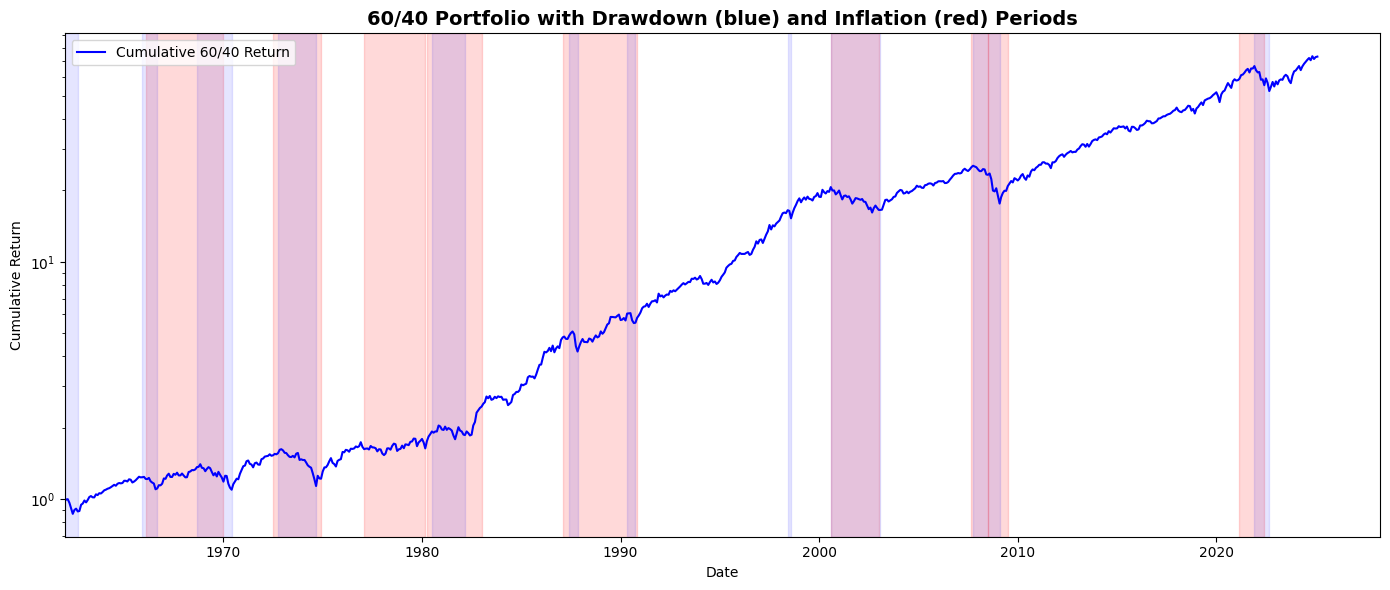

In [ ]:
# Compute cumulative return for 60/40
returns_6040 = (combined_data['return_6040'] + 1).cumprod()
returns_6040.index = pd.to_datetime(returns_6040.index)

# Filter data to start from 1962
returns_6040 = returns_6040[returns_6040.index >= "1962-01-01"]

# Set x-axis limits
start_date = pd.to_datetime("1962-01-01")
end_date = pd.to_datetime(returns_6040.index.max())

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
# Plot your data as before
ax.semilogy(returns_6040.index, returns_6040.values, label='Cumulative 60/40 Return', color='blue')
# ax.plot(returns_6040, label='60/40 Portfolio', color='black')

# Clip overlays to match visible range
for label, start, end in date_intervals:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    if end < start_date or start > end_date:
        continue
    ax.axvspan(max(start, start_date), min(end, end_date), color='red', alpha=0.15)

# Add drawdown overlays
for i, (_, start, end) in enumerate(worst_dd_6040):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    if end < start_date or start > end_date:
        continue
    ax.axvspan(max(start, start_date), min(end, end_date), color='blue', alpha=0.1)

# Final formatting
ax.set_xlim(left=start_date)
ax.set_title('60/40 Portfolio with Drawdown (blue) and Inflation (red) Periods', fontsize=14, weight='bold')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
plt.tight_layout()

# Optional: Save figure
plt.savefig("6040_drawdowns_infl.png", bbox_inches='tight', dpi=300)

plt.show()


#### Portfolio evaluation in defined periods and non-defined periods

In [ ]:
uncovered_periods = [
    ('Pre-WW2', '1900-01', '1946-02'),
    ('Post-WW2 to Recession', '1947-04', '1948-06'),
    ('Post-Recession to Bretton Woods', '1949-08', '1966-01'),
    ('Post-Bretton Woods to OPEC', '1970-02', '1972-06'),
    ('Post-OPEC to Iranian Revolution', '1975-01', '1977-01'),
    ('Post-Early 1980s Recession', '1983-02', '1987-01'),
    ('Post-Reagan Boom to Dot Com Bubble (Burst)', '1990-12', '2000-07'),
    ('Post-Dot Com Burst to China Demand Boom', "2003-02", '2007-08'),
    ('Post-Financial Crisis to Covid-19', '2009-08', '2020-04'),
    # ('Post-Covid-19', '2022-01', '2025-01')
]

portfolio_data = combined_data[['return_6040', 'return_7030', 'dynamic_pf_returns', 'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
                                'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
                                'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort']]


portfolio_data_periods = portfolio_data.copy()
portfolio_data_periods['Period'] = None
for label, start, end in date_intervals + uncovered_periods:
    portfolio_data_periods.loc[start:end, 'Period'] = label
    portfolio_data_periods.loc[start:end, 'Period Start'] = start
    portfolio_data_periods.loc[start:end, 'Period End'] = end

# Group by 'Period' and calculate metrics for each portfolio
metrics = []
for period, group in portfolio_data_periods.groupby('Period'):
    period_start = group['Period Start'].iloc[0]
    period_end = group['Period End'].iloc[0]
    period_metrics = {'Period': period, 'Period Start': period_start, 'Period End': period_end}
    for column in group.columns.drop(['Period', 'Period Start','Period End']):
        returns = group[column].dropna()
        period_metrics[column] = {
            'Mean': returns.mean(),
            'Std': returns.std(),
            'Sharpe Ratio': returns.mean() / returns.std() if returns.std() != 0 else np.nan,
            'Sortino Ratio': port_sortino_ratio(returns),
            'Annualized Mean': returns.mean()*12,
            'Annualized Std': returns.std() * np.sqrt(12),
            'Annualized Sharpe Ratio': (returns.mean() / returns.std()) * np.sqrt(12) if returns.std() != 0 else np.nan,
            'Annualized Sortino Ratio': port_sortino_ratio(returns) * np.sqrt(12),
            'Max Drawdown': port_max_drawdown(returns),
            # 'VaR': port_VaR(returns),
            'cVaR': port_cVaR(returns)
        }
    metrics.append(period_metrics)

# Convert metrics to a DataFrame for better visualization
results = pd.DataFrame(metrics)

# Set a multi-index with 'Period' and 'Period Start', and sort by 'Period Start'
results.set_index(['Period', 'Period Start', 'Period End'], inplace=True)
results.sort_index(level='Period Start', inplace=True)

C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  retur

In [ ]:
# Define periods
uncovered_periods = [
    ('Pre-WW2', '1900-01', '1946-02'),
    ('Post-WW2 to Recession', '1947-04', '1948-06'),
    ('Post-Recession to Bretton Woods', '1949-08', '1966-01'),
    ('Post-Bretton Woods to OPEC', '1970-02', '1972-06'),
    ('Post-OPEC to Iranian Revolution', '1975-01', '1977-01'),
    ('Post-Early 1980s Recession', '1983-02', '1987-01'),
    ('Post-Reagan Boom to Dot Com Bubble (Burst)', '1990-12', '2000-07'),
    ('Post-Dot Com Burst to China Demand Boom', "2003-02", '2007-08'),
    ('Post-Financial Crisis to Covid-19', '2009-08', '2020-04'),
    # ('Post-Covid-19', '2022-01', '2025-01')
]

portfolio_data = combined_data[[
    'return_6040', 'return_7030', 'dynamic_pf_returns', 'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
    'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
    'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 
    'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort'
]]

monthly_inflation = combined_data[['MoMCPI']]  # assumed to be in decimal form (e.g. 0.003)

# Add period labels
portfolio_data_periods = portfolio_data.copy()
portfolio_data_periods['Period'] = None
for label, start, end in date_intervals + uncovered_periods:
    portfolio_data_periods.loc[start:end, 'Period'] = label
    portfolio_data_periods.loc[start:end, 'Period Start'] = start
    portfolio_data_periods.loc[start:end, 'Period End'] = end

# Group by 'Period' and calculate metrics for each portfolio
metrics = []

for period, group in portfolio_data_periods.groupby('Period'):
    period_start = group['Period Start'].iloc[0]
    period_end = group['Period End'].iloc[0]
    period_metrics = {'Period': period, 'Period Start': period_start, 'Period End': period_end}
    
    # Slice inflation
    inflation_slice = monthly_inflation.loc[period_start:period_end]['MoMCPI']
    
    for column in group.columns.drop(['Period', 'Period Start','Period End']):
        returns = group[column].dropna()
        inflation_aligned = inflation_slice.loc[returns.index].dropna()
        returns = returns.loc[inflation_aligned.index]
        
        # Real returns
        real_returns = (1 + returns) / (1 + inflation_aligned) - 1
        real_annual_mean = real_returns.mean() * 12
        real_annual_std = real_returns.std() * np.sqrt(12)
        real_annual_sr = real_annual_mean / real_annual_std if real_annual_std != 0 else np.nan
        
        period_metrics[column] = {
            'Mean': returns.mean(),
            'Std': returns.std(),
            'Sharpe Ratio': returns.mean() / returns.std() if returns.std() != 0 else np.nan,
            'Sortino Ratio': port_sortino_ratio(returns),
            'Annualized Mean': returns.mean()*12,
            'Annualized Std': returns.std() * np.sqrt(12),
            'Annualized Sharpe Ratio': (returns.mean() / returns.std()) * np.sqrt(12) if returns.std() != 0 else np.nan,
            'Annualized Sortino Ratio': port_sortino_ratio(returns) * np.sqrt(12),
            'Max Drawdown': port_max_drawdown(returns),
            # 'VaR': port_VaR(returns),
            'cVaR': port_cVaR(returns),
            
            # Real stats
            'Real Annualized Mean': real_annual_mean,
            'Real Annualized Sharpe Ratio': real_annual_sr,
            'Real Max Drawdown': port_max_drawdown(real_returns),
            'Real CVaR': port_cVaR(real_returns)
        }
    metrics.append(period_metrics)

# Convert metrics to a DataFrame for better visualization
results = pd.DataFrame(metrics)

# Set a multi-index with 'Period' and 'Period Start', and sort by 'Period Start'
results.set_index(['Period', 'Period Start', 'Period End'], inplace=True)
results.sort_index(level='Period Start', inplace=True)


C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  retur

### Zoom in on one strategy

In [ ]:
# Select the strategy to display
# 'return_6040', 'return_7030', 'dynamic_pf_returns', 'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
# 'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
# 'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort'

strategy = 'return_6040'
strategy_results = results[strategy].apply(pd.Series)

# # Add period information
strategy_results['Period'] = results.index.get_level_values('Period')
strategy_results['Period Start'] = results.index.get_level_values('Period Start')
strategy_results['Period End'] = results.index.get_level_values('Period End')

strategy_results.set_index(['Period'], inplace=True)

# # Reorder columns for better readability
strategy_results = strategy_results[['Period Start', 'Period End', 'Mean', 'Std', 'Sharpe Ratio', 'Sortino Ratio', 'Annualized Mean','Annualized Std',
                                     'Annualized Sharpe Ratio','Annualized Sortino Ratio', 'Max Drawdown', 'cVaR']]

# Periods in date_intervals
strategy_results.loc[[period for period, _ , _ in date_intervals]]
# Periods in uncovered_periods
strategy_results.loc[[period for period, _ , _ in uncovered_periods]]
# All periods
strategy_results

Period Start Period End      Mean  \
Period                                                                         
Pre-WW2                                         1900-01    1946-02       NaN   
End of WW2                                      1946-03    1947-03       NaN   
Post-WW2 to Recession                           1947-04    1948-06       NaN   
Recession of 1949 (deflation)                   1948-07    1949-07       NaN   
Post-Recession to Bretton Woods                 1949-08    1966-01  0.004610   
End of Bretton Woods                            1966-02    1970-01 -0.000644   
Post-Bretton Woods to OPEC                      1970-02    1972-06  0.009182   
OPEC Oil Embargo                                1972-07    1974-12 -0.006892   
Post-OPEC to Iranian Revolution                 1975-01    1977-01  0.012866   
Iranian Revolution                              1977-02    1980-03  0.000019   
Early 1980s Recession (deflation)               1980-04    1983-01  0.012656   
Post-Early 1980s Recession                      1983-02    1987-01  0.014073   
Reagan's Boom                                   1987-02    1990-11  0.005275   
Post-Reagan Boom to Dot Com Bubble (Burst)      1990-12    2000-07  0.010918   
Dot Com Bubble (Burst)                          2000-08    2003-01 -0.005448   
Post-Dot Com Burst to China Demand Boom         2003-02    2007-08  0.007302   
China Demand Boom                               2007-09    2008-07 -0.004706   
Financial Crisis (deflation)                    2008-07    2009-07 -0.007354   
Post-Financial Crisis to Covid-19               2009-08    2020-04  0.007143   
Covid-19                                        2021-03    2022-06 -0.002522   

                                                 Std  Sharpe Ratio  \
Period                                                               
Pre-WW2                                          NaN           NaN   
End of WW2                                       NaN           NaN   
Post-WW2 to Recession                            NaN           NaN   
Recession of 1949 (deflation)                    NaN           NaN   
Post-Recession to Bretton Woods             0.020806      0.221573   
End of Bretton Woods                        0.025306     -0.025453   
Post-Bretton Woods to OPEC                  0.031625      0.290327   
OPEC Oil Embargo                            0.032568     -0.211634   
Post-OPEC to Iranian Revolution             0.030665      0.419557   
Iranian Revolution                          0.028579      0.000670   
Early 1980s Recession (deflation)           0.037185      0.340354   
Post-Early 1980s Recession                  0.032117      0.438178   
Reagan's Boom                               0.034594      0.152481   
Post-Reagan Boom to Dot Com Bubble (Burst)  0.025861      0.422169   
Dot Com Bubble (Burst)                      0.027882     -0.195414   
Post-Dot Com Burst to China Demand Boom     0.015483      0.471590   
China Demand Boom                           0.020715     -0.227181   
Financial Crisis (deflation)                0.052590     -0.139827   
Post-Financial Crisis to Covid-19           0.021229      0.336479   
Covid-19                                    0.032934     -0.076572   

                                            Sortino Ratio  Annualized Mean  \
Period                                                                       
Pre-WW2                                               NaN              NaN   
End of WW2                                            NaN              NaN   
Post-WW2 to Recession                                 NaN              NaN   
Recession of 1949 (deflation)                         NaN              NaN   
Post-Recession to Bretton Woods                  0.339108         0.055321   
End of Bretton Woods                            -0.035953        -0.007729   
Post-Bretton Woods to OPEC                       0.509827         0.110179   
OPEC Oil Embargo                       

### Portfolio Evaluation outside of inflation periods

In [ ]:
uncovered_periods = [
    ('Pre-WW2', '1900-01', '1946-02'),
    ('Post-WW2 to Recession', '1947-04', '1948-06'),
    ('Post-Recession to Bretton Woods', '1949-08', '1966-01'),
    ('Post-Bretton Woods to OPEC', '1970-02', '1972-06'),
    ('Post-OPEC to Iranian Revolution', '1975-01', '1977-01'),
    ('Post-Early 1980s Recession', '1983-02', '1987-01'),
    ('Post-Reagan Boom to Dot Com Bubble (Burst)', '1990-12', '2000-07'),
    ('Post-Dot Com Burst to China Demand Boom', "2003-02", '2007-08'),
    ('Post-Financial Crisis to Covid-19', '2009-08', '2020-04')
]

In [ ]:
# Extract relevant periods based on inflation events
portfolio_data_normalperiods = pd.concat(
    [portfolio_data.loc[start:end] for _, start, end in uncovered_periods[2:]]
)

# Calculate stats and store in a *separate* DataFrame
portfolio_stats_normalperiods = pd.DataFrame()
portfolio_stats_normalperiods['Min'] = portfolio_data_normalperiods.min()
portfolio_stats_normalperiods['Max'] = portfolio_data_normalperiods.max()
portfolio_stats_normalperiods['Mean'] = portfolio_data_normalperiods.mean()
portfolio_stats_normalperiods['Std'] = portfolio_data_normalperiods.std()
portfolio_stats_normalperiods['SR'] = portfolio_stats_normalperiods['Mean'] / portfolio_stats_normalperiods['Std']
portfolio_stats_normalperiods['Skew'] = portfolio_data_normalperiods.skew()
portfolio_stats_normalperiods['Kurtosis'] = portfolio_data_normalperiods.kurtosis()
portfolio_stats_normalperiods["VaR at 5 % CI"] = portfolio_data_normalperiods.apply(lambda x: port_VaR(x))
portfolio_stats_normalperiods["CVaR at 5 % CI"] = portfolio_data_normalperiods.apply(lambda x: port_cVaR(x))
portfolio_stats_normalperiods["Sortino Ratio"] = portfolio_data_normalperiods.apply(lambda x: port_sortino_ratio(x))

# Annualize
portfolio_stats_normalperiods['Annualized Mean'] = portfolio_stats_normalperiods['Mean'] * 12
portfolio_stats_normalperiods['Annualized Std'] = portfolio_stats_normalperiods['Std'] * np.sqrt(12)
portfolio_stats_normalperiods['Annualized SR'] = portfolio_stats_normalperiods['SR'] * np.sqrt(12)
portfolio_stats_normalperiods['Annualized Sortino'] = portfolio_stats_normalperiods["Sortino Ratio"] * np.sqrt(12)

# Optional: reorder columns
# Optional: reorder columns
# cols_order = [
#     'Min', 'Max', 'Mean', 'Std', 'SR', 'Sortino Ratio', 'Annualized Mean',
#     'Annualized Std', 'Annualized SR', 'Annualized Sortino',
#     'Skew', 'Kurtosis', 'VaR at 5 % CI', 'CVaR at 5 % CI', 'Max DD'
# ]
cols_order = [
    'Min', 'Max', 'Annualized Mean', 'Annualized Std', 'Annualized SR', 'Annualized Sortino',
    'CVaR at 5 % CI'
]
portfolio_stats_normalperiods = portfolio_stats_normalperiods[cols_order]

# Sort portfolios
portfolio_stats_normalperiods.sort_values("Annualized SR")

C:\Users\kons-esm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Min       Max Annualized Mean  \
min_shortfall_portfolio_empirical -0.091783  0.072775        0.079526   
return_7030                        -0.08854  0.094998         0.11541   
dynamic_pf_returns                -0.073952  0.086985        0.101901   
nocap_overlay_minshort            -0.077259  0.086571        0.108284   
nocap_overlay_meanvar             -0.075905  0.090151        0.112364   
nocap_overlay_minvar              -0.074894  0.086603        0.111549   
dynamic_pf_min_short_addition     -0.072623  0.087131        0.104074   
overlay_minshort                  -0.072502  0.085694        0.108873   
dynamic_pf_mean_var_addition      -0.071831  0.087194        0.105486   
dynamic_pf_min_var_addition       -0.071805  0.087178        0.105612   
return_6040                       -0.072305  0.088994        0.108527   
min_var_portfolio                 -0.043804  0.056014        0.064538   
overlay_minvar                    -0.071881   0.08588        0.109847   
overlay_meanvar                   -0.071885  0.085942        0.109956   
mean_var_portfolio_gold_TIPS      -0.049251  0.056761        0.072708   

                                  Annualized Std Annualized SR  \
min_shortfall_portfolio_empirical       0.076525      1.039211   
return_7030                             0.095088      1.213714   
dynamic_pf_returns                      0.083589       1.21908   
nocap_overlay_minshort                  0.088061      1.229651   
nocap_overlay_meanvar                    0.09078      1.237769   
nocap_overlay_minvar                    0.089537      1.245841   
dynamic_pf_min_short_addition           0.082719       1.25816   
overlay_minshort                        0.085787      1.269108   
dynamic_pf_mean_var_addition            0.082666       1.27605   
dynamic_pf_min_var_addition             0.082752      1.276247   
return_6040                             0.085003      1.276744   
min_var_portfolio                       0.050512      1.277693   
overlay_minvar                          0.085732      1.281273   
overlay_meanvar                         0.085659      1.283645   
mean_var_portfolio_gold_TIPS            0.053327      1.363427   

                                   Annualized Sortino  CVaR at 5 % CI  
min_shortfall_portfolio_empirical            1.767208       -0.044458  
return_7030                                  2.220226       -0.052400  
dynamic_pf_returns                           2.260554       -0.044917  
nocap_overlay_minshort                       2.267664       -0.047437  
nocap_overlay_meanvar                        2.301948       -0.048541  
nocap_overlay_minvar                         2.307517       -0.048747  
dynamic_pf_min_short_addition                2.359834       -0.043990  
overlay_minshort                             2.371759       -0.046094  
dynamic_pf_mean_var_addition                 2.402641       -0.044030  
dynamic_pf_min_var_addition                  2.401340       -0.044321  
return_6040                                  2.401496       -0.045618  
min_var_portfolio                            2.402252       -0.027449  
overlay_minvar                               2.404131       -0.046095  
overlay_meanvar                              2.412594       -0.045849  
mean_var_portfolio_gold_TIPS                 2.635168       -0.028545

#### Portfolio evaluation in 10 worst 60/40 drawdowns

In [ ]:
portfolio_data_10_worst_6040_dd = portfolio_data.copy()

portfolio_data_10_worst_6040_dd['Period'] = None
for label, start, end in worst_dd_6040:
    portfolio_data_10_worst_6040_dd.loc[start:end, 'Period'] = label
    portfolio_data_10_worst_6040_dd.loc[start:end, 'Period Start'] = start
    portfolio_data_10_worst_6040_dd.loc[start:end, 'Period End'] = end

# Group by 'Period' and calculate metrics for each portfolio
metrics = []
for period, group in portfolio_data_10_worst_6040_dd.groupby('Period'):
    period_start = group['Period Start'].iloc[0]
    period_end = group['Period End'].iloc[0]
    period_metrics = {'Period': period, 'Period Start': period_start, 'Period End': period_end}
    for column in group.columns.drop(['Period', 'Period Start','Period End']):
        returns = group[column].dropna()
        period_metrics[column] = {
            'Mean': returns.mean(),
            'Std': returns.std(),
            'Sharpe Ratio': returns.mean() / returns.std() if returns.std() != 0 else np.nan,
            'Sortino Ratio': port_sortino_ratio(returns),
            'Annualized Mean': returns.mean()*12,
            'Annualized Std': returns.std() * np.sqrt(12),
            'Annualized Sharpe Ratio': (returns.mean() / returns.std()) * np.sqrt(12) if returns.std() != 0 else np.nan,
            'Annualized Sortino Ratio': port_sortino_ratio(returns) * np.sqrt(12),
            'Max Drawdown': port_max_drawdown(returns),
            # 'VaR': port_VaR(returns),
            # 'cVaR': port_cVaR(returns)
        }
    metrics.append(period_metrics)

# Convert metrics to a DataFrame for better visualization
results6040 = pd.DataFrame(metrics)

# Set a multi-index with 'Period' and 'Period Start', and sort by 'Period Start'
results6040.set_index(['Period', 'Period Start', 'Period End'], inplace=True)
results6040.sort_index(level='Period', inplace=True)

In [ ]:
# Select the strategy to display
strategy = 'return_6040'
strategy_results = results6040[strategy].apply(pd.Series)

# # Add period information
strategy_results['Period'] = results6040.index.get_level_values('Period')
strategy_results['Period Start'] = results6040.index.get_level_values('Period Start')
strategy_results['Period End'] = results6040.index.get_level_values('Period End')

strategy_results.set_index(['Period'], inplace=True)

# # Reorder columns for better readability
strategy_results = strategy_results[['Period Start', 'Period End', 'Mean', 'Std', 'Sharpe Ratio', 'Sortino Ratio', 'Annualized Mean','Annualized Std',
                                     'Annualized Sharpe Ratio','Annualized Sortino Ratio']]#, 'Max Drawdown', 'VaR', 'cVaR'

strategy_results

Period Start Period End      Mean       Std  Sharpe Ratio  \
Period                                                             
DD01        2007-10    2009-02 -0.019864  0.037261     -0.533120   
DD02        2000-08    2003-02 -0.005267  0.027431     -0.192013   
DD03        1972-10    1974-09 -0.012393  0.026933     -0.460128   
DD04        1968-09    1970-06 -0.008418  0.032235     -0.261133   
DD05        1987-06    1987-11 -0.018813  0.054774     -0.343466   
DD06        1962-01    1962-09 -0.012833  0.031574     -0.406441   
DD07        2021-12    2022-09 -0.020674  0.045941     -0.450015   
DD08        1980-07    1982-03  0.000067  0.032201      0.002073   
DD09        1965-12    1966-09 -0.010483  0.020253     -0.517610   
DD10        1990-05    1990-10 -0.002713  0.044734     -0.060655   
DD11        1998-06    1998-08 -0.015772  0.049741     -0.317087   

        Sortino Ratio  Annualized Mean  Annualized Std  \
Period                                                   
DD01        -0.496308        -0.238373        0.129075   
DD02        -0.240352        -0.063207        0.095025   
DD03        -0.458335        -0.148711        0.093298   
DD04        -0.317432        -0.101013        0.111667   
DD05        -0.374622        -0.225755        0.189742   
DD06        -0.441177        -0.153994        0.109374   
DD07        -0.487617        -0.248090        0.159145   
DD08         0.003466         0.000801        0.111547   
DD09        -0.489729        -0.125800        0.070159   
DD10        -0.092149        -0.032560        0.154963   
DD11        -0.391555        -0.189268        0.172309   

        Annualized Sharpe Ratio  Annualized Sortino Ratio  
Period                                                     
DD01                  -1.846780                 -1.719261  
DD02                  -0.665154                 -0.832603  
DD03                  -1.593930                 -1.587720  
DD04                  -0.904592                 -1.099616  
DD05                  -1.189801                 -1.297728  
DD06                  -1.407953                 -1.528282  
DD07                  -1.558899                 -1.689153  
DD08                   0.007179                  0.012007  
DD09                  -1.793054                 -1.696470  
DD10                  -0.210116                 -0.319214  
DD11                  -1.098422                 -1.356386

### Portofolio return distribution plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


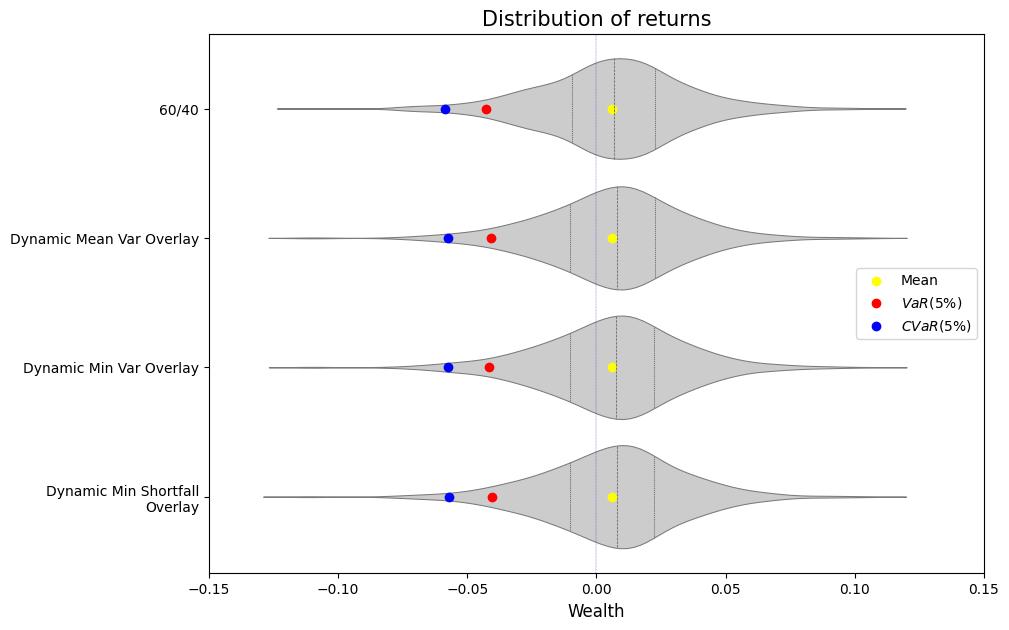

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
strategy_list =['return_6040', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition']
name_dict = {'return_6040': '60/40', 'return_7030': '70/30', 'mean_var_portfolio_gold_TIPS': 'Mean Variance', 'min_var_portfolio': 'Minimum Variance', 'min_shortfall_portfolio_empirical': 'Minimum Shortfall', 
             'dynamic_pf_returns': 'Dynamic Commodity Overlay', '6040_235comm': '76.5 % 60/40 and 23.5 % Comm', 'dynamic_pf_mean_var_addition': 'Dynamic Mean Var Overlay', 'dynamic_pf_min_var_addition': 'Dynamic Min Var Overlay', 
             'dynamic_pf_min_short_addition': 'Dynamic Min Shortfall\nOverlay', 'overlay_meanvar': 'Static Mean Var Overlay', 'overlay_minvar': 'Static Min Var Overlay', 'overlay_minshort': 'Static Min Short Overlay'}
return_data = combined_data[strategy_list].rename(name_dict,axis=1).dropna(thresh=len(strategy_list))
melted_data =pd.melt(return_data, value_vars=return_data.columns, var_name='Strategy', value_name='Returns')
sns.violinplot(data = melted_data, x='Returns', y='Strategy', color='.8', linewidth=.75, inner="quart", ax=ax)
ax.set_xlabel(r"Wealth", size=12)
ax.set_ylabel(r"", size=15)
ax.set_title("Distribution of returns", size=15)
ax.axvline(0, color='blue', linestyle='--', linewidth=0.2)
ax.set_xlim(-0.15,.15)
# ax.set_ylim(0.1,0.1)

mean = np.mean(return_data, axis=0)
value_at_risk = return_data.apply(lambda x: port_VaR(x))
cond_value_at_risk = return_data.apply(lambda x: port_cVaR(x))

x_axis = [i for i in range(len(strategy_list))] 

plt.scatter(mean,x_axis, color='yellow', label=r'Mean')
plt.scatter(value_at_risk, x_axis, color='red',label=r'$VaR(5\%)$')
plt.scatter(cond_value_at_risk, x_axis, color='blue', label=r'$CVaR(5\%)$')
ax.legend()
plt.savefig("returndistr1.eps", bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


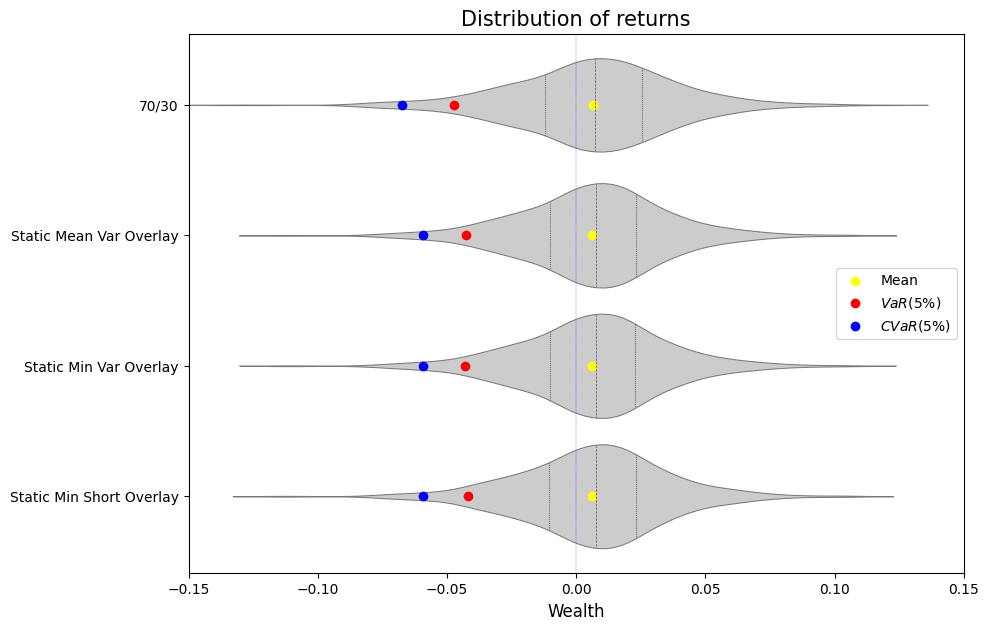

In [ ]:

fig, ax = plt.subplots(figsize=(10, 7))
strategy_list =['return_7030', 'overlay_meanvar', 'overlay_minvar', 'overlay_minshort']# 'dynamic_pf_min_var_addition', '6040_235comm', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_short_addition', 'overlay_1', 'overlay_2', 'overlay_3']
name_dict = {'return_6040': '60/40', 'return_7030': '70/30', 'mean_var_portfolio_gold_TIPS': 'Mean Variance', 'min_var_portfolio': 'Minimum Variance', 'min_shortfall_portfolio_empirical': 'Minimum Shortfall', 
             'dynamic_pf_returns': 'Dynamic Commodity Overlay', '6040_235comm': '76.5 % 60/40 and 23.5 % Comm', 'dynamic_pf_mean_var_addition': 'Dynamic Mean Var Overlay', 'dynamic_pf_min_var_addition': 'Dynamic Min Var Overlay', 
             'dynamic_pf_min_short_addition': 'Dynamic Minimum Shortfall Overlay', 'overlay_meanvar': 'Static Mean Var Overlay', 'overlay_minvar': 'Static Min Var Overlay', 'overlay_minshort': 'Static Min Short Overlay'}
return_data = combined_data[strategy_list].rename(name_dict,axis=1).dropna(thresh=len(strategy_list))
melted_data =pd.melt(return_data, value_vars=return_data.columns, var_name='Strategy', value_name='Returns')
sns.violinplot(data = melted_data, x='Returns', y='Strategy', color='.8', linewidth=.75, inner="quart", ax=ax)
ax.set_xlabel(r"Wealth", size=12)
ax.set_ylabel(r"", size=15)
ax.set_title("Distribution of returns", size=15)
ax.axvline(0, color='blue', linestyle='--', linewidth=0.2)
ax.set_xlim(-0.15,0.15)
# ax.set_ylim(-0.15,1.5)

mean = np.mean(return_data, axis=0)
value_at_risk = return_data.apply(lambda x: port_VaR(x))
cond_value_at_risk = return_data.apply(lambda x: port_cVaR(x))

x_axis = [i for i in range(len(strategy_list))] 

plt.scatter(mean,x_axis, color='yellow', label=r'Mean')
plt.scatter(value_at_risk, x_axis, color='red',label=r'$VaR(5\%)$')
plt.scatter(cond_value_at_risk, x_axis, color='blue', label=r'$CVaR(5\%)$')
ax.legend()
plt.savefig("returndistr2.eps", bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


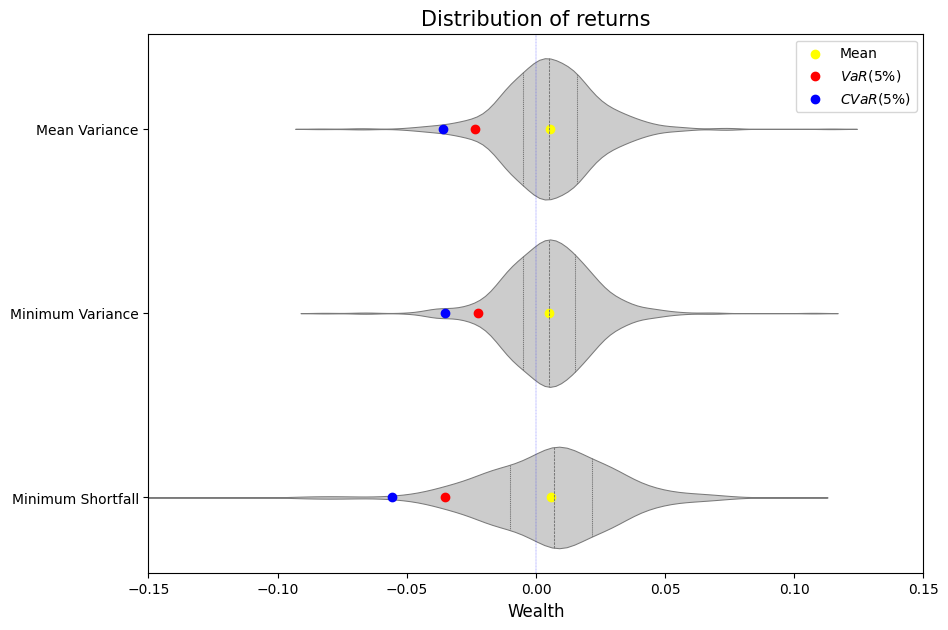

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
strategy_list =['mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 'min_shortfall_portfolio_empirical']# 'dynamic_pf_min_var_addition', '6040_235comm', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_short_addition', 'overlay_1', 'overlay_2', 'overlay_3']
name_dict = {'return_6040': '60/40', 'return_7030': '70/30', 'mean_var_portfolio_gold_TIPS': 'Mean Variance', 'min_var_portfolio': 'Minimum Variance', 'min_shortfall_portfolio_empirical': 'Minimum Shortfall', 
             'dynamic_pf_returns': 'Dynamic Commodity Overlay', '6040_235comm': '76.5 % 60/40 and 23.5 % Comm', 'dynamic_pf_mean_var_addition': 'Dynamic Mean Var Overlay', 'dynamic_pf_min_var_addition': 'Dynamic Min Var Overlay', 
             'dynamic_pf_min_short_addition': 'Dynamic Minimum Shortfall Overlay', 'overlay_meanvar': 'Static Mean Var Overlay', 'overlay_minvar': 'Static Min Var Overlay', 'overlay_minshort': 'Static Min Short Overlay'}
return_data = combined_data[strategy_list].rename(name_dict,axis=1).dropna(thresh=len(strategy_list))
melted_data =pd.melt(return_data, value_vars=return_data.columns, var_name='Strategy', value_name='Returns')
sns.violinplot(data = melted_data, x='Returns', y='Strategy', color='.8', linewidth=.75, inner="quart", ax=ax)
ax.set_xlabel(r"Wealth", size=12)
ax.set_ylabel(r"", size=15)
ax.set_title("Distribution of returns", size=15)
ax.axvline(0, color='blue', linestyle='--', linewidth=0.2)
ax.set_xlim(-0.15,0.15)
# ax.set_ylim(-0.15,1.5)

mean = np.mean(return_data, axis=0)
value_at_risk = return_data.apply(lambda x: port_VaR(x))
cond_value_at_risk = return_data.apply(lambda x: port_cVaR(x))

x_axis = [i for i in range(len(strategy_list))] 

plt.scatter(mean,x_axis, color='yellow', label=r'Mean')
plt.scatter(value_at_risk, x_axis, color='red',label=r'$VaR(5\%)$')
plt.scatter(cond_value_at_risk, x_axis, color='blue', label=r'$CVaR(5\%)$')
ax.legend()
plt.savefig("returndistr3.eps", bbox_inches='tight', dpi=300)
plt.show()

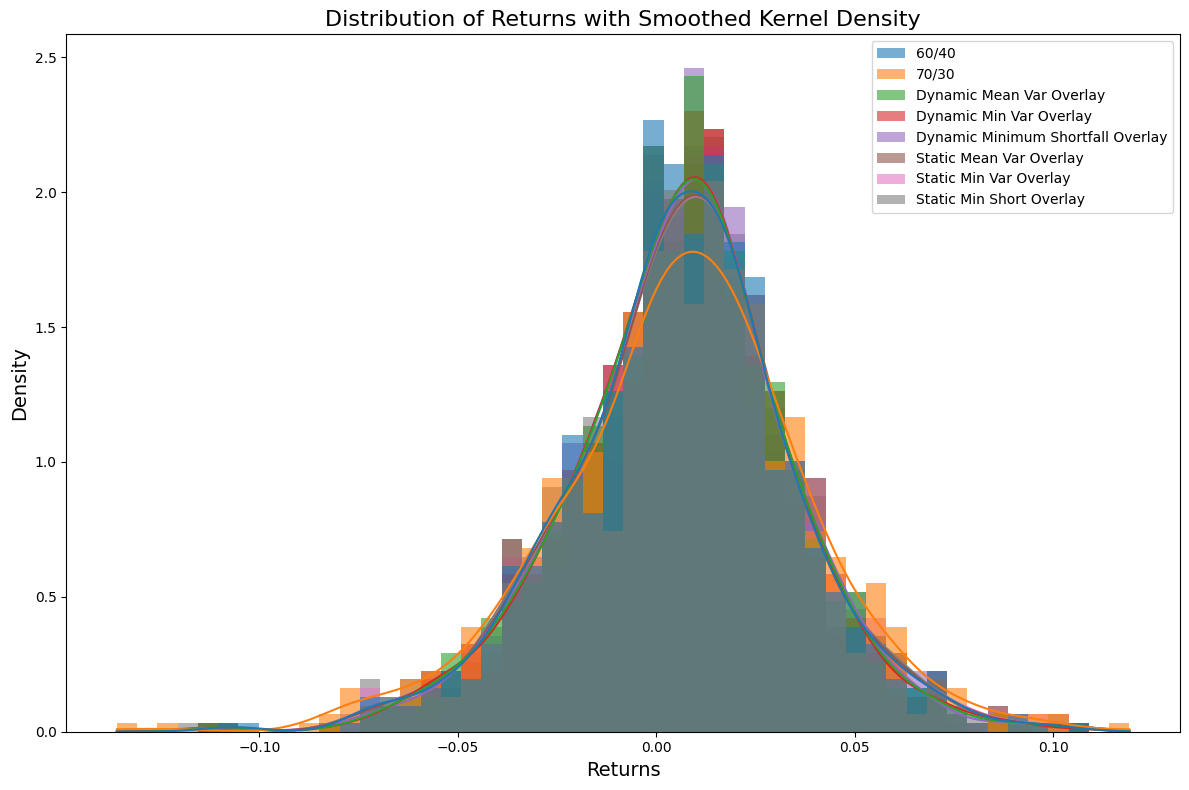

In [ ]:
strategy_list =['return_6040', 'return_7030', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 
             'dynamic_pf_min_short_addition', 'overlay_meanvar', 'overlay_minvar', 'overlay_minshort']# 'dynamic_pf_min_var_addition', '6040_235comm', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_short_addition', 'overlay_1', 'overlay_2', 'overlay_3']
name_dict = {'return_6040': '60/40', 'return_7030': '70/30', 'mean_var_portfolio_gold_TIPS': 'Mean Variance', 'min_var_portfolio': 'Minimum Variance', 'min_shortfall_portfolio_empirical': 'Minimum Shortfall', 
             'dynamic_pf_returns': 'Dynamic Commodity Overlay', '6040_235comm': '76.5 % 60/40 and 23.5 % Comm', 'dynamic_pf_mean_var_addition': 'Dynamic Mean Var Overlay', 'dynamic_pf_min_var_addition': 'Dynamic Min Var Overlay', 
             'dynamic_pf_min_short_addition': 'Dynamic Minimum Shortfall Overlay', 'overlay_meanvar': 'Static Mean Var Overlay', 'overlay_minvar': 'Static Min Var Overlay', 'overlay_minshort': 'Static Min Short Overlay'}
# strategy_list =['mean_var_portfolio_gold_TIPS', 'min_var_portfolio','min_shortfall_portfolio_empirical','dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition']#'6040_235comm', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_short_addition', 'overlay_1', 'overlay_2', 'overlay_3']

return_data = combined_data[strategy_list].rename(name_dict,axis=1)

plt.figure(figsize=(12, 8))
sns.histplot(data=return_data, kde=True, bins=50, stat="density", alpha=0.6, linewidth=0)

plt.title("Distribution of Returns with Smoothed Kernel Density", fontsize=16)
plt.xlabel("Returns", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()

## The Ultimate Portfolio Test: 2021-2024

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


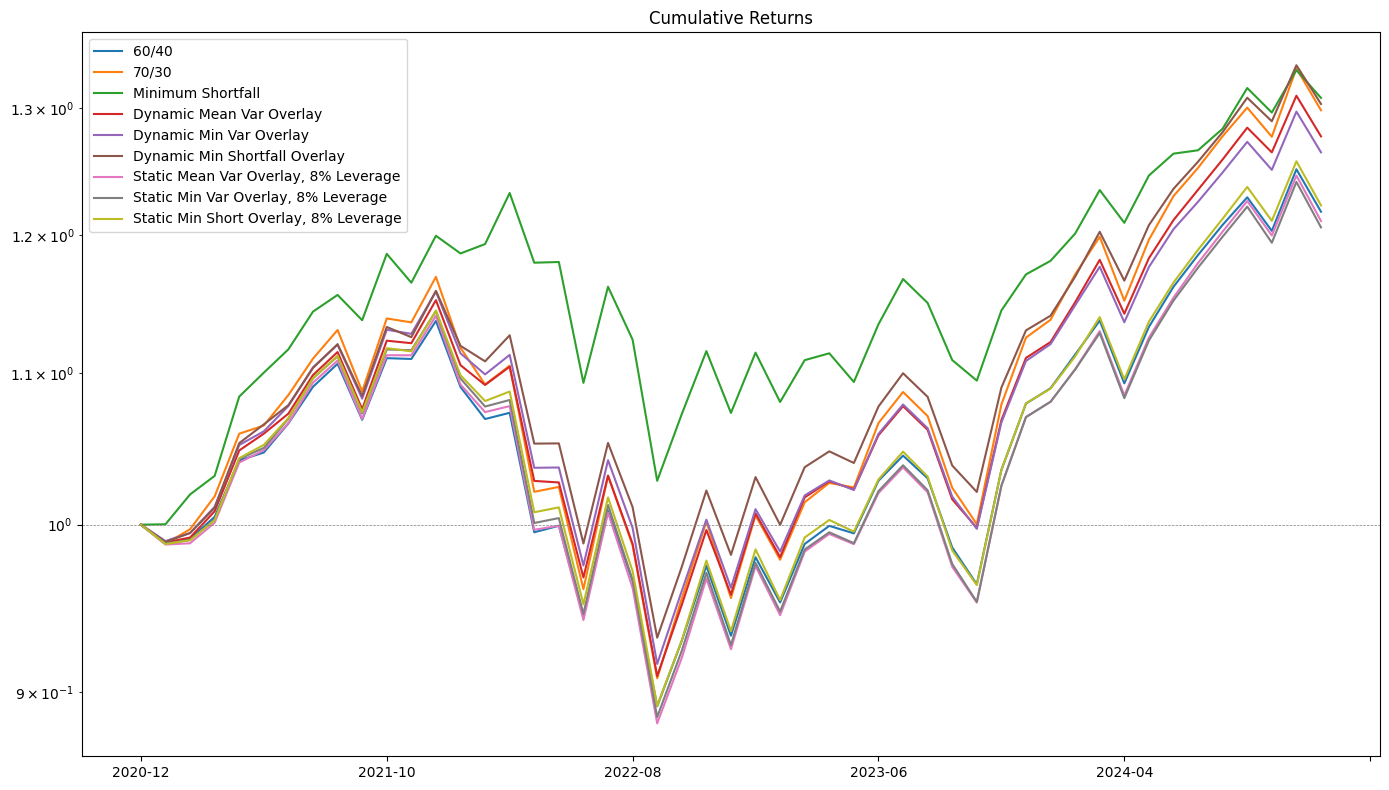

In [ ]:
# Visualization
returns_test_portfolios = pd.DataFrame()
mask_port_test = (pd.to_datetime(combined_data.index, format='%Y-%m') > '2020-12' ) & (pd.to_datetime(combined_data.index, format='%Y-%m') < '2025-01-01' )
portfolio_20212024_data = combined_data[mask_port_test]

fig, ax = plt.subplots(1, 1, figsize=(14, 8), sharex=True)
returns_test_portfolios['60/40'] = (portfolio_20212024_data['return_6040'] + 1).cumprod()
returns_test_portfolios['70/30'] = (portfolio_20212024_data['return_7030'] + 1).cumprod()
returns_test_portfolios['Minimum Shortfall'] = (portfolio_20212024_data['min_shortfall_portfolio_empirical'] + 1).cumprod()
# returns_test_portfolios['76.5 % 60/40 and 23.5 % Comm'] = (portfolio_test_data['6040_235comm'] + 1).cumprod()
# returns_test_portfolios['Mean Variance'] = (portfolio_20212024_data['mean_var_portfolio_gold_TIPS'] + 1).cumprod()
# returns_test_portfolios['Dynamic Commodity Overlay'] = (portfolio_20212024_data['dynamic_pf_returns'] + 1).cumprod()
# returns_test_portfolios['Minimum Variance'] = (portfolio_20212024_data['min_var_portfolio'] + 1).cumprod()
returns_test_portfolios['Dynamic Mean Var Overlay'] = (portfolio_20212024_data['dynamic_pf_mean_var_addition'] + 1).cumprod()
returns_test_portfolios['Dynamic Min Var Overlay'] = (portfolio_20212024_data['dynamic_pf_min_var_addition'] + 1).cumprod()
returns_test_portfolios['Dynamic Min Shortfall Overlay'] = (portfolio_20212024_data['dynamic_pf_min_short_addition'] + 1).cumprod()

returns_test_portfolios[r'Static Mean Var Overlay, 8% Leverage'] = (portfolio_20212024_data['overlay_meanvar'] + 1).cumprod()
returns_test_portfolios[r'Static Min Var Overlay, 8% Leverage'] = (portfolio_20212024_data['overlay_minvar'] + 1).cumprod() 
returns_test_portfolios[r'Static Min Short Overlay, 8% Leverage'] = (portfolio_20212024_data['overlay_minshort'] + 1).cumprod()

# returns_test_portfolios['Static Mean Var Overlay, Uncapped'] = (portfolio_20212024_data['nocap_overlay_meanvar'] + 1).cumprod()
# returns_test_portfolios['Static Min Var Overlay, Uncapped'] = (portfolio_20212024_data['nocap_overlay_minvar'] + 1).cumprod() 
# returns_test_portfolios['Static Min Short Overlay, Uncapped'] = (portfolio_20212024_data['nocap_overlay_minshort'] + 1).cumprod() 


start_date = (pd.to_datetime(portfolio_20212024_data.index[0]) - pd.DateOffset(months=1)).strftime('%Y-%m')
initial_row = pd.DataFrame([[1.0] * len(returns_test_portfolios.columns)], 
                           index=[start_date], 
                           columns=returns_test_portfolios.columns.values)
returns_test_portfolios = pd.concat([initial_row, returns_test_portfolios])
returns_test_portfolios.plot(ax=ax, logy=True)
ax.axhline(10**0, color='grey', linestyle='--', linewidth=0.5)
ax.set_title('Cumulative Returns')
ax.legend()

plt.savefig("portperformance20212024.eps", bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


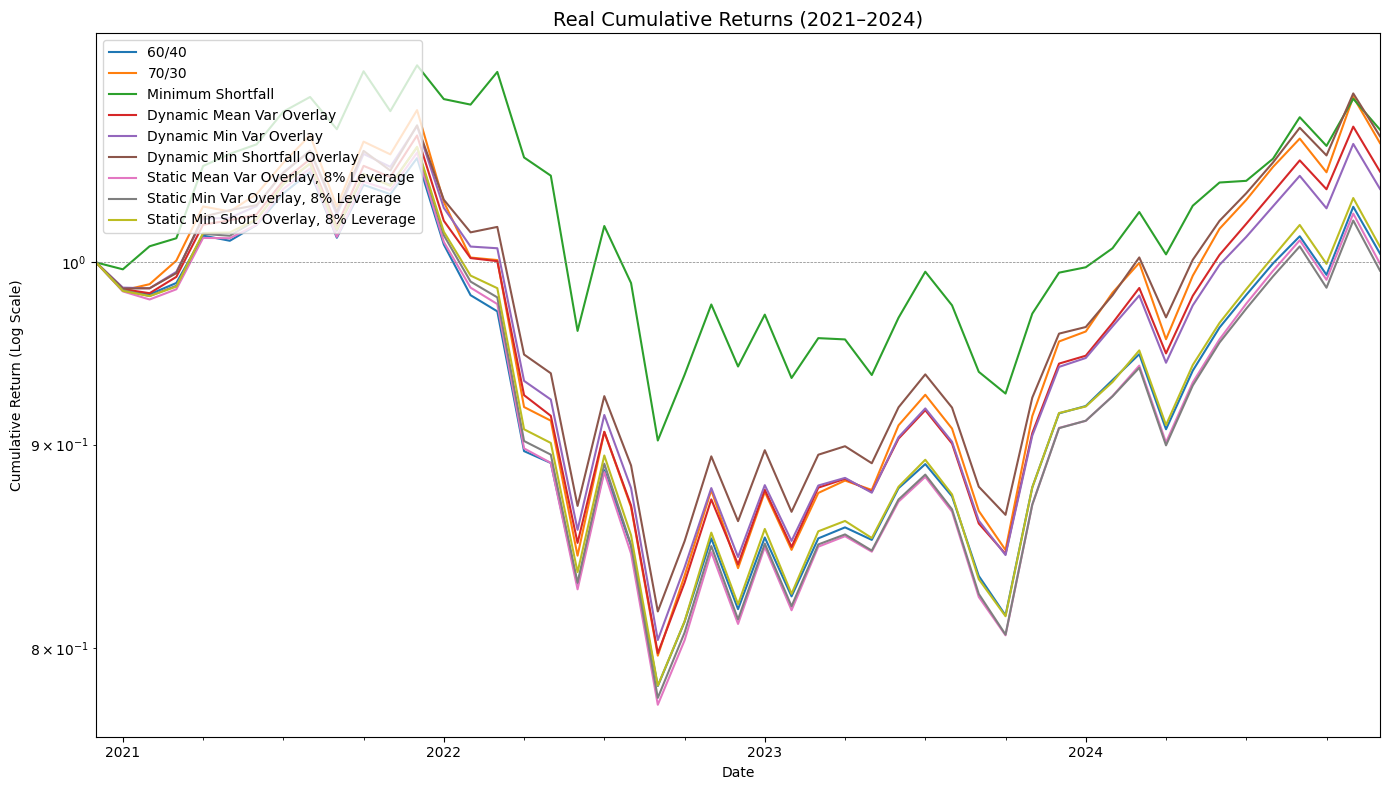

In [ ]:
# Filter data and inflation for 2021–2024
mask_port_test = (pd.to_datetime(combined_data.index, format='%Y-%m') > '2020-12') & \
                 (pd.to_datetime(combined_data.index, format='%Y-%m') < '2025-01-01')
portfolio_20212024_data = combined_data[mask_port_test]
monthly_inflation = combined_data['MoMCPI'].loc[portfolio_20212024_data.index]

# Compute real returns
real_returns = pd.DataFrame()
for col in [
    'return_6040', 'return_7030', 'min_shortfall_portfolio_empirical',
    'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
    'overlay_meanvar', 'overlay_minvar', 'overlay_minshort'
]:
    aligned = pd.concat([portfolio_20212024_data[col], monthly_inflation], axis=1).dropna()
    nominal = aligned.iloc[:, 0]
    inflation = aligned.iloc[:, 1]
    real_returns[col] = (1 + nominal) / (1 + inflation) - 1

# Compute real cumulative returns
real_cum_returns = pd.DataFrame()
real_cum_returns['60/40'] = (1 + real_returns['return_6040']).cumprod()
real_cum_returns['70/30'] = (1 + real_returns['return_7030']).cumprod()
real_cum_returns['Minimum Shortfall'] = (1 + real_returns['min_shortfall_portfolio_empirical']).cumprod()
real_cum_returns['Dynamic Mean Var Overlay'] = (1 + real_returns['dynamic_pf_mean_var_addition']).cumprod()
real_cum_returns['Dynamic Min Var Overlay'] = (1 + real_returns['dynamic_pf_min_var_addition']).cumprod()
real_cum_returns['Dynamic Min Shortfall Overlay'] = (1 + real_returns['dynamic_pf_min_short_addition']).cumprod()
real_cum_returns[r'Static Mean Var Overlay, 8% Leverage'] = (1 + real_returns['overlay_meanvar']).cumprod()
real_cum_returns[r'Static Min Var Overlay, 8% Leverage'] = (1 + real_returns['overlay_minvar']).cumprod()
real_cum_returns[r'Static Min Short Overlay, 8% Leverage'] = (1 + real_returns['overlay_minshort']).cumprod()

# Add starting point = 1
start_date = (pd.to_datetime(real_returns.index[0]) - pd.DateOffset(months=1)).strftime('%Y-%m')
initial_row = pd.DataFrame([[1.0] * len(real_cum_returns.columns)], 
                           index=[start_date], 
                           columns=real_cum_returns.columns)
real_cum_returns = pd.concat([initial_row, real_cum_returns])
real_cum_returns.index = pd.to_datetime(real_cum_returns.index)

# Plot log cumulative returns
fig, ax = plt.subplots(figsize=(14, 8))
real_cum_returns.plot(ax=ax, logy=True)

ax.axhline(10**0, color='grey', linestyle='--', linewidth=0.5)
ax.set_title('Real Cumulative Returns (2021–2024)', fontsize=14)
ax.set_ylabel('Cumulative Return (Log Scale)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig("real_portperformance20212024.eps", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
#Worst 60/40 month: 2022-09

(returns_test_portfolios.iloc[-1])-1
(returns_test_portfolios.iloc[-28])-1

60/40                                   -0.108018
70/30                                   -0.092206
Minimum Shortfall                        0.028015
Dynamic Mean Var Overlay                -0.090942
Dynamic Min Var Overlay                 -0.083968
Dynamic Min Shortfall Overlay           -0.068707
Static Mean Var Overlay, 8% Leverage    -0.117615
Static Min Var Overlay, 8% Leverage     -0.114094
Static Min Short Overlay, 8% Leverage   -0.107843
Name: 2022-09, dtype: object

In [ ]:
# Data for 2021–2024 period
portdata20212024 = portfolio_20212024_data[[
    'return_6040', 'return_7030', 'dynamic_pf_returns', 'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 
    'min_shortfall_portfolio_empirical', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
    'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 
    'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort'
]]

# Corresponding monthly inflation for the same period
monthly_inflation_2021_2024 = combined_data[['MoMCPI']].loc[portdata20212024.index]

# Real return stats
def real_return_stats(series):
    aligned = pd.concat([series, monthly_inflation_2021_2024], axis=1).dropna()
    nominal = aligned.iloc[:, 0]
    infl = aligned.iloc[:, 1]
    real_returns = (1 + nominal) / (1 + infl) - 1
    real_annual_mean = real_returns.mean() * 12
    real_annual_std = real_returns.std() * np.sqrt(12)
    real_annual_sr = real_annual_mean / real_annual_std if real_annual_std != 0 else np.nan
    return pd.Series({
        'Real Annualized Mean': real_annual_mean,
        'Real Annualized SR': real_annual_sr,
        'Real Max DD': port_max_drawdown(real_returns),
        'Real CVaR': port_cVaR(real_returns)
    })

# Calculate nominal stats
portStats_2021_2024 = pd.DataFrame()
portStats_2021_2024['Min'] = portdata20212024.min()
portStats_2021_2024['Max'] = portdata20212024.max()
portStats_2021_2024['Mean'] = portdata20212024.mean()
portStats_2021_2024['Std'] = portdata20212024.std()
portStats_2021_2024['SR'] = portStats_2021_2024['Mean'] / portStats_2021_2024['Std']
portStats_2021_2024['Skew'] = portdata20212024.skew()
portStats_2021_2024['Kurtosis'] = portdata20212024.kurtosis()
portStats_2021_2024["VaR at 5 % CI"] = portdata20212024.apply(port_VaR)
portStats_2021_2024["CVaR at 5 % CI"] = portdata20212024.apply(port_cVaR)
portStats_2021_2024["Sortino Ratio"] = portdata20212024.apply(port_sortino_ratio)
portStats_2021_2024["Max DD"] = portdata20212024.apply(port_max_drawdown)

# Compute and merge real stats
real_stats = portdata20212024.apply(real_return_stats).T
portStats_2021_2024 = pd.concat([portStats_2021_2024, real_stats], axis=1)

# Annualize nominal stats
portStats_2021_2024['Annualized Mean'] = portStats_2021_2024['Mean'] * 12
portStats_2021_2024['Annualized Std'] = portStats_2021_2024['Std'] * np.sqrt(12)
portStats_2021_2024['Annualized SR'] = portStats_2021_2024['SR'] * np.sqrt(12)
portStats_2021_2024['Annualized Sortino'] = portStats_2021_2024["Sortino Ratio"] * np.sqrt(12)

# Reorder columns
cols_order = [
    'Min', 'Max',
    'Annualized Mean', 'Annualized Std', 'Annualized SR', 'Annualized Sortino',
    'CVaR at 5 % CI', 'Max DD',
    'Real Annualized Mean', 'Real Annualized SR', 'Real CVaR', 'Real Max DD'
]
portStats_2021_2024 = portStats_2021_2024[cols_order]

# Sort portfolios by Sharpe
portStats_2021_2024.sort_values("Annualized SR")

Min       Max Annualized Mean  \
min_var_portfolio                 -0.067635  0.042313       -0.000362   
mean_var_portfolio_gold_TIPS       -0.06592  0.048786        0.007962   
nocap_overlay_minvar               -0.10165   0.07928        0.049567   
nocap_overlay_meanvar             -0.101419   0.08187        0.052937   
overlay_minvar                    -0.082608  0.075825         0.05484   
overlay_meanvar                   -0.081714  0.076259        0.055837   
nocap_overlay_minshort            -0.089743  0.075957        0.060475   
overlay_minshort                  -0.081328  0.075138        0.058166   
return_6040                       -0.075937  0.074614        0.056687   
dynamic_pf_min_var_addition       -0.082131  0.069294        0.066019   
return_7030                       -0.080302  0.078256         0.07384   
dynamic_pf_mean_var_addition      -0.079895  0.070163        0.068506   
dynamic_pf_min_short_addition     -0.078931  0.067921        0.073396   
dynamic_pf_returns                 -0.08268  0.069552        0.075924   
min_shortfall_portfolio_empirical -0.085035  0.062401        0.073194   

                                  Annualized Std Annualized SR  \
min_var_portfolio                       0.082548     -0.004386   
mean_var_portfolio_gold_TIPS            0.090166      0.088306   
nocap_overlay_minvar                    0.141996      0.349074   
nocap_overlay_meanvar                   0.144877      0.365392   
overlay_minvar                          0.126957      0.431958   
overlay_meanvar                         0.126842      0.440211   
nocap_overlay_minshort                  0.132347       0.45694   
overlay_minshort                        0.125777      0.462456   
return_6040                              0.12191      0.464992   
dynamic_pf_min_var_addition             0.121321      0.544165   
return_7030                             0.130749      0.564747   
dynamic_pf_mean_var_addition            0.121011      0.566112   
dynamic_pf_min_short_addition           0.119028      0.616626   
dynamic_pf_returns                      0.118308      0.641746   
min_shortfall_portfolio_empirical       0.108415      0.675129   

                                   Annualized Sortino  CVaR at 5 % CI  \
min_var_portfolio                           -0.005953       -0.053166   
mean_var_portfolio_gold_TIPS                 0.124605       -0.057618   
nocap_overlay_minvar                         0.498467       -0.091062   
nocap_overlay_meanvar                        0.525763       -0.092351   
overlay_minvar                               0.632457       -0.078578   
overlay_meanvar                              0.646297       -0.078318   
nocap_overlay_minshort                       0.669341       -0.082040   
overlay_minshort                             0.681364       -0.077264   
return_6040                                  0.687876       -0.074205   
dynamic_pf_min_var_addition                  0.808723       -0.075384   
return_7030                                  0.849021       -0.078323   
dynamic_pf_mean_var_addition                 0.846745       -0.074640   
dynamic_pf_min_short_addition                0.931600       -0.072435   
dynamic_pf_returns                           0.967351       -0.076673   
min_shortfall_portfolio_empirical            0.997921       -0.079158   

                                     Max DD  Real Annualized Mean  \
min_var_portfolio                 -0.152123             -0.048072   
mean_var_portfolio_gold_TIPS      -0.175662             -0.039714   
nocap_overlay_minvar              -0.254255              0.001768   
nocap_overlay_meanvar             -0.262881              0.005150   
overlay_minvar                    -0.225580              0.007030   
overlay_meanvar                   -0.226334              0.008030   
nocap_overlay_minshort            -0.228210              0.012633   
overlay_minshort                  -0.220390              0.010341   
return_6040             

In [ ]:
results["return_6040"][0].keys()

dict_keys(['Mean', 'Std', 'Sharpe Ratio', 'Sortino Ratio', 'Annualized Mean', 'Annualized Std', 'Annualized Sharpe Ratio', 'Annualized Sortino Ratio', 'Max Drawdown', 'cVaR', 'Real Annualized Mean', 'Real Annualized Sharpe Ratio', 'Real Max Drawdown', 'Real CVaR'])

C:\Users\kons-esm\AppData\Local\Temp\ipykernel_20396\1430734994.py:78: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


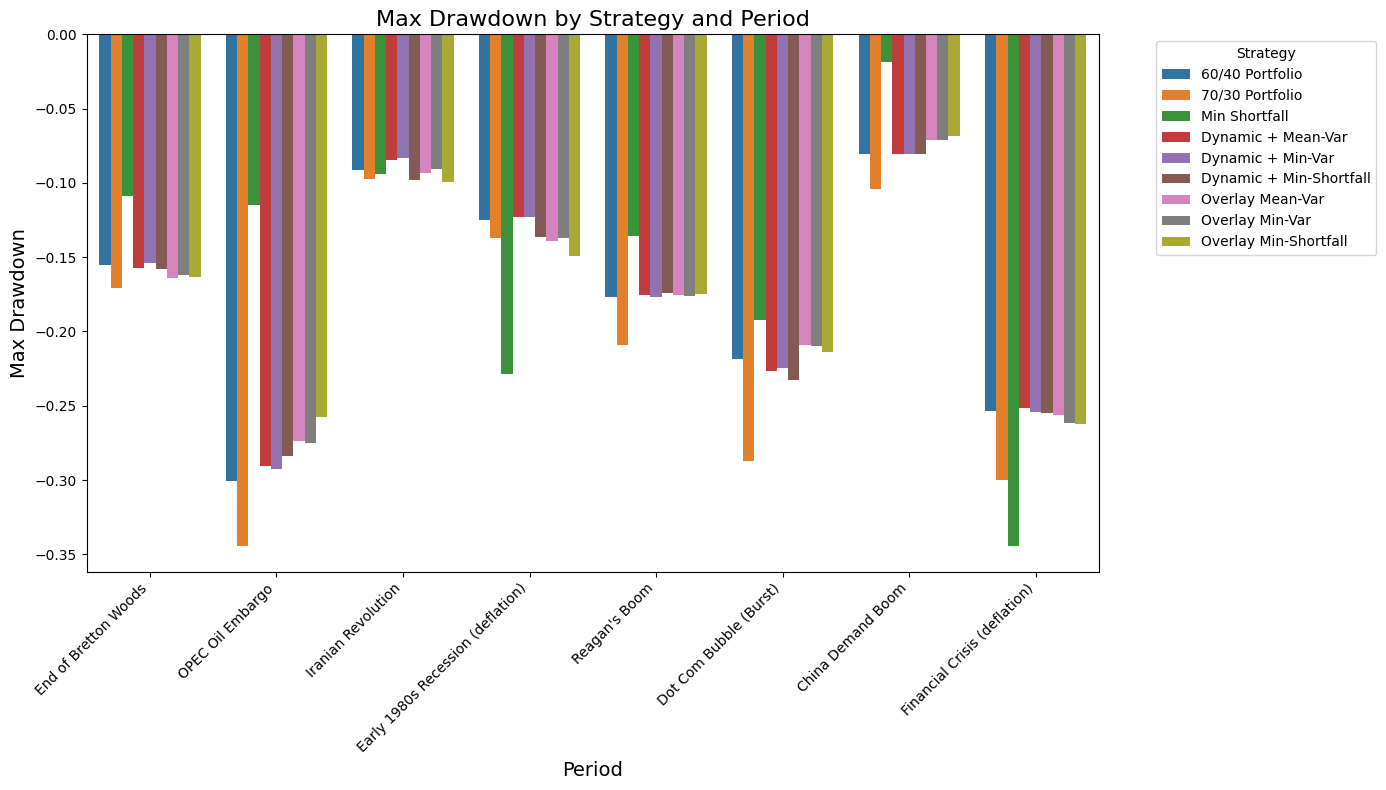

In [ ]:
# Select the key figure to display
key_figure = 'Max Drawdown'

# Flatten the results DataFrame by extracting the selected key figure for all strategies
key_figure_results = results.applymap(lambda x: x.get(key_figure) if isinstance(x, dict) else None)

# Add period information for context
key_figure_results['Period'] = results.index.get_level_values('Period')
key_figure_results['Period Start'] = results.index.get_level_values('Period Start')
key_figure_results['Period End'] = results.index.get_level_values('Period End')

# Reorder columns for better readability
key_figure_results = key_figure_results[['Period', 'Period Start', 'Period End'] + [col for col in key_figure_results.columns if col not in ['Period', 'Period Start', 'Period End']]]

key_figure_results.set_index(['Period'], inplace=True)

# Display the results for the selected key figure
key_figure_results

# Flatten the DataFrame for easier plotting
# Reset the index to get 'Period', 'Period Start', and 'Period End' as columns

# flat_results = key_figure_results.reset_index()
flat_results = key_figure_results.loc[[name for name, _, _ in date_intervals]].reset_index()

# Remove the Covid-19
flat_results = flat_results[flat_results['Period'] != 'Covid-19']

# Define which strategies to include in the plot
selected_strategies = ['return_6040',
                       'return_7030', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 
                       'dynamic_pf_min_short_addition', 'overlay_meanvar', 'overlay_minvar', 'overlay_minshort',
                       'min_shortfall_portfolio_empirical'
                    #    , 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort'
                       ]  #

strategy_name_map = {
    'return_6040': '60/40 Portfolio',
    'return_7030': '70/30 Portfolio',
    'dynamic_pf_mean_var_addition': 'Dynamic + Mean-Var',
    'dynamic_pf_min_var_addition': 'Dynamic + Min-Var',
    'dynamic_pf_min_short_addition': 'Dynamic + Min-Shortfall',
    'overlay_meanvar': 'Overlay Mean-Var',
    'overlay_minvar': 'Overlay Min-Var',
    'overlay_minshort': 'Overlay Min-Shortfall',
    'min_shortfall_portfolio_empirical': 'Min Shortfall',
    'nocap_overlay_meanvar': 'Uncapped Overlay Mean-Var',
    'nocap_overlay_minvar': 'Uncapped Overlay Min-Var',
    'nocap_overlay_minshort': 'Uncapped Overlay Min-Shortfall'
    # Add more if needed
}

# Melt the DataFrame to have 'Strategy' and 'Key Figure' as columns
melted_results = flat_results.melt(
    id_vars=['Period', 'Period Start', 'Period End'], 
    var_name='Strategy', 
    value_name='Keyfigure'
)

# Filter to include only selected strategies
melted_results = melted_results[melted_results['Strategy'].isin(selected_strategies)]

# Drop rows with NaN values in 'Key Figure'
melted_results = melted_results.dropna(subset=['Keyfigure'])

# Drop rows with NaN values in 'Key Figure'
melted_results = melted_results.dropna(subset=['Keyfigure'])

# Rename
melted_results['Strategy'] = melted_results['Strategy'].map(strategy_name_map)


# Define a distinct color palette
palette = sns.color_palette("tab10")  # You can also try "Set2", "Dark2", etc.

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_results, 
    x='Period', 
    y='Keyfigure', 
    hue='Strategy', 
    dodge=True,
    palette=palette
)

# # Customize the plot
plt.title('Max Drawdown by Strategy and Period', fontsize=16)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Max Drawdown', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig("maxdd_inflation_portfolios.eps", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [ ]:
key_figure_results.mask

<bound method NDFrame.mask of                                            Period Start Period End  \
Period                                                               
Pre-WW2                                         1900-01    1946-02   
End of WW2                                      1946-03    1947-03   
Post-WW2 to Recession                           1947-04    1948-06   
Recession of 1949 (deflation)                   1948-07    1949-07   
Post-Recession to Bretton Woods                 1949-08    1966-01   
End of Bretton Woods                            1966-02    1970-01   
Post-Bretton Woods to OPEC                      1970-02    1972-06   
OPEC Oil Embargo                                1972-07    1974-12   
Post-OPEC to Iranian Revolution                 1975-01    1977-01   
Iranian Revolution                              1977-02    1980-03   
Early 1980s Recession (deflation)               1980-04    1983-01   
Post-Early 1980s Recession                      1983-02    1

C:\Users\kons-esm\AppData\Local\Temp\ipykernel_20396\4190940268.py:62: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


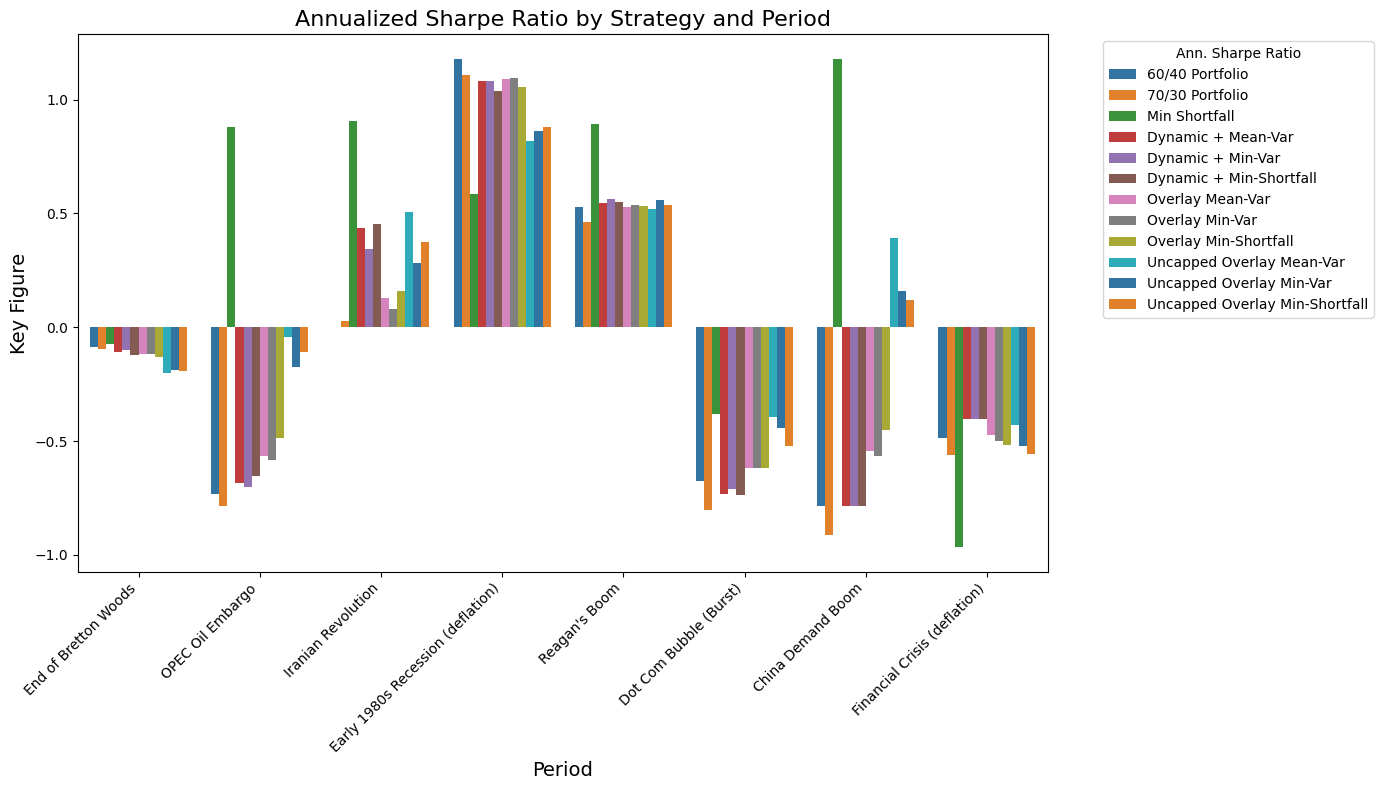

In [ ]:
# Select the key figure to display
key_figure = 'Annualized Sharpe Ratio'

# Flatten the results DataFrame by extracting the selected key figure for all strategies
key_figure_results = results.applymap(lambda x: x.get(key_figure) if isinstance(x, dict) else None)

# Add period information for context
key_figure_results['Period'] = results.index.get_level_values('Period')
key_figure_results['Period Start'] = results.index.get_level_values('Period Start')
key_figure_results['Period End'] = results.index.get_level_values('Period End')

# Reorder columns for better readability
key_figure_results = key_figure_results[['Period', 'Period Start', 'Period End'] + [col for col in key_figure_results.columns if col not in ['Period', 'Period Start', 'Period End']]]

key_figure_results.set_index(['Period'], inplace=True)

# Display the results for the selected key figure
key_figure_results

# Flatten the DataFrame for easier plotting
# Reset the index to get 'Period', 'Period Start', and 'Period End' as columns

# flat_results = key_figure_results.reset_index()
flat_results = key_figure_results.loc[[name for name, _, _ in date_intervals]].reset_index()

# Remove the Covid-19
flat_results = flat_results[flat_results['Period'] != 'Covid-19']


# Define which strategies to include in the plot
selected_strategies = ['return_6040', 
                       'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort', 
                       'min_shortfall_portfolio_empirical',
                       'return_7030', 'dynamic_pf_returns', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
                       'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 
                       ]  #  'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 

# Melt the DataFrame to have 'Strategy' and 'Key Figure' as columns
melted_results = flat_results.melt(
    id_vars=['Period', 'Period Start', 'Period End'], 
    var_name='Strategy', 
    value_name='Keyfigure'
)

# Filter to include only selected strategies
melted_results = melted_results[melted_results['Strategy'].isin(selected_strategies)]

# Drop rows with NaN values in 'Key Figure'
melted_results = melted_results.dropna(subset=['Keyfigure'])

# Drop rows with NaN values in 'Key Figure'
melted_results = melted_results.dropna(subset=['Keyfigure'])

# Rename
melted_results['Strategy'] = melted_results['Strategy'].map(strategy_name_map)

# Define a distinct color palette
palette = sns.color_palette("tab10")  # You can also try "Set2", "Dark2", etc.

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_results, 
    x='Period', 
    y='Keyfigure', 
    hue='Strategy', 
    dodge=True,
    palette=palette
)

# # Customize the plot
plt.title('Annualized Sharpe Ratio by Strategy and Period', fontsize=16)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Key Figure', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ann. Sharpe Ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig("sharpe_alternative_portfolios.eps", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

C:\Users\kons-esm\AppData\Local\Temp\ipykernel_20396\3947477530.py:66: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.barplot(


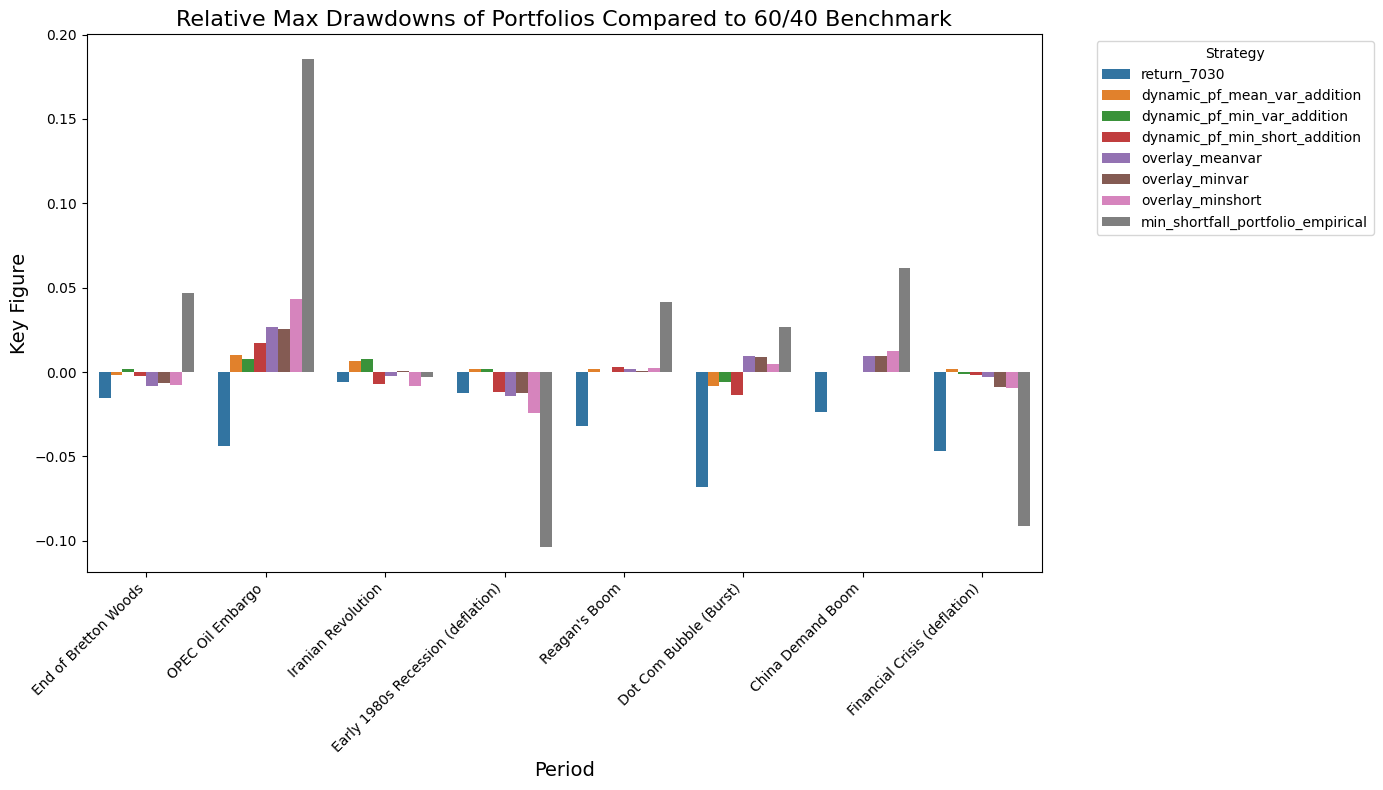

In [ ]:
# Select the key figure to display
key_figure = 'Max Drawdown'

# Flatten the results DataFrame by extracting the selected key figure for all strategies
key_figure_results = results.applymap(lambda x: x.get(key_figure) if isinstance(x, dict) else None)

# Add period information for context
key_figure_results['Period'] = results.index.get_level_values('Period')
key_figure_results['Period Start'] = results.index.get_level_values('Period Start')
key_figure_results['Period End'] = results.index.get_level_values('Period End')

# Reorder columns for better readability
key_figure_results = key_figure_results[['Period', 'Period Start', 'Period End'] + [col for col in key_figure_results.columns if col not in ['Period', 'Period Start', 'Period End']]]

key_figure_results.set_index(['Period'], inplace=True)

# Display the results for the selected key figure
key_figure_results

# Flatten the DataFrame for easier plotting
# Reset the index to get 'Period', 'Period Start', and 'Period End' as columns

# flat_results = key_figure_results.reset_index()
flat_results = key_figure_results.loc[[name for name, _, _ in date_intervals]].reset_index()

# Remove the Covid-19
flat_results = flat_results[flat_results['Period'] != 'Covid-19']

# Define which strategies to include in the plot
selected_strategies = ['return_6040',
                       'return_7030', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 
                       'dynamic_pf_min_short_addition', 'overlay_meanvar', 'overlay_minvar', 'overlay_minshort',
                       'min_shortfall_portfolio_empirical'
                    #    , 'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort'
                       ]  #

# Pivot to wide format for subtraction
wide_df = flat_results[['Period', 'Period Start', 'Period End'] + selected_strategies].copy()
wide_df.set_index('Period', inplace=True)

# Subtract 60/40 drawdowns from other strategies
baseline = 'return_6040'
diff_df = wide_df[selected_strategies].subtract(wide_df[baseline], axis=0)

# Keep period metadata
diff_df[['Period Start', 'Period End']] = wide_df[['Period Start', 'Period End']]

# Melt back to long format
melted_results = diff_df.reset_index().melt(
    id_vars=['Period', 'Period Start', 'Period End'],
    var_name='Strategy',
    value_name='Keyfigure'
)

# Drop the 60/40 row since its difference will always be 0
melted_results = melted_results[melted_results['Strategy'] != baseline]

# Drop rows with NaN values in 'Key Figure'
melted_results = melted_results.dropna(subset=['Keyfigure'])

# Define a distinct color palette
palette = sns.color_palette("tab10")  # You can also try "Set2", "Dark2", etc.

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_results, 
    x='Period', 
    y='Keyfigure', 
    hue='Strategy', 
    dodge=True,
    palette=palette
)

# # Customize the plot
plt.title('Relative Max Drawdowns of Portfolios Compared to 60/40 Benchmark', fontsize=16)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Key Figure', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig("maxdd_diffs_inflation_portfolios.eps", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


C:\Users\kons-esm\AppData\Local\Temp\ipykernel_20396\2306855559.py:70: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.barplot(


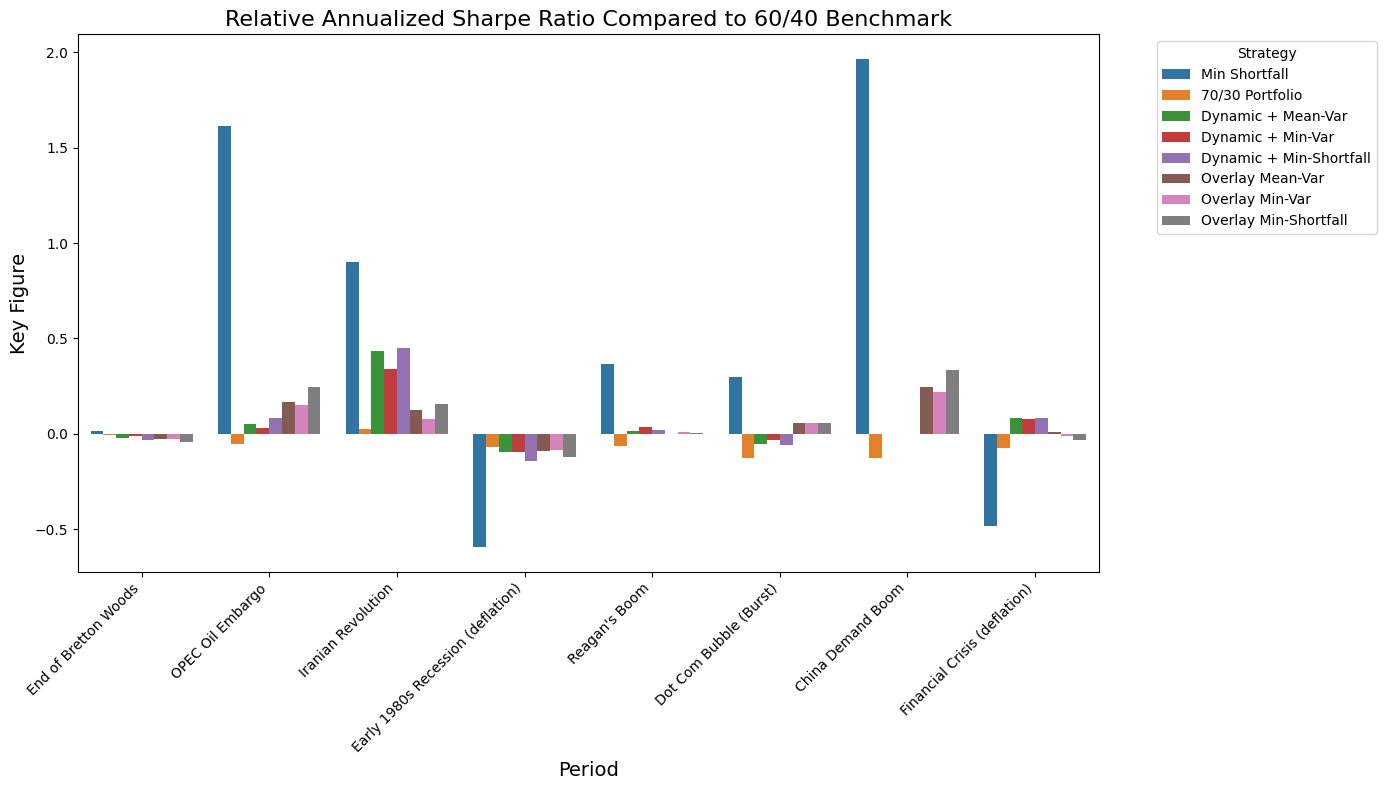

In [ ]:
# Select the key figure to display
key_figure = 'Annualized Sharpe Ratio'

# Flatten the results DataFrame by extracting the selected key figure for all strategies
key_figure_results = results.applymap(lambda x: x.get(key_figure) if isinstance(x, dict) else None)

# Add period information for context
key_figure_results['Period'] = results.index.get_level_values('Period')
key_figure_results['Period Start'] = results.index.get_level_values('Period Start')
key_figure_results['Period End'] = results.index.get_level_values('Period End')

# Reorder columns for better readability
key_figure_results = key_figure_results[['Period', 'Period Start', 'Period End'] + [col for col in key_figure_results.columns if col not in ['Period', 'Period Start', 'Period End']]]

key_figure_results.set_index(['Period'], inplace=True)

# Display the results for the selected key figure
key_figure_results

# Flatten the DataFrame for easier plotting
# Reset the index to get 'Period', 'Period Start', and 'Period End' as columns

# flat_results = key_figure_results.reset_index()
flat_results = key_figure_results.loc[[name for name, _, _ in date_intervals]].reset_index()

# Remove the Covid-19
flat_results = flat_results[flat_results['Period'] != 'Covid-19']


# Define which strategies to include in the plot
selected_strategies = ['return_6040', 
                    #    'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort', 
                       'min_shortfall_portfolio_empirical',
                       'return_7030', 'dynamic_pf_returns', 'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
                       'overlay_meanvar', 'overlay_minvar', 'overlay_minshort', 
                       ]  #  'mean_var_portfolio_gold_TIPS', 'min_var_portfolio', 

# Pivot to wide format for subtraction
wide_df = flat_results[['Period', 'Period Start', 'Period End'] + selected_strategies].copy()
wide_df.set_index('Period', inplace=True)

# Subtract 60/40 drawdowns from other strategies
baseline = 'return_6040'
diff_df = wide_df[selected_strategies].subtract(wide_df[baseline], axis=0)

# Keep period metadata
diff_df[['Period Start', 'Period End']] = wide_df[['Period Start', 'Period End']]

# Melt back to long format
melted_results = diff_df.reset_index().melt(
    id_vars=['Period', 'Period Start', 'Period End'],
    var_name='Strategy',
    value_name='Keyfigure'
)

# Drop the 60/40 row since its difference will always be 0
melted_results = melted_results[melted_results['Strategy'] != baseline]

# Drop rows with NaN values in 'Key Figure'
melted_results = melted_results.dropna(subset=['Keyfigure'])

# Rename
melted_results['Strategy'] = melted_results['Strategy'].map(strategy_name_map)

# Define a distinct color palette
palette = sns.color_palette("tab10")  # You can also try "Set2", "Dark2", etc.

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_results, 
    x='Period', 
    y='Keyfigure', 
    hue='Strategy', 
    dodge=True,
    palette=palette
)

# # Customize the plot
plt.title('Relative Annualized Sharpe Ratio Compared to 60/40 Benchmark', fontsize=16)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Key Figure', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig("sharpe__diffs_alternative_portfolios.eps", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [ ]:
date_intervals

[('End of WW2', '1946-03', '1947-03'),
 ('Recession of 1949 (deflation)', '1948-07', '1949-07'),
 ('End of Bretton Woods', '1966-02', '1970-01'),
 ('OPEC Oil Embargo', '1972-07', '1974-12'),
 ('Iranian Revolution', '1977-02', '1980-03'),
 ('Early 1980s Recession (deflation)', '1980-04', '1983-01'),
 ("Reagan's Boom", '1987-02', '1990-11'),
 ('Dot Com Bubble (Burst)', '2000-08', '2003-01'),
 ('China Demand Boom', '2007-09', '2008-07'),
 ('Financial Crisis (deflation)', '2008-07', '2009-07'),
 ('Covid-19', '2021-03', '2022-06')]

C:\Users\kons-esm\AppData\Local\Temp\ipykernel_20396\4135119069.py:58: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


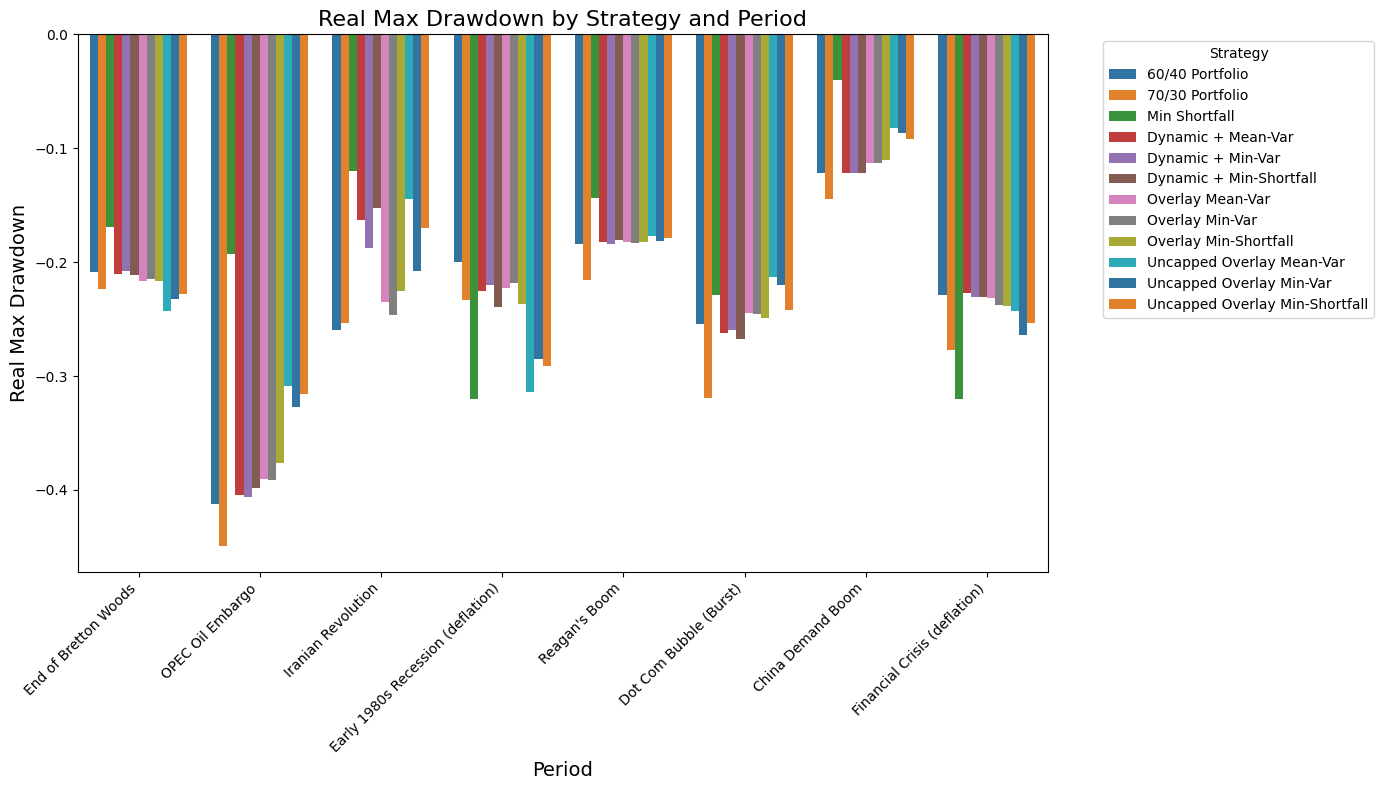

In [ ]:
# Select the real drawdown key figure
key_figure = 'Real Max Drawdown'

# Flatten the results DataFrame by extracting 'Real Max Drawdown' from each dict
key_figure_results = results.applymap(lambda x: x.get(key_figure) if isinstance(x, dict) else None)

# Add period metadata
key_figure_results['Period'] = results.index.get_level_values('Period')
key_figure_results['Period Start'] = results.index.get_level_values('Period Start')
key_figure_results['Period End'] = results.index.get_level_values('Period End')

# Reorder columns for readability
key_figure_results = key_figure_results[['Period', 'Period Start', 'Period End'] + 
                                        [col for col in key_figure_results.columns if col not in ['Period', 'Period Start', 'Period End']]]

key_figure_results.set_index(['Period'], inplace=True)

# Prepare for plotting
flat_results = key_figure_results.loc[[name for name, _, _ in date_intervals]].reset_index()
flat_results = flat_results[flat_results['Period'] != 'Covid-19']

# Strategies to include
selected_strategies = [
    'return_6040', 'return_7030',
    'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
    'overlay_meanvar', 'overlay_minvar', 'overlay_minshort',
    'min_shortfall_portfolio_empirical',
    'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort', 
]

strategy_name_map = {
    'return_6040': '60/40 Portfolio',
    'return_7030': '70/30 Portfolio',
    'dynamic_pf_mean_var_addition': 'Dynamic + Mean-Var',
    'dynamic_pf_min_var_addition': 'Dynamic + Min-Var',
    'dynamic_pf_min_short_addition': 'Dynamic + Min-Shortfall',
    'overlay_meanvar': 'Overlay Mean-Var',
    'overlay_minvar': 'Overlay Min-Var',
    'overlay_minshort': 'Overlay Min-Shortfall',
    'min_shortfall_portfolio_empirical': 'Min Shortfall',
    'nocap_overlay_meanvar': 'Uncapped Overlay Mean-Var',
    'nocap_overlay_minvar': 'Uncapped Overlay Min-Var',
    'nocap_overlay_minshort': 'Uncapped Overlay Min-Shortfall',
}

# Melt for plotting
melted_results = flat_results.melt(
    id_vars=['Period', 'Period Start', 'Period End'],
    var_name='Strategy',
    value_name='Keyfigure'
)
melted_results = melted_results[melted_results['Strategy'].isin(selected_strategies)]
melted_results = melted_results.dropna(subset=['Keyfigure'])
melted_results['Strategy'] = melted_results['Strategy'].map(strategy_name_map)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_results,
    x='Period',
    y='Keyfigure',
    hue='Strategy',
    dodge=True,
    palette=sns.color_palette("tab10")
)

# Customize
plt.title('Real Max Drawdown by Strategy and Period', fontsize=16)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Real Max Drawdown', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig("real_maxdd_inflation_portfolios.eps", bbox_inches='tight', dpi=300)
plt.show()


C:\Users\kons-esm\AppData\Local\Temp\ipykernel_20396\866574388.py:58: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


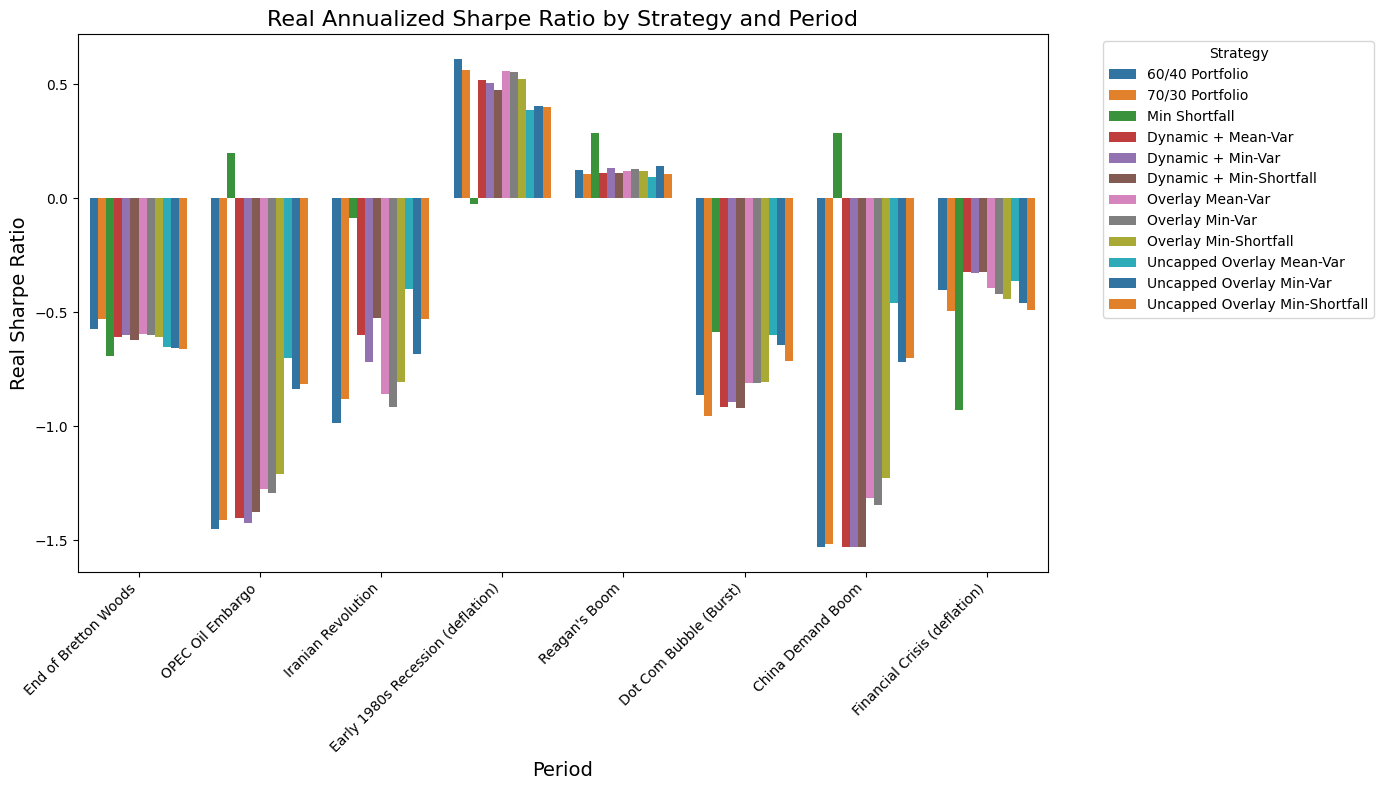

In [ ]:
# Select the real drawdown key figure
key_figure = 'Real Annualized Sharpe Ratio'

# Flatten the results DataFrame by extracting 'Real Max Drawdown' from each dict
key_figure_results = results.applymap(lambda x: x.get(key_figure) if isinstance(x, dict) else None)

# Add period metadata
key_figure_results['Period'] = results.index.get_level_values('Period')
key_figure_results['Period Start'] = results.index.get_level_values('Period Start')
key_figure_results['Period End'] = results.index.get_level_values('Period End')

# Reorder columns for readability
key_figure_results = key_figure_results[['Period', 'Period Start', 'Period End'] + 
                                        [col for col in key_figure_results.columns if col not in ['Period', 'Period Start', 'Period End']]]

key_figure_results.set_index(['Period'], inplace=True)

# Prepare for plotting
flat_results = key_figure_results.loc[[name for name, _, _ in date_intervals]].reset_index()
flat_results = flat_results[flat_results['Period'] != 'Covid-19']

# Strategies to include
selected_strategies = [
    'return_6040', 'return_7030',
    'dynamic_pf_mean_var_addition', 'dynamic_pf_min_var_addition', 'dynamic_pf_min_short_addition',
    'overlay_meanvar', 'overlay_minvar', 'overlay_minshort',
    'min_shortfall_portfolio_empirical',
    'nocap_overlay_meanvar', 'nocap_overlay_minvar', 'nocap_overlay_minshort', 
]

strategy_name_map = {
    'return_6040': '60/40 Portfolio',
    'return_7030': '70/30 Portfolio',
    'dynamic_pf_mean_var_addition': 'Dynamic + Mean-Var',
    'dynamic_pf_min_var_addition': 'Dynamic + Min-Var',
    'dynamic_pf_min_short_addition': 'Dynamic + Min-Shortfall',
    'overlay_meanvar': 'Overlay Mean-Var',
    'overlay_minvar': 'Overlay Min-Var',
    'overlay_minshort': 'Overlay Min-Shortfall',
    'min_shortfall_portfolio_empirical': 'Min Shortfall',
    'nocap_overlay_meanvar': 'Uncapped Overlay Mean-Var',
    'nocap_overlay_minvar': 'Uncapped Overlay Min-Var',
    'nocap_overlay_minshort': 'Uncapped Overlay Min-Shortfall',
}

# Melt for plotting
melted_results = flat_results.melt(
    id_vars=['Period', 'Period Start', 'Period End'],
    var_name='Strategy',
    value_name='Keyfigure'
)
melted_results = melted_results[melted_results['Strategy'].isin(selected_strategies)]
melted_results = melted_results.dropna(subset=['Keyfigure'])
melted_results['Strategy'] = melted_results['Strategy'].map(strategy_name_map)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted_results,
    x='Period',
    y='Keyfigure',
    hue='Strategy',
    dodge=True,
    palette=sns.color_palette("tab10")
)

# Customize
plt.title('Real Annualized Sharpe Ratio by Strategy and Period', fontsize=16)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Real Sharpe Ratio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig("real_SR_inflation_portfolios.eps", bbox_inches='tight', dpi=300)
plt.show()
